In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss, get_loocv_predictions_code
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec, get_twoormore

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

In [3]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [4]:
#load data
msvds = {}
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    #get injections and projections on the voxel level.
    #Note that a preprocessing screen is applied in AllenSDK to mask at projection and injection boundaries
    #Voxels intensity not in these regions in the corresponding projection vector will be 0.
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    msvds[sid]  = msvd

512
703
1089
1097
315
313
354
698
771
803
477
549


In [5]:
#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)

In [6]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
for sid in major_structure_ids:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    #model_indices, eval_indices = indices_majorinleaf, indices_leaf
    #model_indices, eval_indices = indices_summaryinleaf, indices_leaf
    #this is the most restrictive of these 3, so eval_indices_leaf2ormore is the smallest eval set
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    #get indices of wt in leafs with 2 or more experiments, and experiments in those leafs
    #indices_leaf2ormore_wt is a subset of indices_leaf2ormore since leafs need 2 wts
    #honestly ould have just 1 experimnet as long as multiple leafs
    #indices_wt_leaf2ormore should be the same as indices_wtinleaf2ormore
    #indices_wt_leaf2ormore[sid], indices_leaf2ormore_wt[sid] 
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    
    #need to find explicitly so can be used in other experiments
    #how do we line up with leaf model...
    #reduced modelset.  also
    #indices_wtinleaf_reduced, indices_leaf_reduced = screen_index_matrices2(indices_wtinleaf[sid], indices_leaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])


    #if i want to only use indices_leaf_reduced as target in a different experiment, do i need to eliminate  
    #
    
    
    #leaf on leaf
    #eval_indices = indices_leaf
    #model_indices = indices_leaf

    #leaf on wt_leaf
    #model_indices = indices_leaf
    #eval_indices = indices_wtinleaf

    #summary on summary
    #model_indices = get_indices(experiments_minor_structures[sid])
    #eval_indices = get_indices(experiments_minor_structures[sid])

    #creleaf precise (nmodels is number of creleaf combinations)
    
    #indices_wtleaf = get_indices(creleafs[sid])

In [7]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids:
    msvds[sid].loocv_predictions_major_major = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                   msvds[sid].centroids, 
                                                                                   gammas, 
                                                                                   indices_major[sid], 
                                                                                    indices_major[sid])
    msvds[sid].loocv_predictions_major_leaf2 = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm,
                                                                                        msvds[sid].centroids,
                                                                                        gammas, 
                                                                                        indices_majorinleaf[sid], 
                                                                                        indices_leaf2ormore[sid])
    msvds[sid].loocv_predictions_summary_leaf2 = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                          msvds[sid].centroids, 
                                                                                          gammas, 
                                                                                          indices_summaryinleaf[sid], 
                                                                                          indices_leaf2ormore[sid])
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       msvds[sid].centroids, 
                                                                                       gammas, 
                                                                                       indices_leaf[sid], 
                                                                                       indices_leaf2ormore[sid])

#     msvds[sid].loocv_predictions_leaf_leaf = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm, 
#                                                                                        msvds[sid].centroids, 
#                                                                                        gammas, 
#                                                                                        indices_leaf[sid], 
#                                                                                        indices_leaf[sid])
    
    msvds[sid].loocv_predictions_wtleaf_wtleaf2 = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       msvds[sid].centroids, 
                                                                                       gammas, 
                                                                                       indices_wtinleaf2ormore[sid], 
                                                                                        indices_wtinleaf2ormore[sid])

    
    
    msvds[sid].loocv_predictions_wtleaf_leaf2 = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       msvds[sid].centroids, 
                                                                                       gammas, 
                                                                                       indices_wtinleaf[sid], 
                                                                                       indices_leaf2ormore[sid])
    #could just use leaf-leaf and censor later                                                                                      
    msvds[sid].loocv_predictions_leaf_wtleaf2 = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       msvds[sid].centroids, 
                                                                                       gammas, 
                                                                                       indices_leaf[sid], 
                                                                                        indices_wtinleaf2ormore[sid])
    #could just use leaf-leaf and censor later  
    #for comparison with prev exp
    msvds[sid].loocv_predictions_leaf_wtleaf = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       msvds[sid].centroids, 
                                                                                       gammas, 
                                                                                       indices_leaf[sid], 
                                                                                        indices_wtinleaf[sid])
    
    

    #predict all leafs using cre in that leaf 
    #indices_leaf2ormore is a reduced set of indices_leaf so that we dont have the evaluator be the only predictor
    #if we are evaluating leaf2ormore with cres we wont have this issue any more than already.
    #however, we have to not evaluate when there are no cres in the leaf

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/e

(1, 5, 36, 577)
(13, 5, 36, 577)
(13, 5, 36, 577)
(13, 5, 36, 577)
(13, 5, 36, 577)
(13, 5, 36, 577)
(13, 5, 36, 577)
(13, 5, 36, 577)
(1, 5, 7, 577)
(5, 5, 7, 577)
(5, 5, 7, 577)
(5, 5, 7, 577)
(5, 5, 7, 577)
(5, 5, 7, 577)
(5, 5, 7, 577)
(5, 5, 7, 577)
(1, 5, 122, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide


(18, 5, 122, 577)
(18, 5, 122, 577)
(18, 5, 122, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/e

(18, 5, 122, 577)
(18, 5, 122, 577)
(18, 5, 122, 577)
(18, 5, 122, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3

(1, 5, 85, 577)
(21, 5, 85, 577)
(21, 5, 85, 577)
(21, 5, 85, 577)
(21, 5, 85, 577)
(21, 5, 85, 577)
(21, 5, 85, 577)
(21, 5, 85, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda

(1, 5, 1128, 577)
(119, 5, 1128, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/a

(119, 5, 1128, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/e

(119, 5, 1128, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/a

(119, 5, 1128, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda

(119, 5, 1128, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide


(119, 5, 1128, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_

(119, 5, 1128, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/e

(1, 5, 68, 577)
(23, 5, 68, 577)
(23, 5, 68, 577)
(23, 5, 68, 577)
(23, 5, 68, 577)
(23, 5, 68, 577)
(23, 5, 68, 577)
(23, 5, 68, 577)
(1, 5, 46, 577)
(19, 5, 46, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3

(19, 5, 46, 577)
(19, 5, 46, 577)
(19, 5, 46, 577)
(19, 5, 46, 577)
(19, 5, 46, 577)
(19, 5, 46, 577)
(1, 5, 35, 577)
(9, 5, 35, 577)
(9, 5, 35, 577)
(9, 5, 35, 577)
(9, 5, 35, 577)
(9, 5, 35, 577)
(9, 5, 35, 577)
(9, 5, 35, 577)
(1, 5, 33, 577)
(13, 5, 33, 577)
(13, 5, 33, 577)
(13, 5, 33, 577)
(13, 5, 33, 577)
(13, 5, 33, 577)
(13, 5, 33, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/

(13, 5, 33, 577)
(1, 5, 30, 577)
(7, 5, 30, 577)
(7, 5, 30, 577)
(7, 5, 30, 577)
(7, 5, 30, 577)
(7, 5, 30, 577)
(7, 5, 30, 577)
(7, 5, 30, 577)
(1, 5, 78, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/e

(8, 5, 78, 577)
(8, 5, 78, 577)
(8, 5, 78, 577)
(8, 5, 78, 577)
(8, 5, 78, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


(8, 5, 78, 577)
(8, 5, 78, 577)
(1, 5, 83, 577)
(29, 5, 83, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/

(29, 5, 83, 577)
(29, 5, 83, 577)
(29, 5, 83, 577)
(29, 5, 83, 577)
(29, 5, 83, 577)
(29, 5, 83, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide


In [8]:
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))


In [9]:

#for sid in major_structure_ids:
    
    
#eval_indices_leaf2ormore are the leafs


In [28]:
print(meanloss_nwall_losses_wt_wt_leaf2ormore)
#need to evaluate leaf model on these indices
losses_wt_leaf2ormore = get_loss(reg_proj_vcount_norm_renorms, nwloocv_wtleaf_leaf2,pred_ind = eval_indices_leaf2ormore_wt, true_ind = eval_indices_leaf2ormore_wt,keys = keys)
losses_leaf_wtleaf2ormore = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_leaf2ormore_wt, true_ind = eval_indices_leaf2ormore_wt,keys = keys)
meanloss_nwall_leaf_wtleaf_censored = get_loss_best_hyp(losses_wt_leaf2ormore, best_gamma_finest_finest2)
meanloss_nwall_losses_leaf_wt_leaf2ormore = get_loss_best_hyp(losses_leaf_wtleaf2ormore, best_gamma_finest_finest2)
print(meanloss_nwall_losses_leaf_wt_leaf2ormore)
#try model with crelines other than wild type

[0.9740799         nan 0.38485956 0.22021125 0.57037274 0.20980866
 0.34254433 0.22157933        nan 0.45103978 0.85636505 0.4683424 ]
[0.94138793        nan 0.32544361 0.15096751 0.43554511 0.2047227
 0.42450517 0.20019672        nan 0.38674836 0.73987885 0.27534534]


In [18]:
nwloocv_leaf_leaf2 = {}
nwloocv_summary_leaf2 = {}
nwloocv_major_leaf2 = {}
nwloocv_wtleaf_wtleaf2 = {}
nwloocv_leaf_wtleaf2 = {}
nwloocv_leaf_wtleaf = {}
reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf = {}
nwloocv_wtleaf_leaf2 = {}

for sid in major_structure_ids:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2
    nwloocv_summary_leaf2[sid]= msvds[sid].loocv_predictions_summary_leaf2
    nwloocv_major_leaf2[sid] = msvds[sid].loocv_predictions_major_leaf2
    
    nwloocv_wtleaf_wtleaf2[sid] = msvds[sid].loocv_predictions_wtleaf_wtleaf2

    nwloocv_wtleaf_leaf2[sid]  =  msvds[sid].loocv_predictions_wtleaf_leaf2
    
    #this should be optional
    nwloocv_leaf_wtleaf2[sid] = msvds[sid].loocv_predictions_leaf_wtleaf2
    
    #for checking against previous exp
    nwloocv_leaf_wtleaf[sid] = msvds[sid].loocv_predictions_leaf_wtleaf


    #nwloocv_leaf_leaf[sid ] = msvds[sid].loocv_predictions_leaf_leaf
    
#eval_indices_leaf  = get_eval_indices(indices_leaf)

#useful for comparison with old
eval_indices_wtinleaf = get_eval_indices(indices_wtinleaf)
eval_indices_wtinleaf_reduced = get_eval_indices(indices_wtinleaf_reduced)

#msl-leaf
#get eval_indices for xxx-leaf models where xxx is a structural heirarchy
eval_indices_leaf2ormore = get_eval_indices(indices_leaf2ormore)
#loss of leaf model evaluated on leaves with two or more experiments
losses_finest_finest2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_leaf2ormore, true_ind = eval_indices_leaf2ormore,keys = keys)
#loss of summary model evaluated on leaves with two or more experiments
losses_summary_finest2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_summary_leaf2,pred_ind = eval_indices_leaf2ormore, true_ind = eval_indices_leaf2ormore,keys = keys)
#loss of major division model evaluated on leaves with two or more experiments
losses_major_finest2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_major_leaf2,pred_ind = eval_indices_leaf2ormore, true_ind = eval_indices_leaf2ormore,keys = keys)

#wlg-wt
#get eval_indices for xxx-wtleaf models
eval_indices_wtinleaf2ormore = get_eval_indices(indices_wtinleaf2ormore)
losses_wtleaf_wtleaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_wtleaf_wtleaf2,pred_ind = eval_indices_wtinleaf2ormore, true_ind = eval_indices_wtinleaf2ormore,keys = keys)
losses_leaf_wtleaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_wtleaf2,pred_ind = eval_indices_wtinleaf2ormore, true_ind = eval_indices_wtinleaf2ormore,keys = keys)

#wlg-leaf
#get eval_indices for xxx-leaf models where xxx is a cre status
#indices_leaf2ormore_wt1ormore
eval_indices_leaf2ormore_wt = get_eval_indices(indices_leaf2ormore_wt1ormore)#indices_leaf2ormore_wt)
losses_wt_leaf2ormore_wt = get_loss(reg_proj_vcount_norm_renorms, nwloocv_wtleaf_leaf2,pred_ind = eval_indices_leaf2ormore_wt, true_ind = eval_indices_leaf2ormore_wt,keys = keys)
losses_leaf_leaf2ormore_wt = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_leaf2ormore_wt, true_ind = eval_indices_leaf2ormore_wt,keys = keys)

losses_leaf_wtleaf = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_wtleaf,pred_ind = eval_indices_wtinleaf, true_ind = eval_indices_wtinleaf,keys = keys)
#losses_finest_finest = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf,pred_ind = eval_indices_leaf, true_ind = eval_indices_leaf,keys = keys)
losses_leaf_wtleaf2_otherway = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_wtinleaf_reduced, true_ind = eval_indices_wtinleaf_reduced,keys = keys)

#best_gamma_finest_finest = get_best_hyperparameters(losses_finest_finest,keys)
best_gamma_finest_finest2 = get_best_hyperparameters(losses_finest_finest2,keys)
best_gamma_summary_finest2 = get_best_hyperparameters(losses_summary_finest2,keys)
best_gamma_major_finest2 = get_best_hyperparameters(losses_major_finest2,keys)
best_gamma_wtleaf_wtleaf2 = get_best_hyperparameters(losses_wtleaf_wtleaf2,keys)
best_gamma_leaf_wtleaf2 = get_best_hyperparameters(losses_leaf_wtleaf2,keys)
best_gamma_leaf_wtleaf = get_best_hyperparameters(losses_leaf_wtleaf,keys)

#meanloss_nw_finest_finest = get_loss_best_hyp(losses_finest_finest, best_gamma_finest_finest)
meanloss_nw_finest_finest2 = get_loss_best_hyp(losses_finest_finest2, best_gamma_finest_finest2)
meanloss_nw_summary_finest2 = get_loss_best_hyp(losses_summary_finest2, best_gamma_summary_finest2)
meanloss_nw_major_finest2 = get_loss_best_hyp(losses_major_finest2, best_gamma_major_finest2)

meanloss_nw_leaf_wtleaf2 = get_loss_best_hyp(losses_leaf_wtleaf2, best_gamma_leaf_wtleaf2)
meanloss_nw_wtleaf_wtleaf2 = get_loss_best_hyp(losses_wtleaf_wtleaf2, best_gamma_wtleaf_wtleaf2)

meanloss_nw_wtleaf_leaf_wt1ormoreleaf2ormore = get_loss_best_hyp(losses_wt_leaf2ormore_wt, best_gamma_finest_finest2)
meanloss_nw_leaf_leaf_wt1ormoreleaf2ormore = get_loss_best_hyp(losses_leaf_leaf2ormore_wt, best_gamma_finest_finest2)
#meanloss_nwall_leaf_wtleaf_censored = get_loss_best_hyp(losses_wt_leaf2ormore, best_gamma_finest_finest2)
#meanloss_nwall_losses_leaf_wt_leaf2ormore = get_loss_best_hyp(losses_leaf_wtleaf2ormore, best_gamma_finest_finest2)

meanloss_nw_leaf_wtleaf = get_loss_best_hyp(losses_leaf_wtleaf, best_gamma_leaf_wtleaf)
meanloss_nwall_leaf_wtleaf = get_loss_best_hyp(losses_leaf_wtleaf2, best_gamma_finest_finest2)
meanloss_nwall_leaf_wtleaf_censored = get_loss_best_hyp(losses_leaf_wtleaf2_otherway, best_gamma_finest_finest2)

0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [ ]:
losses_wt_leaf2ormore_wt = get_loss(reg_proj_vcount_norm_renorms, nwloocv_wtleaf_leaf2,pred_ind = eval_indices_leaf2ormore_wt, true_ind = eval_indices_leaf2ormore_wt,keys = keys)

#meanloss_nw_wtleaf_leaf_wt1ormoreleaf2ormore

In [20]:
eval_indices_leaf2ormore_wt[major_structure_ids[11]]

(34,)

In [19]:
losses_wt_leaf2ormore_wt[512]

array([[2.        , 1.12506148, 1.20693518, 1.52633667, 1.07456061,
        1.13502983, 0.48556435, 2.        , 0.23437621, 0.30526766,
        0.63988983, 0.55707373, 0.98173331, 0.44659387, 1.39612607,
        1.65425878, 1.71465457, 0.23437622, 1.86021855, 2.        ,
        0.64250001, 0.1926802 , 2.        , 2.        , 2.        ,
        1.32574984, 1.4856732 , 0.86409032, 1.35224059],
       [2.        , 1.12506148, 1.20693575, 1.52633667, 1.07456061,
        1.13502983, 0.48555512, 2.        , 0.23437621, 0.30526766,
        0.63988983, 0.55707373, 0.98173331, 0.44659387, 1.39612607,
        1.65425878, 1.71465457, 0.23437622, 1.86021988, 2.        ,
        0.64250001, 0.20426195, 2.        , 2.        , 2.        ,
        1.32574984, 1.4856732 , 0.86409032, 1.32448794],
       [2.        , 1.12506148, 1.20693575, 1.52633667, 1.07456061,
        1.13502983, 0.48555884, 2.        , 0.23437621, 0.30526766,
        0.63988983, 0.55707373, 0.98173331, 0.44659387, 1.39612607,
  

In [16]:
eval_indices_leaf2ormore_wt[512]

array([ 0,  1,  2,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 18, 19, 20,
       21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34])

In [14]:
losses_leaf_leaf2ormore_wt[512].shape

(5, 29)

In [11]:
meanloss_nw_leaf_leaf_wt1ormoreleaf2ormore

array([0.81534863,        nan, 0.32948114, 0.1564403 , 0.43313333,
       0.47352382, 0.38373857, 0.40237207, 0.34366345, 0.49527924,
       0.64671111, 0.2695671 ])

In [78]:
losses = np.asarray([meanloss_nw_major_finest2,
                     meanloss_nw_summary_finest2,
                     meanloss_nw_finest_finest2,
                     meanloss_nw_leaf_wtleaf2,
                     meanloss_nw_wtleaf_wtleaf2,
                     meanloss_nw_leaf_leaf_wt1ormoreleaf2ormore,
                     meanloss_nw_wtleaf_leaf_wt1ormoreleaf2ormore,
                     meanloss_nwall_leaf_wtleaf_censored
           ]).transpose()

losses2 = losses[[4,7,2,1,10,9,11,3,5,8,6,0]]
loss =pd.DataFrame(losses2)#, columns = ['all','allwt'])
#meanloss_nwall_leaf_wtleaf_censored is with 1 wt instead of 2

In [79]:
loss

0         1         2         3         4         5         6  \
0   0.430215  0.437777  0.441478  0.306277  0.188722  0.433133  0.643365   
1   0.428393  0.382707  0.382781  0.100973  0.099833  0.402372  0.521049   
2   0.339998  0.318438  0.358034  0.181755  0.129231  0.329481  0.417124   
3   0.290682  0.290682  0.290682       NaN       NaN       NaN       NaN   
4   0.690856  0.648954  0.648999  0.426918  0.295285  0.646711  0.871457   
5   0.473747  0.491212  0.491212  0.162240  0.518663  0.495279  0.721747   
6   0.345914  0.337409  0.336090  0.234781  0.557145  0.269567  0.631903   
7   0.282160  0.270348  0.270348  0.154154  0.155343  0.156440  0.451020   
8   0.452404  0.453227  0.492633  0.159075  0.165519  0.473524  0.837036   
9   0.350794  0.348218  0.348218       NaN       NaN  0.343663  1.076354   
10  0.315337  0.318885  0.318885  0.286499  0.260809  0.383739  0.980759   
11  0.756631  0.774063  0.786928  0.678559  0.234376  0.815349  1.187620   

           7  
0   0.340083  
1   0.191150  
2   0.191988  
3        NaN  
4   0.430346  
5   0.500654  
6   0.246908  
7   0.161089  
8   0.309399  
9   0.361482  
10  0.331940  
11  0.861549

In [87]:
losses = np.asarray([meanloss_nw_finest_finest2,
                     meanloss_nwall_leaf_wtleaf_censored,
                     meanloss_nw_leaf_wtleaf2,
                     meanloss_nw_wtleaf_wtleaf2,
                     meanloss_nw_major_finest2  ,
           meanloss_nw_summary_finest2]).transpose()

losses2 = losses[[4,7,2,1,10,9,11,3,5,8,6,0]]
loss =pd.DataFrame(losses2)#, columns = ['all','allwt'])

In [88]:
loss

0         1         2         3         4         5
0   0.441478  0.340083  0.306277  0.188722  0.430215  0.437777
1   0.382781  0.191150  0.100973  0.099833  0.428393  0.382707
2   0.358034  0.191988  0.181755  0.129231  0.339998  0.318438
3   0.290682       NaN       NaN       NaN  0.290682  0.290682
4   0.648999  0.430346  0.426918  0.295285  0.690856  0.648954
5   0.491212  0.500654  0.162240  0.518663  0.473747  0.491212
6   0.336090  0.246908  0.234781  0.557145  0.345914  0.337409
7   0.270348  0.161089  0.154154  0.155343  0.282160  0.270348
8   0.492633  0.309399  0.159075  0.165519  0.452404  0.453227
9   0.348218  0.361482       NaN       NaN  0.350794  0.348218
10  0.318885  0.331940  0.286499  0.260809  0.315337  0.318885
11  0.786928  0.861549  0.678559  0.234376  0.756631  0.774063

In [13]:
meanloss_nwall_leaf_wtleaf_censored #good

array([0.86154886,        nan, 0.19198754, 0.1610887 , 0.34008342,
       0.30939897, 0.33194044, 0.19114975, 0.36148173, 0.50065412,
       0.43034572, 0.24690795])

In [27]:
meanloss_nw_finest_finest2

array([0.78692754, 0.29068181, 0.35803372, 0.27034826, 0.44147834,
       0.49263346, 0.31888494, 0.3827807 , 0.34821835, 0.49121184,
       0.64899939, 0.3360901 ])

In [15]:
meanloss_nw_wtleaf_wtleaf2

array([0.23437622,        nan, 0.12923107, 0.15534344, 0.18872236,
       0.16551881, 0.26080912, 0.09983318,        nan, 0.51866269,
       0.295285  , 0.55714492])

In [26]:
meanloss_nw_summary_finest2

array([0.7740634 , 0.29068181, 0.31843759, 0.27034826, 0.43777687,
       0.45322693, 0.31888494, 0.38270675, 0.34821835, 0.49121184,
       0.64895398, 0.337409  ])

In [25]:
meanloss_nw_major_finest2

array([0.75663051, 0.29068181, 0.33999824, 0.28215967, 0.43021525,
       0.45240446, 0.3153366 , 0.42839346, 0.3507944 , 0.47374667,
       0.69085557, 0.34591356])

In [32]:
loss


0         1         2         3         4         5
0   0.441478  0.340083  0.306277  0.188722  0.430215  0.437777
1   0.382781  0.191150  0.100973  0.099833  0.428393  0.382707
2   0.358034  0.191988  0.181755  0.129231  0.339998  0.318438
3   0.290682       NaN       NaN       NaN  0.290682  0.290682
4   0.648999  0.430346  0.426918  0.295285  0.690856  0.648954
5   0.491212  0.500654  0.162240  0.518663  0.473747  0.491212
6   0.336090  0.246908  0.234781  0.557145  0.345914  0.337409
7   0.270348  0.161089  0.154154  0.155343  0.282160  0.270348
8   0.492633  0.309399  0.159075  0.165519  0.452404  0.453227
9   0.348218  0.361482       NaN       NaN  0.350794  0.348218
10  0.318885  0.331940  0.286499  0.260809  0.315337  0.318885
11  0.786928  0.861549  0.678559  0.234376  0.756631  0.774063

In [35]:
losses_wtleaf_wtleaf2[512].shape

(5, 2)

In [31]:
%matplotlib inline
nms = len(major_structure_ids)
fig, axes = plt.subplots(nms,1, figsize = (80,250))
#for m in range(1):
for m in range(nms):
    print(m)
    sid = major_structure_ids[m]
#     sns.boxplot(x = creline[sid], y = paperlosses_all[sid][selected_gamma_all[m]], ax=axes[m,0])
#     axes[m,0].set_xticklabels(axes[m,0].get_xticklabels(), rotation=90, fontsize = 35)
#     #axes[m,0].set_yticklabels(axes[m,0].get_yticklabels(), fontsize = 40)
#     axes[m,0].tick_params(axis='y', which='major', labelsize=30)
#     #axes[m,0].set_xl
#     axes[m,0].set_ylabel(major_structures[m], fontsize = 60)
    losses_bycre = pd.DataFrame(np.asarray([losses_finest_finest2[sid][best_gamma_finest_finest2[m,0]], creline[sid][eval_indices_leaf2ormore[sid]]]).transpose())
    losses_bycre = losses_bycre.astype({0: np.float64})
    order = np.unique(losses_bycre[1])[losses_bycre.groupby(by=[1])[0].mean().argsort()]
    sns.boxplot(x = creline[sid][eval_indices_leaf2ormore[sid]], y = losses_finest_finest2[sid][best_gamma_finest_finest2[m,0]], ax=axes[m], order = order)
    #axes[m,1].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
    axes[m].set_xticklabels(axes[m].get_xticklabels(), rotation=90, fontsize = 35)
    #axes[m,0].set_xl
    axes[m].tick_params(axis='y', which='major', labelsize=30)
    axes[m].set_ylabel(major_structures[m], fontsize = 60)
    
#     sns.boxplot(x = creline[sid], y = paperlosses_all_reg[sid][selected_gamma_all_reg[m]], ax=axes[m,2])
#     #axes[m,2].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
#     axes[m,2].set_xticklabels(axes[m,2].get_xticklabels(), rotation=90, fontsize = 35)
#     axes[m,2].tick_params(axis='y', which='major', labelsize=30)
#     #axes[m,0].set_xl
#     axes[m,2].set_ylabel(major_structures[m], fontsize = 60)
    
    axes[0].set_title('Voxel-loss', fontsize = 60)
plt.tight_layout() 
    #axes[0,1].set_title('All-normalized-voxelloss', fontsize = 60)
    #axes[0,2].set_title('All-regionalloss', fontsize = 60)
    #add losses for crenorm

0
1
2
3
4
5
6
7
8
9
10
11


In [39]:
m = 4
sid = major_structure_ids[4]
losses_bycre = pd.DataFrame(np.asarray([losses_finest_finest2[sid][best_gamma_finest_finest2[m,0]], creline[sid][eval_indices_leaf2ormore[sid]]]).transpose())
losses_bycre = losses_bycre.astype({0: np.float64})
order = np.unique(losses_bycre[1])[losses_bycre.groupby(by=[1])[0].mean().argsort()]


In [42]:
np.where(order == 'Tlx3-Cre_PL56')[0]

array([19])

In [47]:
cortexgoodcres = order[:19]

In [48]:
indices_cortexgoodinleaf = {}
for sid in major_structure_ids:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    #indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_cortexgoodinleaf[sid] = get_indices2(creline[sid], cortexgoodcres,leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    


In [50]:
#indices_leaf2ormore, 

indices_cortgood_leaf2ormore = {}
indices_leaf2ormore_cortgood = {}
for sid in major_structure_ids:
    indices_cortgood_leaf2ormore[sid], indices_leaf2ormore_cortgood[sid] = screen_index_matrices2(indices_cortexgoodinleaf[sid], indices_leaf2ormore[sid])
    
eval_indices_leaf2ormore_cortgood = get_eval_indices(indices_leaf2ormore_cortgood)

In [51]:
eval_indices_leaf2ormore_cortgood

{512: array([ 0,  2,  8, 11, 12, 16, 20, 21, 23, 26, 32, 34]),
 703: array([], dtype=int64),
 1089: array([  0,   1,   2,   3,   4,   5,   6,   8,   9,  11,  12,  13,  14,
         15,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,  30,
         32,  34,  37,  38,  39,  40,  42,  43,  44,  45,  46,  47,  48,
         49,  51,  52,  53,  54,  55,  56,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  76,  77,
         78,  80,  81,  83,  84,  86,  87,  89,  90,  91,  92,  93,  94,
         96,  98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111,
        112, 115, 116, 117, 118, 119, 120, 121]),
 1097: array([ 0,  4, 10, 11, 17, 22, 23, 29, 31, 33, 35, 45, 51, 55, 56, 57, 58,
        60, 68, 75, 79]),
 315: array([   0,    1,    2, ..., 1125, 1126, 1127]),
 313: array([ 3,  4,  6,  7,  9, 13, 17, 19, 20, 22, 24, 25, 26, 27, 29, 31, 34,
        36, 38, 39, 45, 47, 52, 54, 55, 57, 59, 60, 62, 63, 66, 67]),
 354: array([ 0,  2,  5, 

In [53]:
for sid in major_structure_ids:
    #msvds[sid].loocv_predictions_leaf_creleaf = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm, 
    #                                                                                   msvds[sid].centroids, 
    #                                                                                   gammas, 
    #                                                                                   indices_leaf[sid], 
    #                                                                                    indices_wtinleaf[sid])

    msvds[sid].loocv_predictions_cortexgoodleaf_leaf2 = get_nwloocv_predictions_multimodel_merge(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       msvds[sid].centroids, 
                                                                                       gammas, 
                                                                                       indices_cortexgoodinleaf[sid], 
                                                                                       indices_leaf2ormore[sid])
    
#loocv_predictions_wtleaf_leaf2

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda

(13, 5, 36, 577)
(5, 5, 7, 577)
(18, 5, 122, 577)
(21, 5, 85, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/

(119, 5, 1128, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3

(23, 5, 68, 577)
(19, 5, 46, 577)
(9, 5, 35, 577)
(13, 5, 33, 577)
(7, 5, 30, 577)
(8, 5, 78, 577)
(29, 5, 83, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda

In [55]:
nwloocv_cortexgoodleaf_leaf2 = {}
for sid in major_structure_ids:
    nwloocv_cortexgoodleaf_leaf2[sid]  =  msvds[sid].loocv_predictions_cortexgoodleaf_leaf2
    

In [ ]:
#wlg-wt , wlg-leaf eval_indices_wtinleaf2ormore, eval_indices_leaf2ormore_wt

In [80]:
losses_cortgood_inwt = get_loss(reg_proj_vcount_norm_renorms, nwloocv_cortexgoodleaf_leaf2,pred_ind = eval_indices_wtinleaf2ormore, true_ind = eval_indices_wtinleaf2ormore,keys = keys)

losses_cortgood_inleaf = get_loss(reg_proj_vcount_norm_renorms, nwloocv_cortexgoodleaf_leaf2,pred_ind = eval_indices_leaf2ormore_wt, true_ind = eval_indices_leaf2ormore_wt,keys = keys)

In [81]:
meanloss_nw_losses_cortgood_inwt = get_loss_best_hyp(losses_cortgood_inwt, best_gamma_finest_finest2)
meanloss_nw_losses_cortgood_inleaf = get_loss_best_hyp(losses_cortgood_inleaf, best_gamma_finest_finest2)

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:263: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [82]:
meanloss_nw_losses_cortgood_inwt

array([0.23386958,        nan, 0.17752577, 0.14507084, 0.26333748,
       0.16551881, 0.26080912, 0.18692068,        nan, 0.19403308,
       0.22392721, 0.49686693])

In [83]:
meanloss_nw_losses_cortgood_inleaf

array([1.05187838,        nan, 0.37374413, 0.40903183, 0.44194648,
       0.63604497, 0.88086519, 0.44856534, 1.07635396, 0.58722555,
       0.81774527, 0.55848452])

In [84]:
losses = np.asarray([meanloss_nw_major_finest2,
                     meanloss_nw_summary_finest2,
                     meanloss_nw_finest_finest2,
                     meanloss_nw_leaf_wtleaf2,
                     meanloss_nw_losses_cortgood_inwt,
                     meanloss_nw_wtleaf_wtleaf2,
                     meanloss_nw_leaf_leaf_wt1ormoreleaf2ormore,
                     meanloss_nw_losses_cortgood_inleaf,
                     meanloss_nw_wtleaf_leaf_wt1ormoreleaf2ormore,
                     meanloss_nwall_leaf_wtleaf_censored
           ]).transpose()

losses2 = losses[[4,7,2,1,10,9,11,3,5,8,6,0]]
loss =pd.DataFrame(losses2)#, columns = ['all','allwt'])
#meanloss_nwall_leaf_wtleaf_censored is with 1 wt instead of 2

In [85]:
loss #should try good cres on good cres all model

0         1         2         3         4         5         6  \
0   0.430215  0.437777  0.441478  0.306277  0.263337  0.188722  0.433133   
1   0.428393  0.382707  0.382781  0.100973  0.186921  0.099833  0.402372   
2   0.339998  0.318438  0.358034  0.181755  0.177526  0.129231  0.329481   
3   0.290682  0.290682  0.290682       NaN       NaN       NaN       NaN   
4   0.690856  0.648954  0.648999  0.426918  0.223927  0.295285  0.646711   
5   0.473747  0.491212  0.491212  0.162240  0.194033  0.518663  0.495279   
6   0.345914  0.337409  0.336090  0.234781  0.496867  0.557145  0.269567   
7   0.282160  0.270348  0.270348  0.154154  0.145071  0.155343  0.156440   
8   0.452404  0.453227  0.492633  0.159075  0.165519  0.165519  0.473524   
9   0.350794  0.348218  0.348218       NaN       NaN       NaN  0.343663   
10  0.315337  0.318885  0.318885  0.286499  0.260809  0.260809  0.383739   
11  0.756631  0.774063  0.786928  0.678559  0.233870  0.234376  0.815349   

           7         8         9  
0   0.441946  0.643365  0.340083  
1   0.448565  0.521049  0.191150  
2   0.373744  0.417124  0.191988  
3        NaN       NaN       NaN  
4   0.817745  0.871457  0.430346  
5   0.587226  0.721747  0.500654  
6   0.558485  0.631903  0.246908  
7   0.409032  0.451020  0.161089  
8   0.636045  0.837036  0.309399  
9   1.076354  1.076354  0.361482  
10  0.880865  0.980759  0.331940  
11  1.051878  1.187620  0.861549

In [238]:
loss.to_clipboard()

In [98]:
indices_cortexgoodinleaf[315].sum(axis = 1)

array([17,  4,  2,  0,  1,  4,  6,  9,  2,  3,  4,  6,  3,  0,  1,  0,  0,
        2,  0,  8,  2,  1,  5,  5, 13,  1,  0,  0,  2,  2,  2,  1, 13, 12,
        3,  2,  3,  0,  1,  6, 13,  2,  5,  6,  0,  9,  3,  0,  3,  1,  0,
        2, 15,  6, 60,  1, 36, 19,  9, 62,  3,  8,  1,  1,  1, 11,  3,  2,
       17,  1,  1,  5,  0,  3,  6,  1,  3,  5,  1, 12,  1,  8,  1, 21,  7,
        1,  2,  5,  3, 14,  3,  3, 18,  8,  7,  5,  4,  5,  1,  5,  5,  0,
        1,  0,  1,  5,  0,  1,  3,  1,  1,  6,  6,  0,  1, 19,  4,  1,  0])

In [99]:
indices_wt1ormore_leaf2ormore[315].sum(axis = 1)

array([ 0,  0,  0,  0,  0,  0,  1,  1,  0,  2,  0,  1,  1,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  2,  1,  3,  0,  0,  0,  0,  0,  0,  0,  1,  2,
        1,  1,  1,  0,  0,  1,  2,  0,  1,  2,  0,  7,  2,  0,  0,  0,  0,
        0,  1,  1, 18,  0,  9,  2,  1, 12,  1,  1,  0,  0,  0,  1,  1,  0,
        4,  0,  1,  0,  0,  1,  0,  0,  1,  2,  0,  0,  0,  3,  1,  2,  0,
        1,  0,  0,  0,  4,  3,  0,  2,  3,  1,  1,  0,  2,  0,  1,  2,  0,
        0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  2,  0,  1,  0])

In [87]:
#indices_cortexgoodinleaf
indices_cortexgoodinleaf2ormore= {}
for sid in major_structure_ids:
    indices_cortexgoodinleaf2ormore[sid] = screen_index_matrices(indices_cortexgoodinleaf[sid], indices_cortexgoodinleaf[sid])

In [88]:
losses_cortgood_incortgood = get_loss(reg_proj_vcount_norm_renorms, nwloocv_cortexgoodleaf_leaf2,pred_ind = indices_cortexgoodinleaf2ormore, true_ind = indices_cortexgoodinleaf2ormore,keys = keys)
losses_leaf_incortgood = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = indices_cortexgoodinleaf2ormore, true_ind = indices_cortexgoodinleaf2ormore,keys = keys)

#losses_wt_incortgood = get_loss(reg_proj_vcount_norm_renorms, nwloocv_cortexgoodleaf_leaf2,pred_ind = eval_indices_leaf2ormore_wt, true_ind = eval_indices_leaf2ormore_wt,keys = keys)



In [89]:
#best_gamma_finest_finest2 = get_best_hyperparameters(losses_finest_finest2,keys)

#meanloss_nw_finest_finest = get_loss_best_hyp(losses_finest_finest, best_gamma_finest_finest)
meanloss_cortgood_incortgood = get_loss_best_hyp(losses_cortgood_incortgood, best_gamma_finest_finest2)
meanloss_leaf_incortgood = get_loss_best_hyp(losses_leaf_incortgood, best_gamma_finest_finest2)


In [90]:
meanloss_cortgood_incortgood

array([0.35369318, 2.        , 0.05496178, 0.24000613, 0.51744585,
       2.        , 0.06573359, 0.08071874, 1.98555892, 1.54696714,
       0.16777561, 1.97788301])

In [91]:
meanloss_leaf_incortgood

array([0.35369318, 0.13702211, 0.05556076, 0.18326553, 0.5157791 ,
       0.76117327, 0.0600229 , 0.07183263, 0.51099156, 0.48214034,
       1.08233811, 0.26013819])

In [101]:
major_structure_ids[2]

1089

In [104]:
indices_cortexgoodinleaf2ormore[1089].sum(axis = 0)

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])

In [109]:
indices_wtinleaf[1089].sum(axis = 0)

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])

In [108]:
indices_wt_leaf2ormore.keys()

dict_keys([])

In [56]:
losses_cortgood_leaf2ormore = get_loss(reg_proj_vcount_norm_renorms, nwloocv_cortexgoodleaf_leaf2,pred_ind = eval_indices_leaf2ormore_wt, true_ind = eval_indices_leaf2ormore_wt,keys = keys)

In [57]:
meanloss_nwall_losses_cortgood_leaf2ormore = get_loss_best_hyp(losses_cortgood_leaf2ormore, best_gamma_finest_finest2)

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:263: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [58]:
meanloss_nwall_losses_cortgood_leaf2ormore

array([0.76563951,        nan, 0.35775047, 0.16295423, 0.44197593,
       0.20980866, 0.34254433, 0.2303993 ,        nan, 0.39422673,
       0.82444126, 0.4391035 ])

In [60]:
losses_cortgood_wtleaf2ormore = get_loss(reg_proj_vcount_norm_renorms, nwloocv_cortexgoodleaf_leaf2,pred_ind = eval_indices_wtinleaf2ormore, true_ind = eval_indices_wtinleaf2ormore,keys = keys)


In [61]:
meanloss_nwall_losses_cortgood_wtleaf2ormore = get_loss_best_hyp(losses_cortgood_wtleaf2ormore, best_gamma_finest_finest2)

In [62]:
meanloss_nwall_losses_cortgood_wtleaf2ormore

array([0.23386958,        nan, 0.17752577, 0.14507084, 0.26333748,
       0.16551881, 0.26080912, 0.18692068,        nan, 0.19403308,
       0.22392721, 0.49686693])

In [63]:
meanloss_nw_wtleaf_wtleaf2

array([0.23437622,        nan, 0.12923107, 0.15534344, 0.18872236,
       0.16551881, 0.26080912, 0.09983318,        nan, 0.51866269,
       0.295285  , 0.55714492])

In [64]:
meanloss_nw_leaf_wtleaf2

array([0.67855887,        nan, 0.1817548 , 0.1541542 , 0.30627729,
       0.15907457, 0.28649866, 0.10097336,        nan, 0.16224048,
       0.42691847, 0.23478083])

In [114]:
mingamma = np.zeros((12,1), dtype = int)
maxgamma = 4*np.ones((12,1), dtype = int)


In [115]:
meanloss_nw_finest_finest2_maxgamma = get_loss_best_hyp(losses_finest_finest2, maxgamma)
meanloss_nw_finest_finest2_mingamma = get_loss_best_hyp(losses_finest_finest2, mingamma)

meanloss_nw_major_finest2_maxgamma = get_loss_best_hyp(losses_major_finest2, maxgamma)
meanloss_nw_major_finest2_mingamma = get_loss_best_hyp(losses_major_finest2, mingamma)

In [116]:
meanloss_nw_finest_finest2_maxgamma

array([0.87659026, 0.29068181, 0.41284651, 0.33329261, 0.57354919,
       0.52150523, 0.31888494, 0.40563247, 0.37693218, 0.54957053,
       0.74948082, 0.35156575])

In [117]:
meanloss_nw_finest_finest2_mingamma

array([0.78692754, 0.29068181, 0.35803372, 0.27034826, 0.44147834,
       0.49263346, 0.38303888, 0.3827807 , 0.34821835, 0.49121184,
       0.64899939, 0.3360901 ])

In [118]:
meanloss_nw_major_finest2_maxgamma

array([0.85076105, 0.29068181, 0.45892933, 0.35722333, 0.56599668,
       0.50466758, 0.34407694, 0.45786735, 0.37693217, 0.60384257,
       0.7878998 , 0.38929316])

In [119]:
meanloss_nw_major_finest2_mingamma

array([0.75663051, 0.29070171, 0.33999824, 0.28215967, 0.43021525,
       0.45323558, 0.34727666, 0.42839346, 0.3507944 , 0.47374667,
       0.69085557, 0.36533078])

In [120]:
weights_i

NameError: name 'weights_i' is not defined

In [122]:
leafs[sid]

array([      733,       362,       362,       181,       255,       629,
             362, 560581563,      1020,       218,       155,      1096,
             181,        15,       155,       599, 560581563,       483,
       496345668,       255,       930,       366,       629,       262,
             262,       685,      1020, 496345672,      1072,       733,
             149,       685, 496345668,       255,      1079,      1020,
             155,       362,       149,      1096,      1096,       733,
       496345668,        15,       930,       218,        15,       930,
              15,       483,       907,       218,       262,       718,
       496345668,      1079,      1113,        15,        59, 496345672,
             255,       218, 496345668,       362,       262,       362,
             483, 496345668,       149,       362,       362, 496345672,
             362,       186,       186,       262,       733,       155,
             178,       255,       362,       414, 

In [123]:
for sid in major_structure_ids:
    print(len(eval_indices_leaf2ormore[sid]))

31
4
118
81
1099
60
41
31
28
28
78
74


In [124]:
for sid in major_structure_ids:
    print(msvds[sid].reg_proj_vcount_norm_renorm.shape[0])

36
7
122
85
1128
68
46
35
33
30
78
83


In [125]:
leafs[sid][eval_indices_leaf2ormore[sid]]
#creline[sid][eval_indices_leaf2ormore[sid]]

array([      733,       362,       362,       181,       255,       629,
             362, 560581563,      1020,       218,       155,      1096,
             181,        15,       155, 560581563,       483, 496345668,
             255,       930,       629,       262,       262,       685,
            1020, 496345672,       733,       149,       685, 496345668,
             255,      1079,      1020,       155,       362,       149,
            1096,      1096,       733, 496345668,        15,       930,
             218,        15,       930,        15,       483,       218,
             262, 496345668,      1079,        15, 496345672,       255,
             218, 496345668,       362,       262,       362,       483,
       496345668,       149,       362,       362, 496345672,       362,
             186,       186,       262,       733,       155,       255,
             362,       362])

In [194]:
ls = [ia_map[leafs[sid][eval_indices_leaf2ormore[sid]][i]] for i in range(len(eval_indices_leaf2ormore[sid]))]
crs = creline[sid][eval_indices_leaf2ormore[sid]]
df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
df.columns = np.asarray(['leaf', 'creline','present'])
a = df.pivot_table(values='present',index='leaf',columns='creline',aggfunc=np.sum)

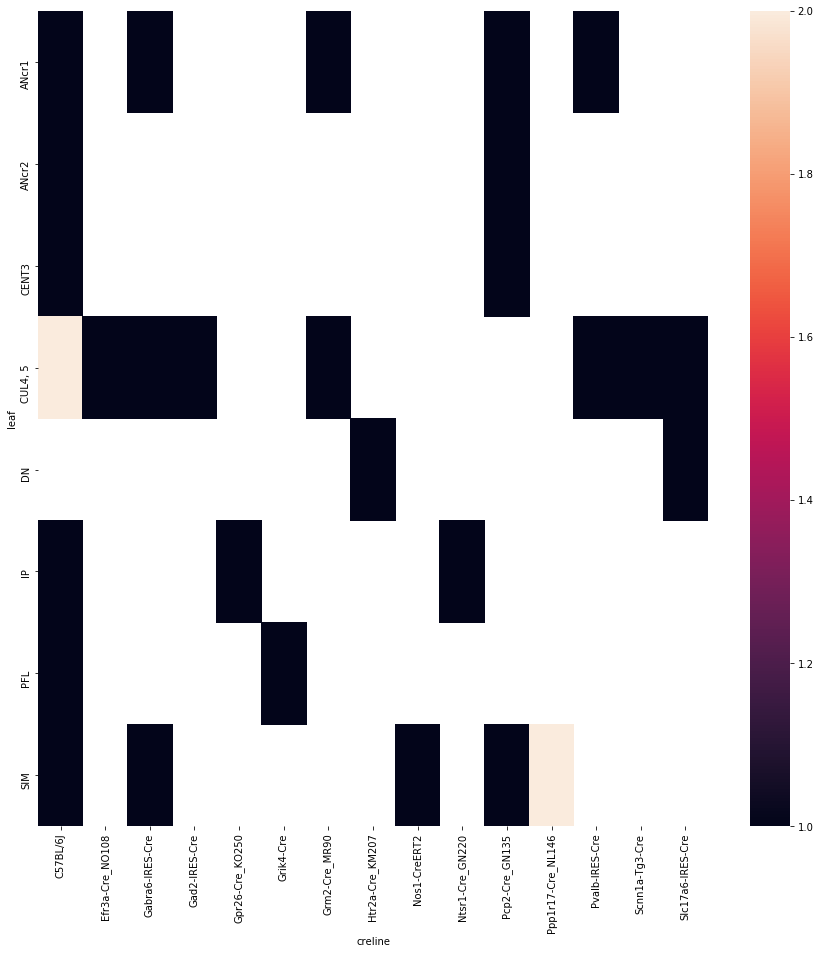

In [195]:
fig, ax = plt.subplots(1,figsize = (15,15))
sns.heatmap(a, ax = ax)
#plt.xlabel(fontsize = 15)

In [174]:
from mcmodels.core.utils import get_ontological_order_leaf

In [177]:
ontological_order_leaf = get_ontological_order_leaf(leafs,ontological_order, st)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
42
43
44
45
46
48
49
51
53
54
56
57
60
61
62
63
64
65
66
69
70
72
73
74
76
77
78
84
86
87
88
89
91
92
93
94
96
97
98
100
102
106
107
108
109
112
113
116
117
118
119
120
122
123
124
126
127
129
130
132
134
135
136
138
141
144
145
151
154
157
158
160
162
163
165
166
167
168
169
172
174
175
176
177
178
183
184
186
187
188
189
192
196
197
204
206
209
210
212
213
216
217
218
221
222
223
225
226
227
230
232
233
235
237
239
240
242
243
246
247
249
250
253
257
260
265
266
269
273
275
276
279
281
282
283
284
286
288
289
290


In [189]:
source_order = ontological_order_leaf
msvds_leaf = get_regionalized_normalized_data(msvds,cache, source_order,ipsi_targetkey,contra_targetkey)


In [198]:
print(msvds_leaf[major_structure_ids[0]].reg_inj_vcount_norm.shape)

(36, 13)


In [190]:
for sid in major_structure_ids[:1]:
    source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
    source_key = source_mask.get_key(structure_ids=source_order)
    source_regions, source_counts = nonzero_unique(source_key, return_counts=True)


In [208]:
injs[1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.50379865e-05, 3.24688520e-04,
       0.00000000e+00])

0
1
2
3
4
5
6
7
8
9
10


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


11


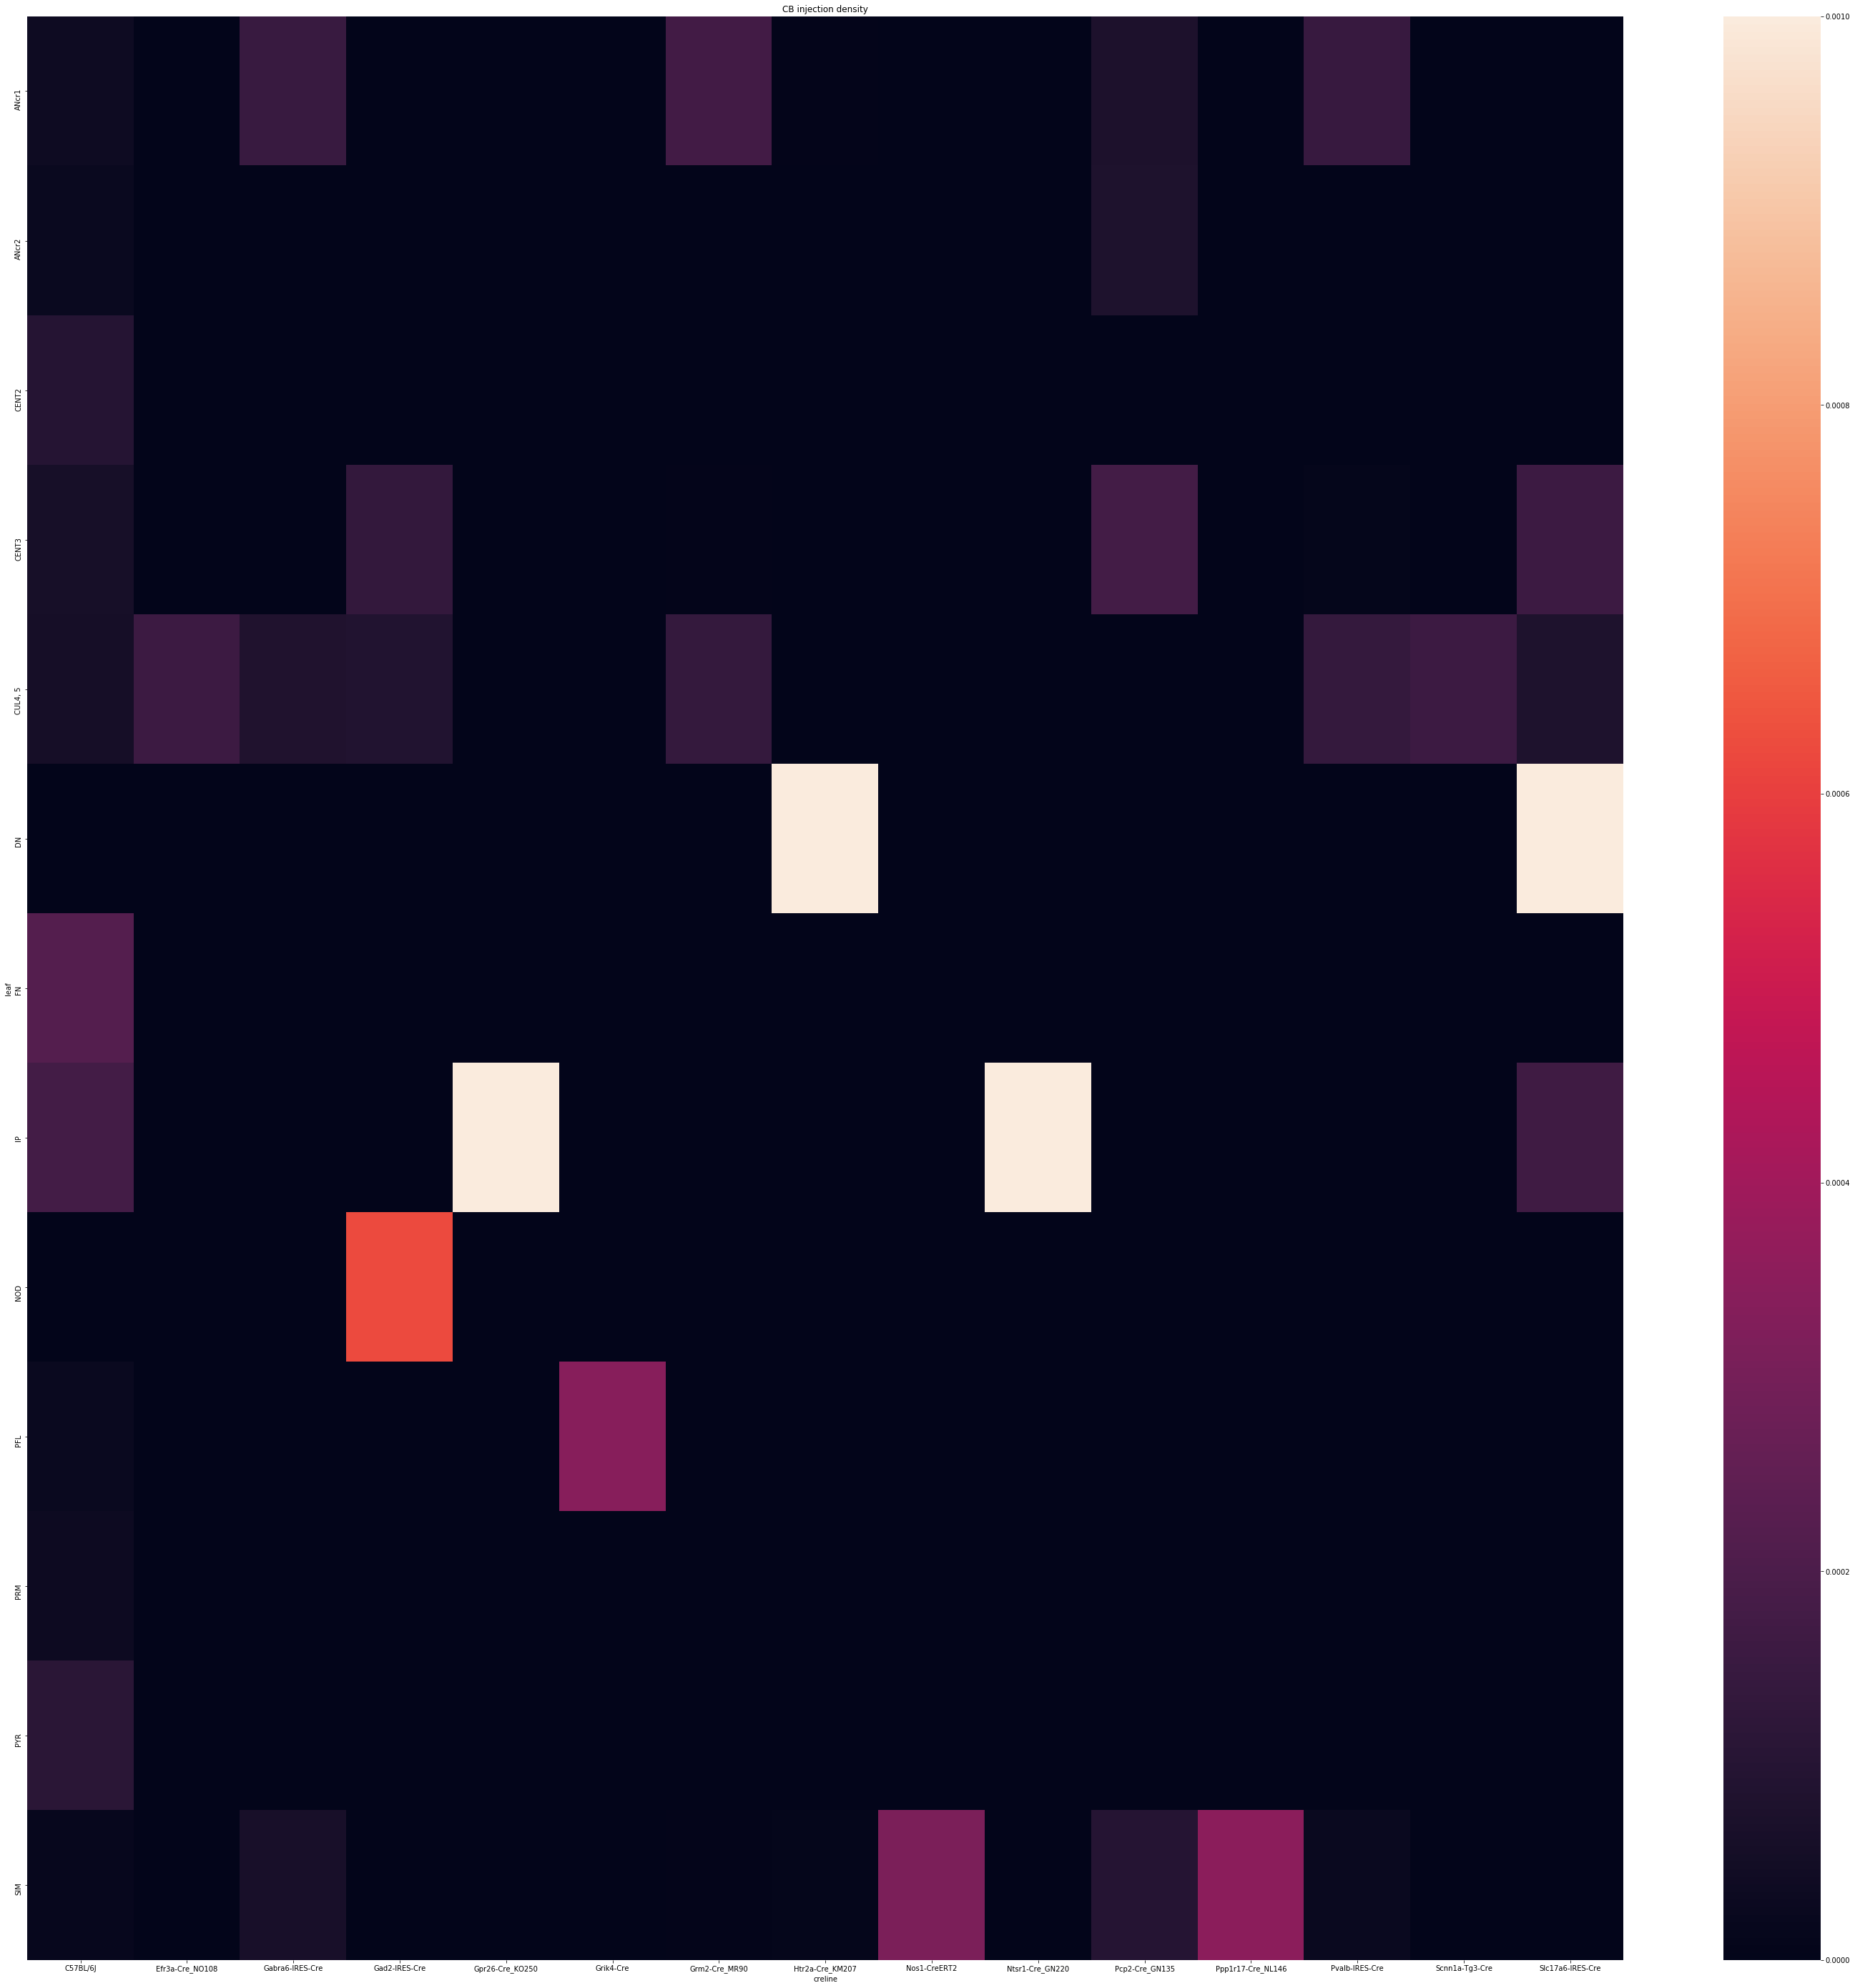

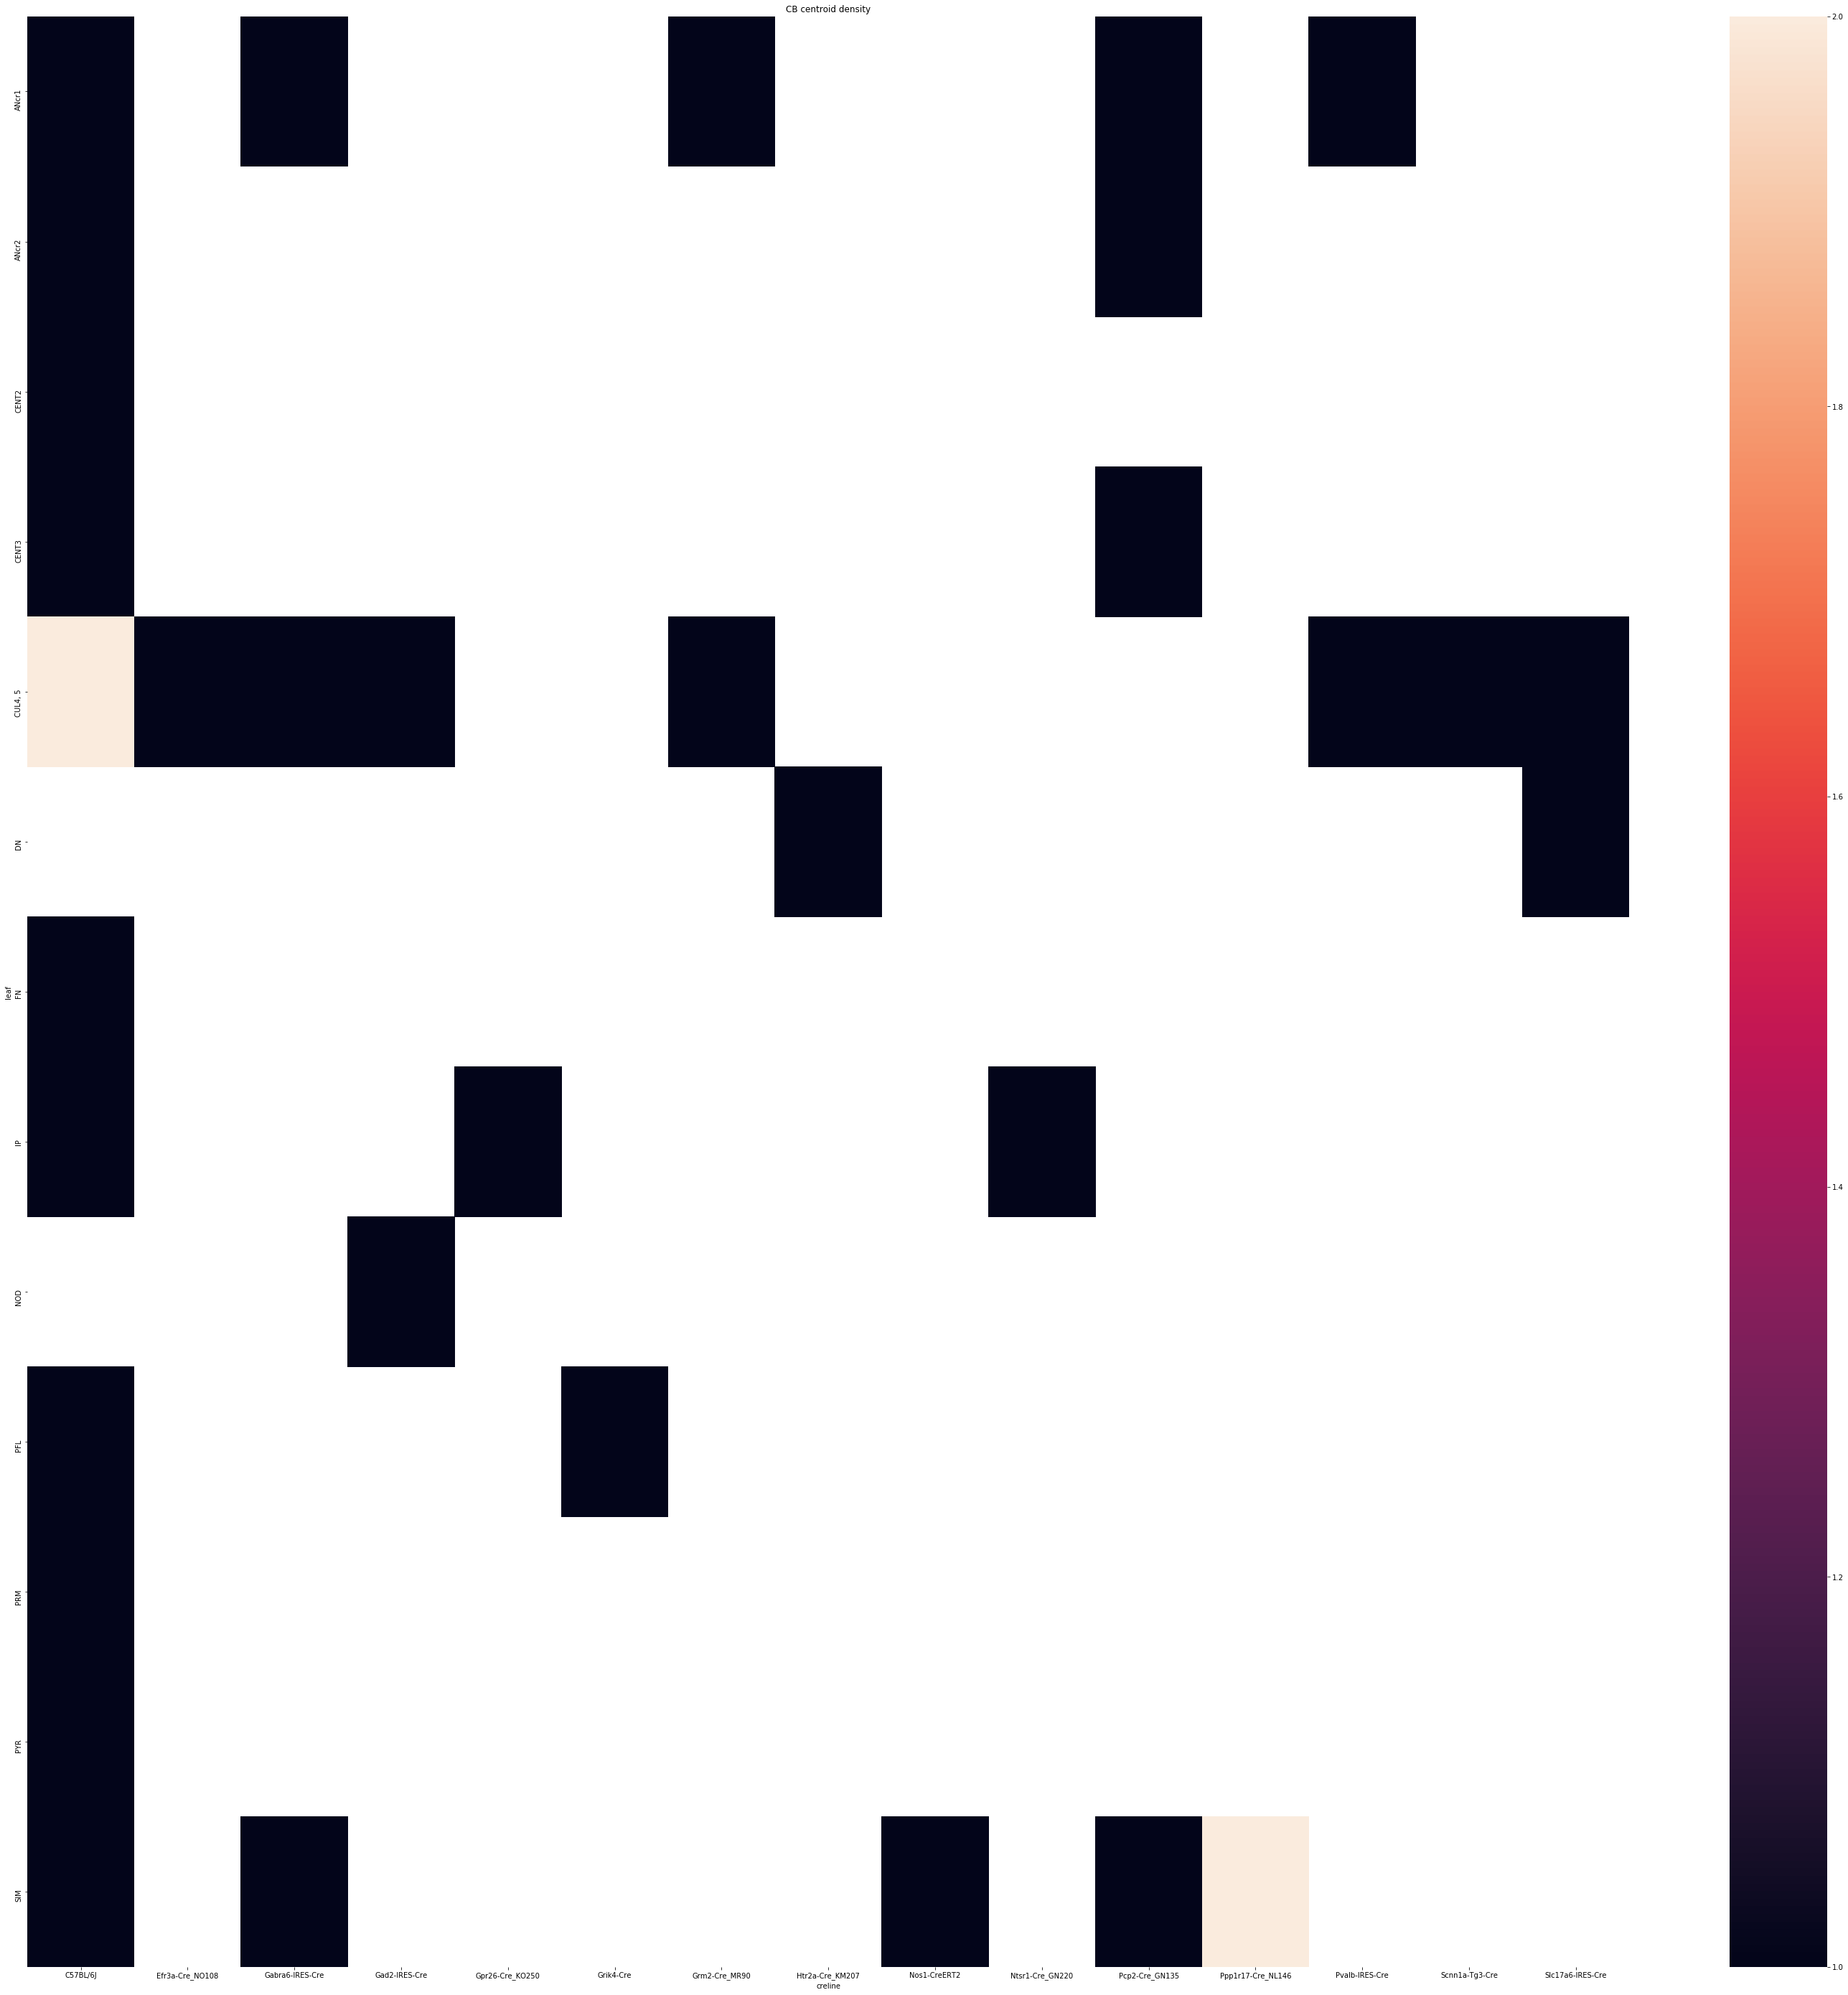

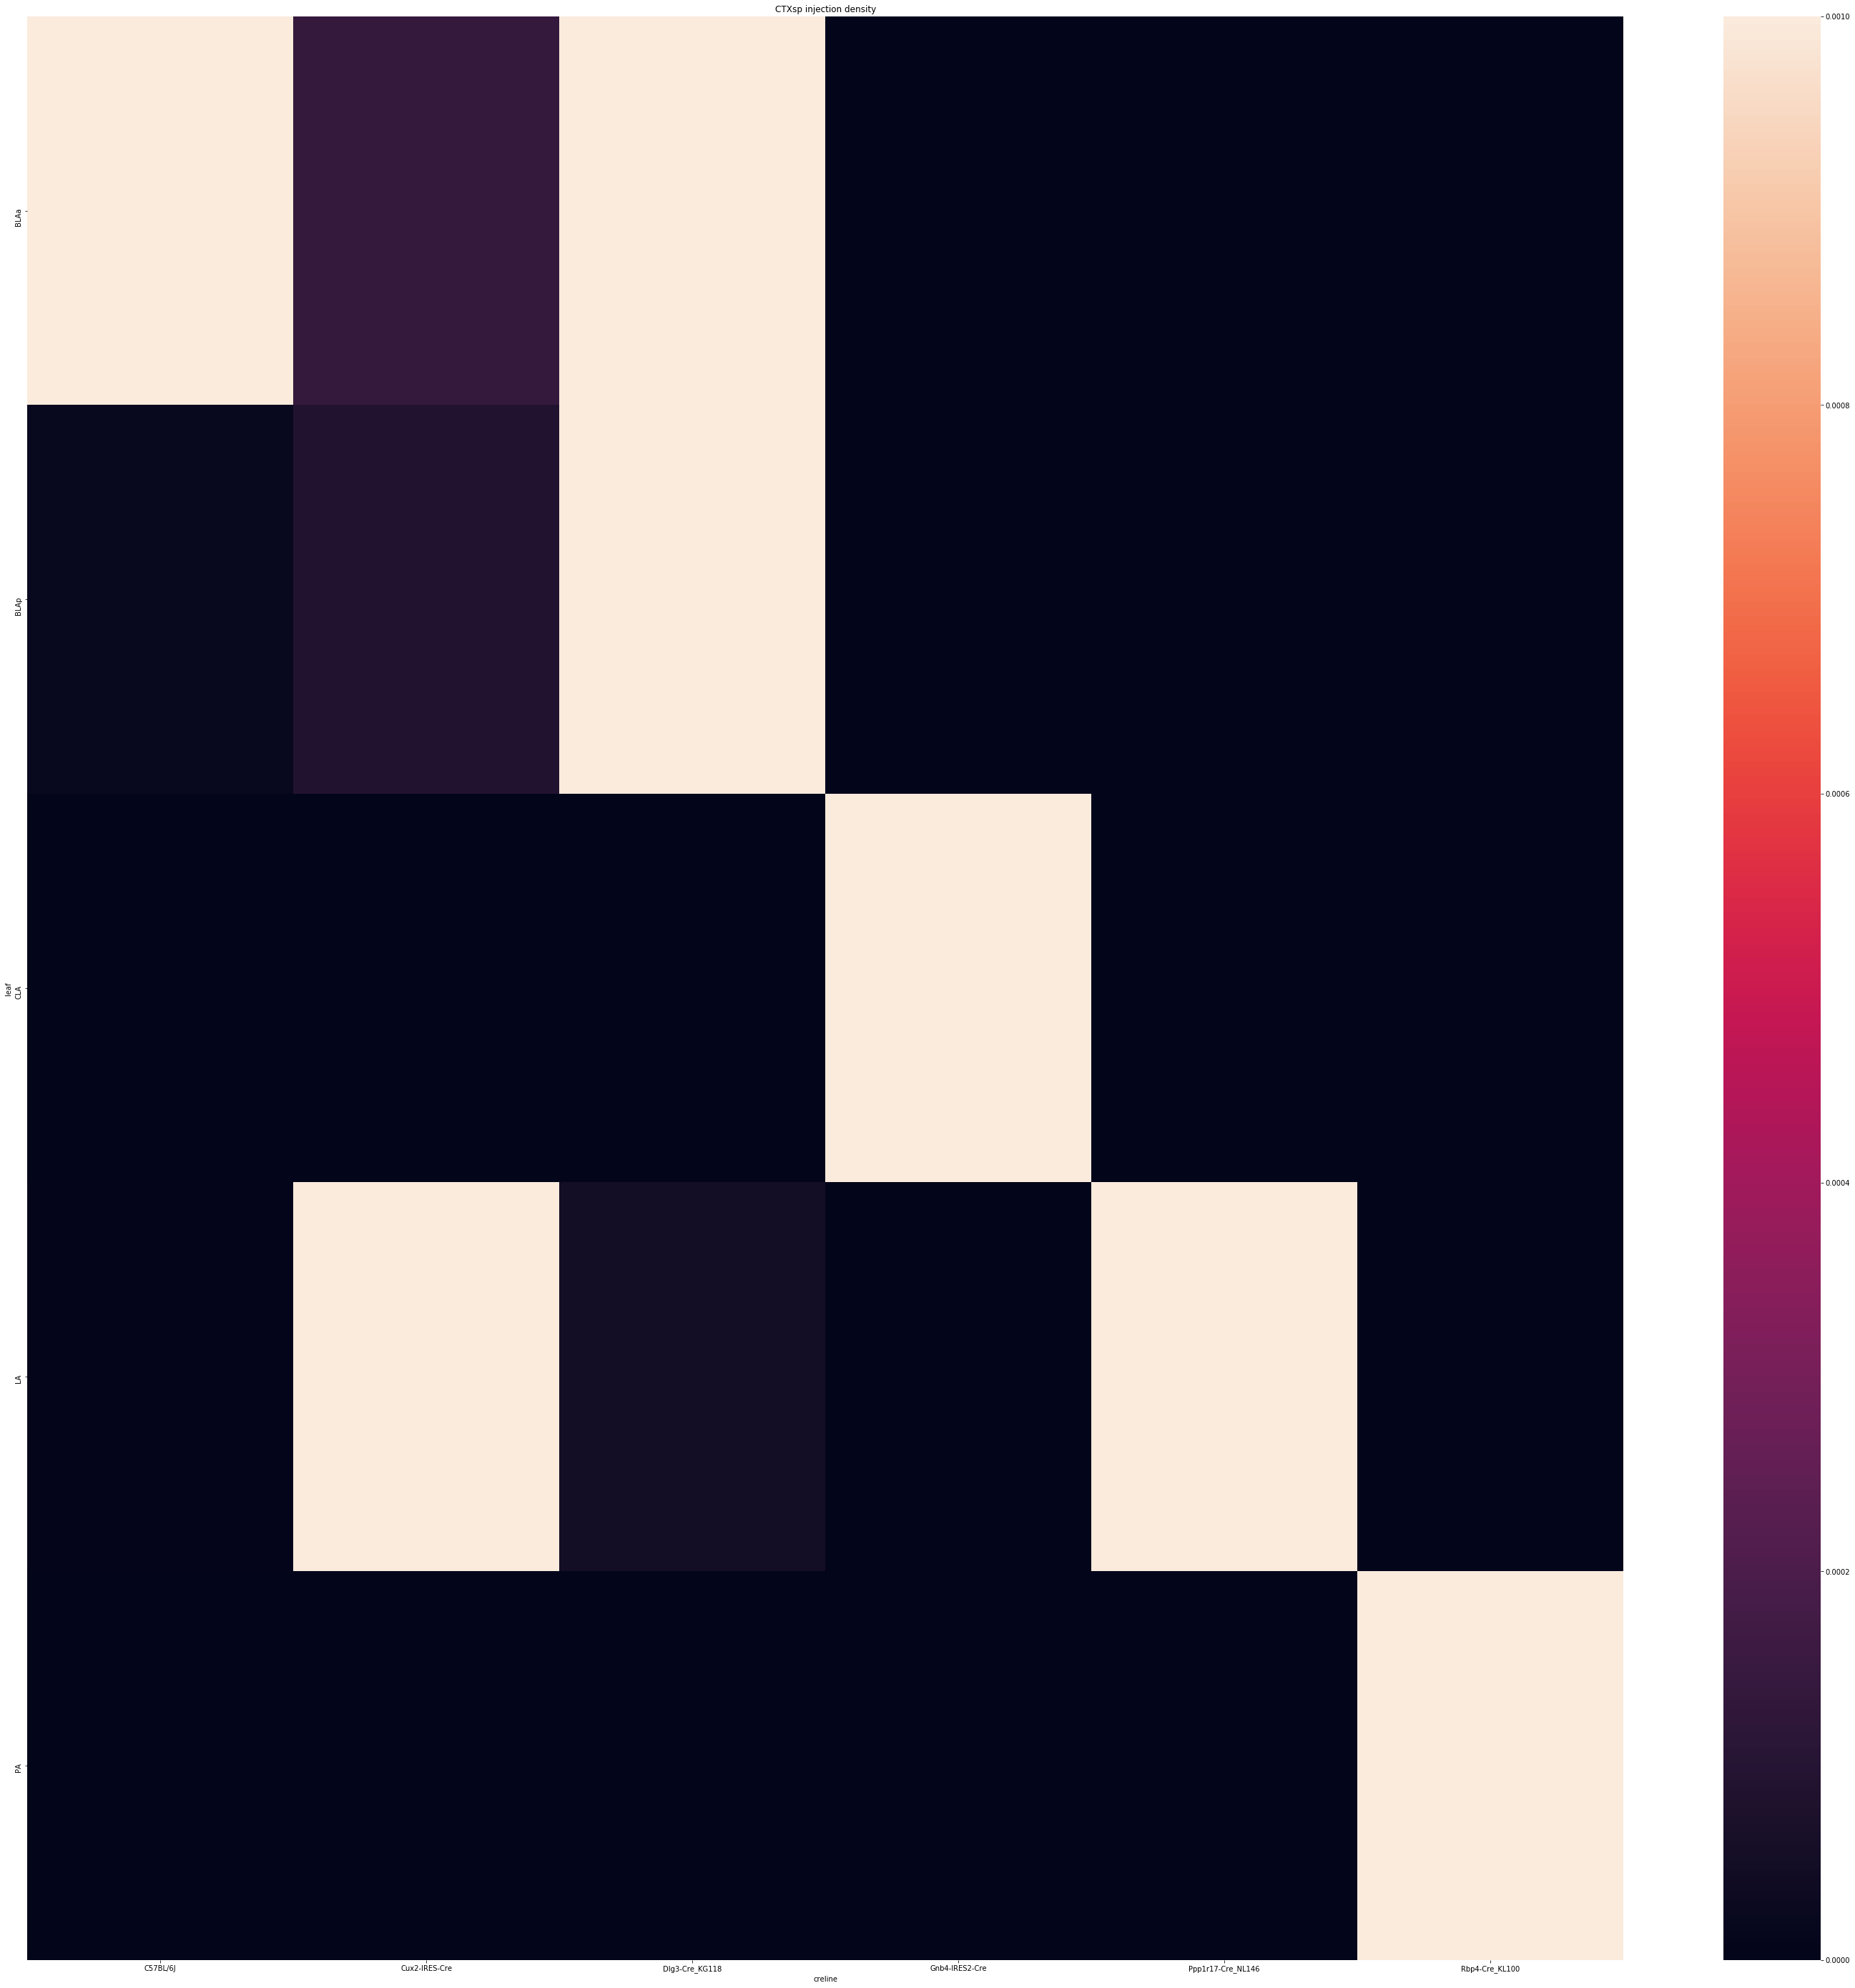

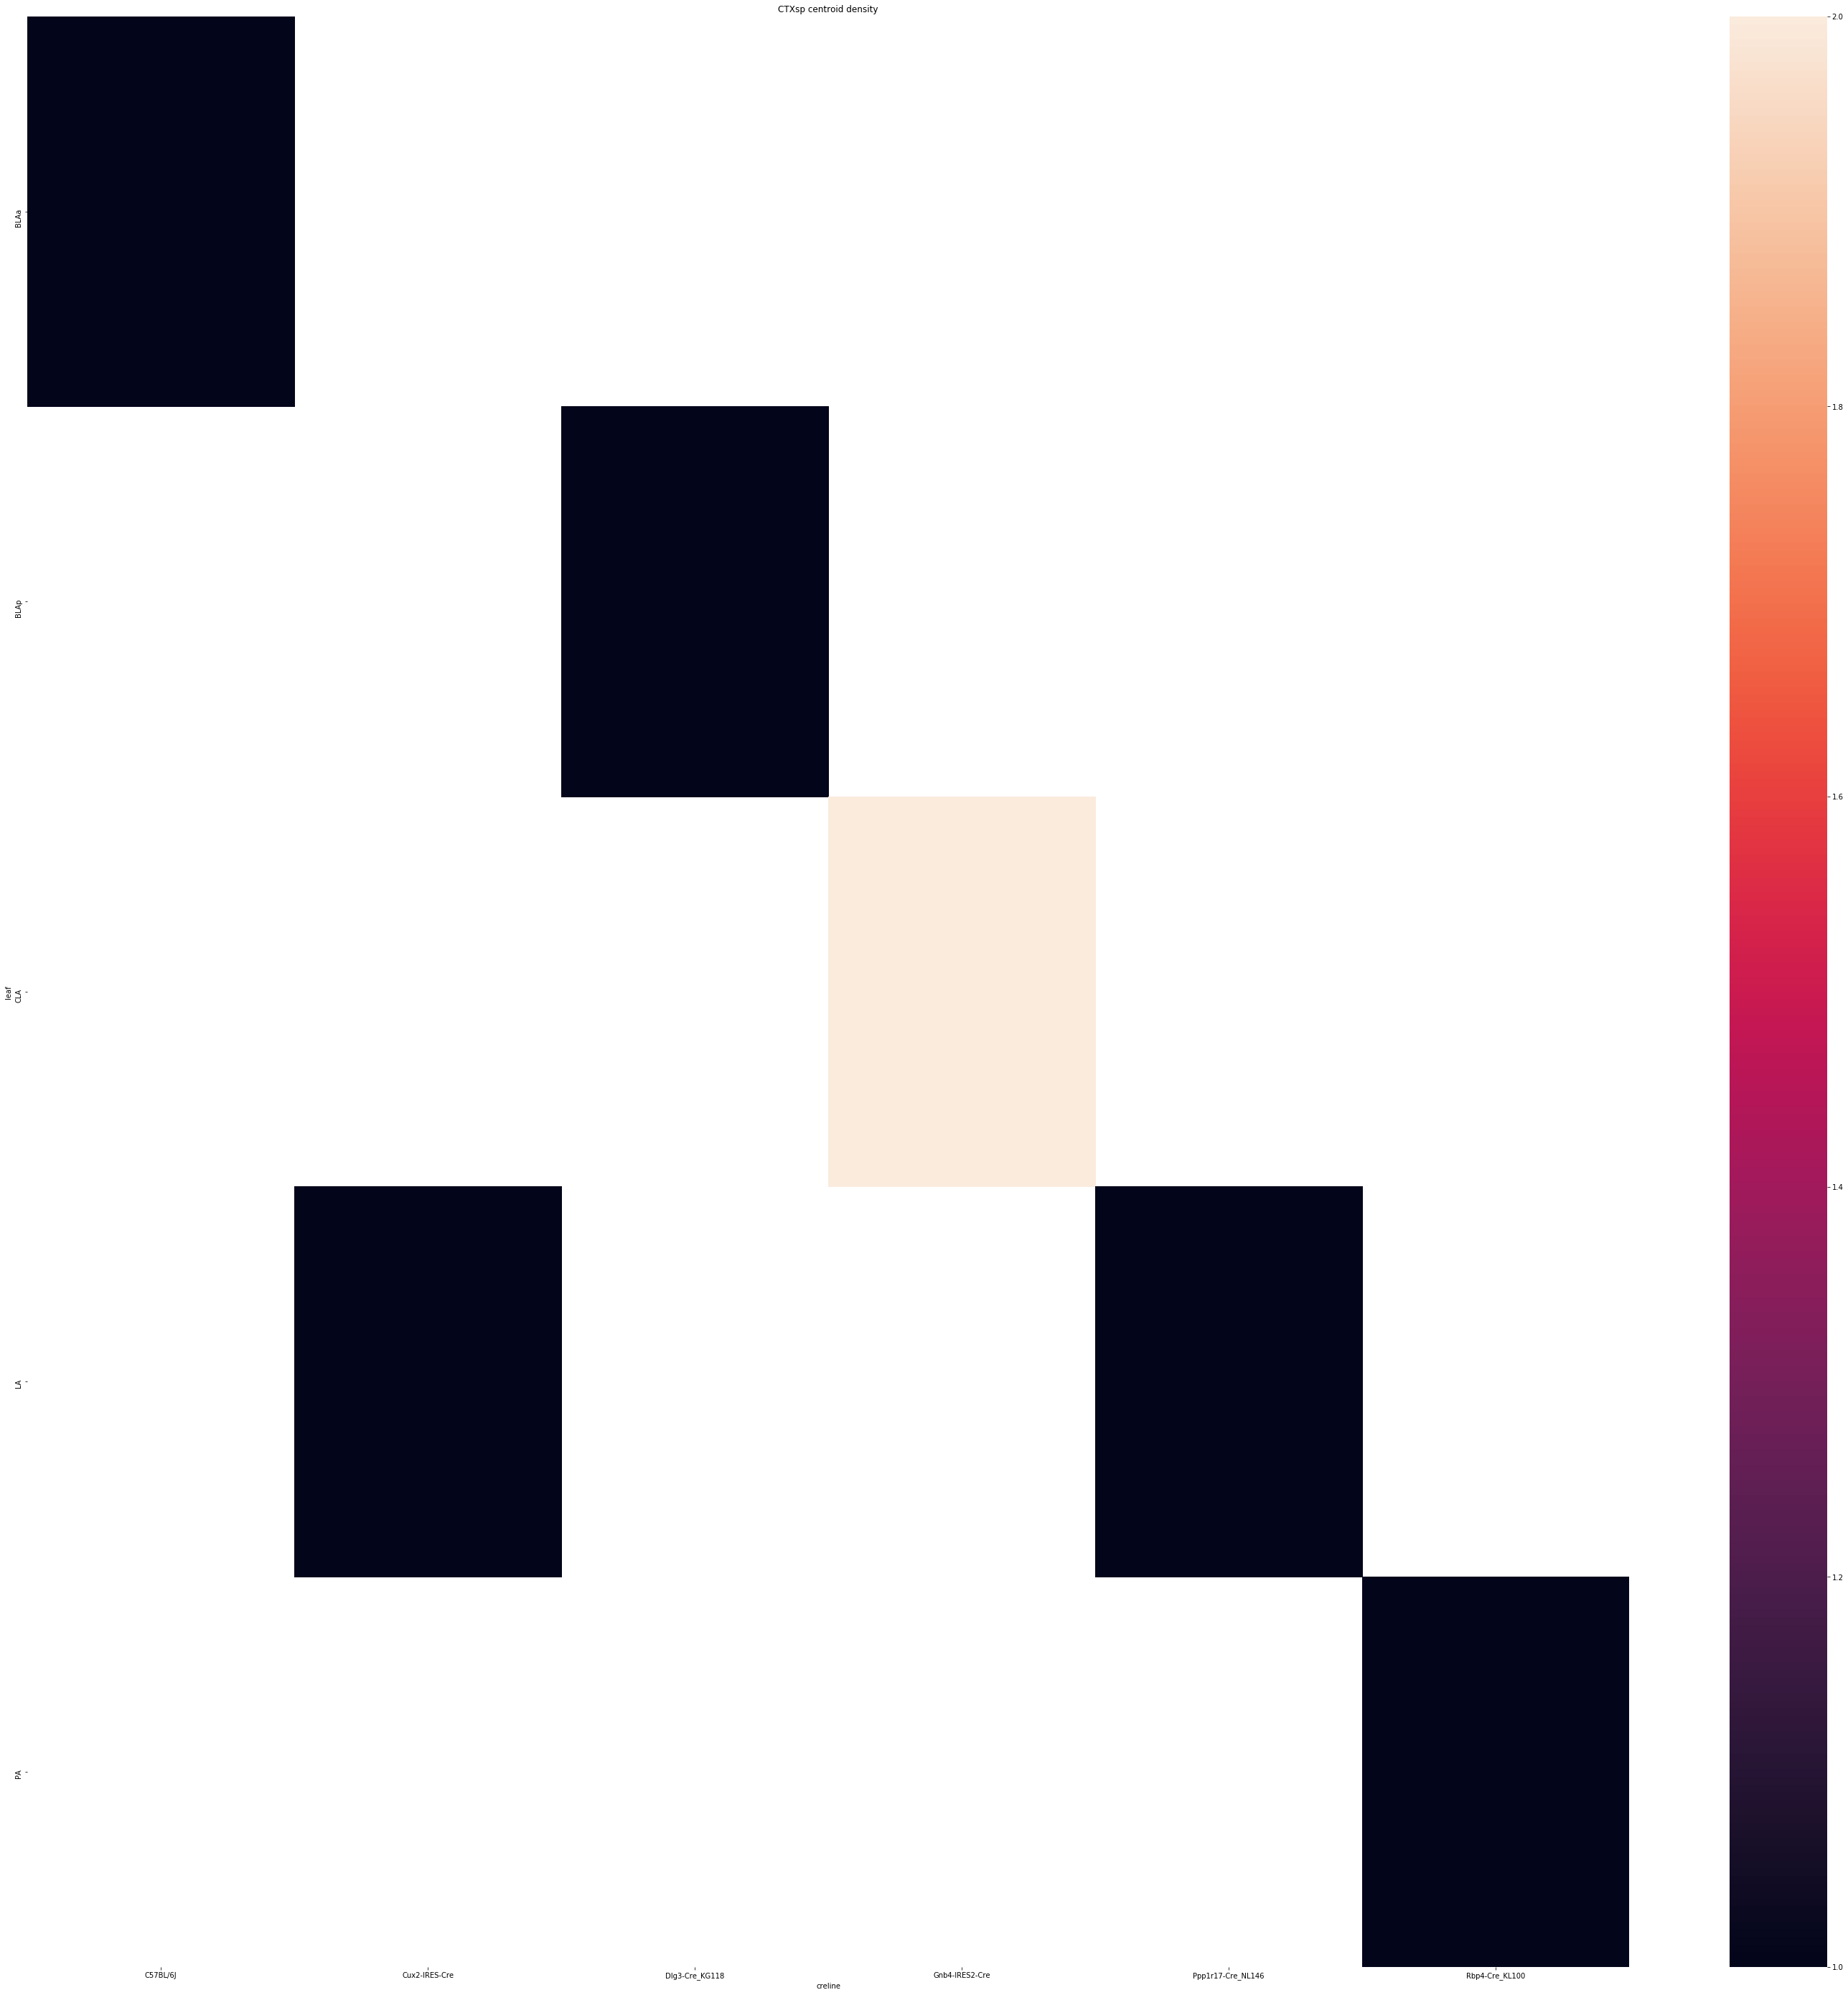

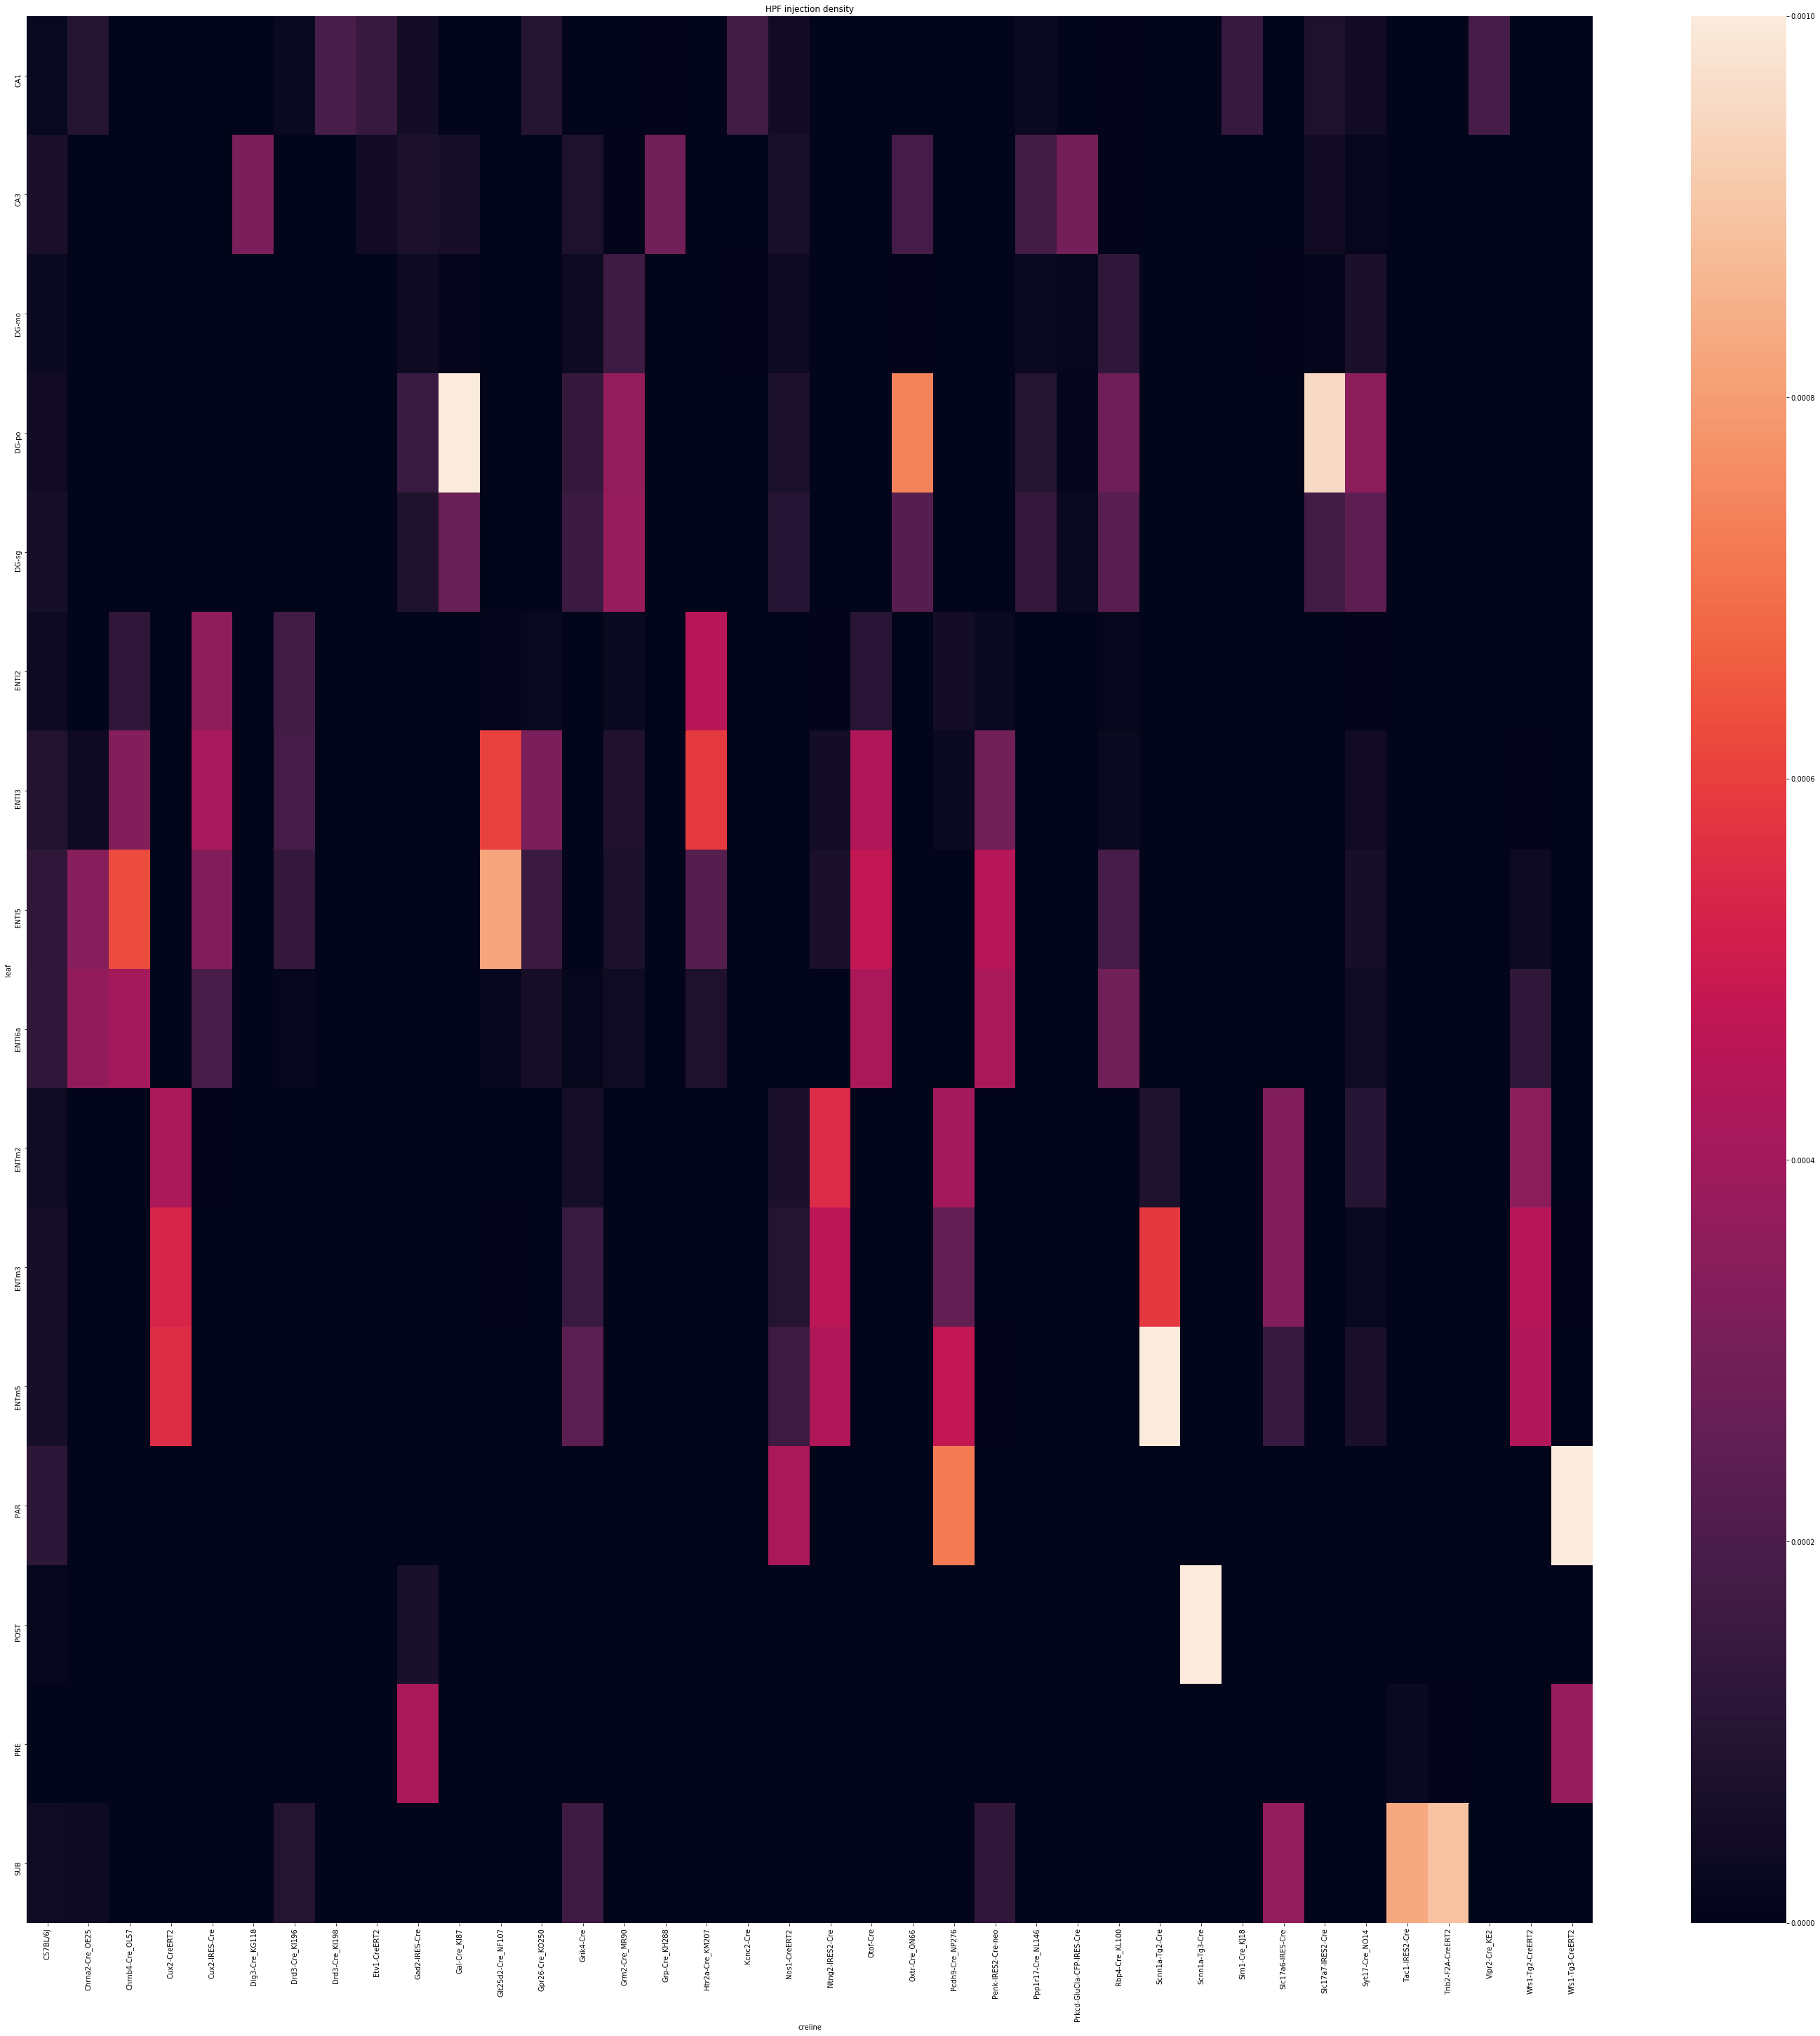

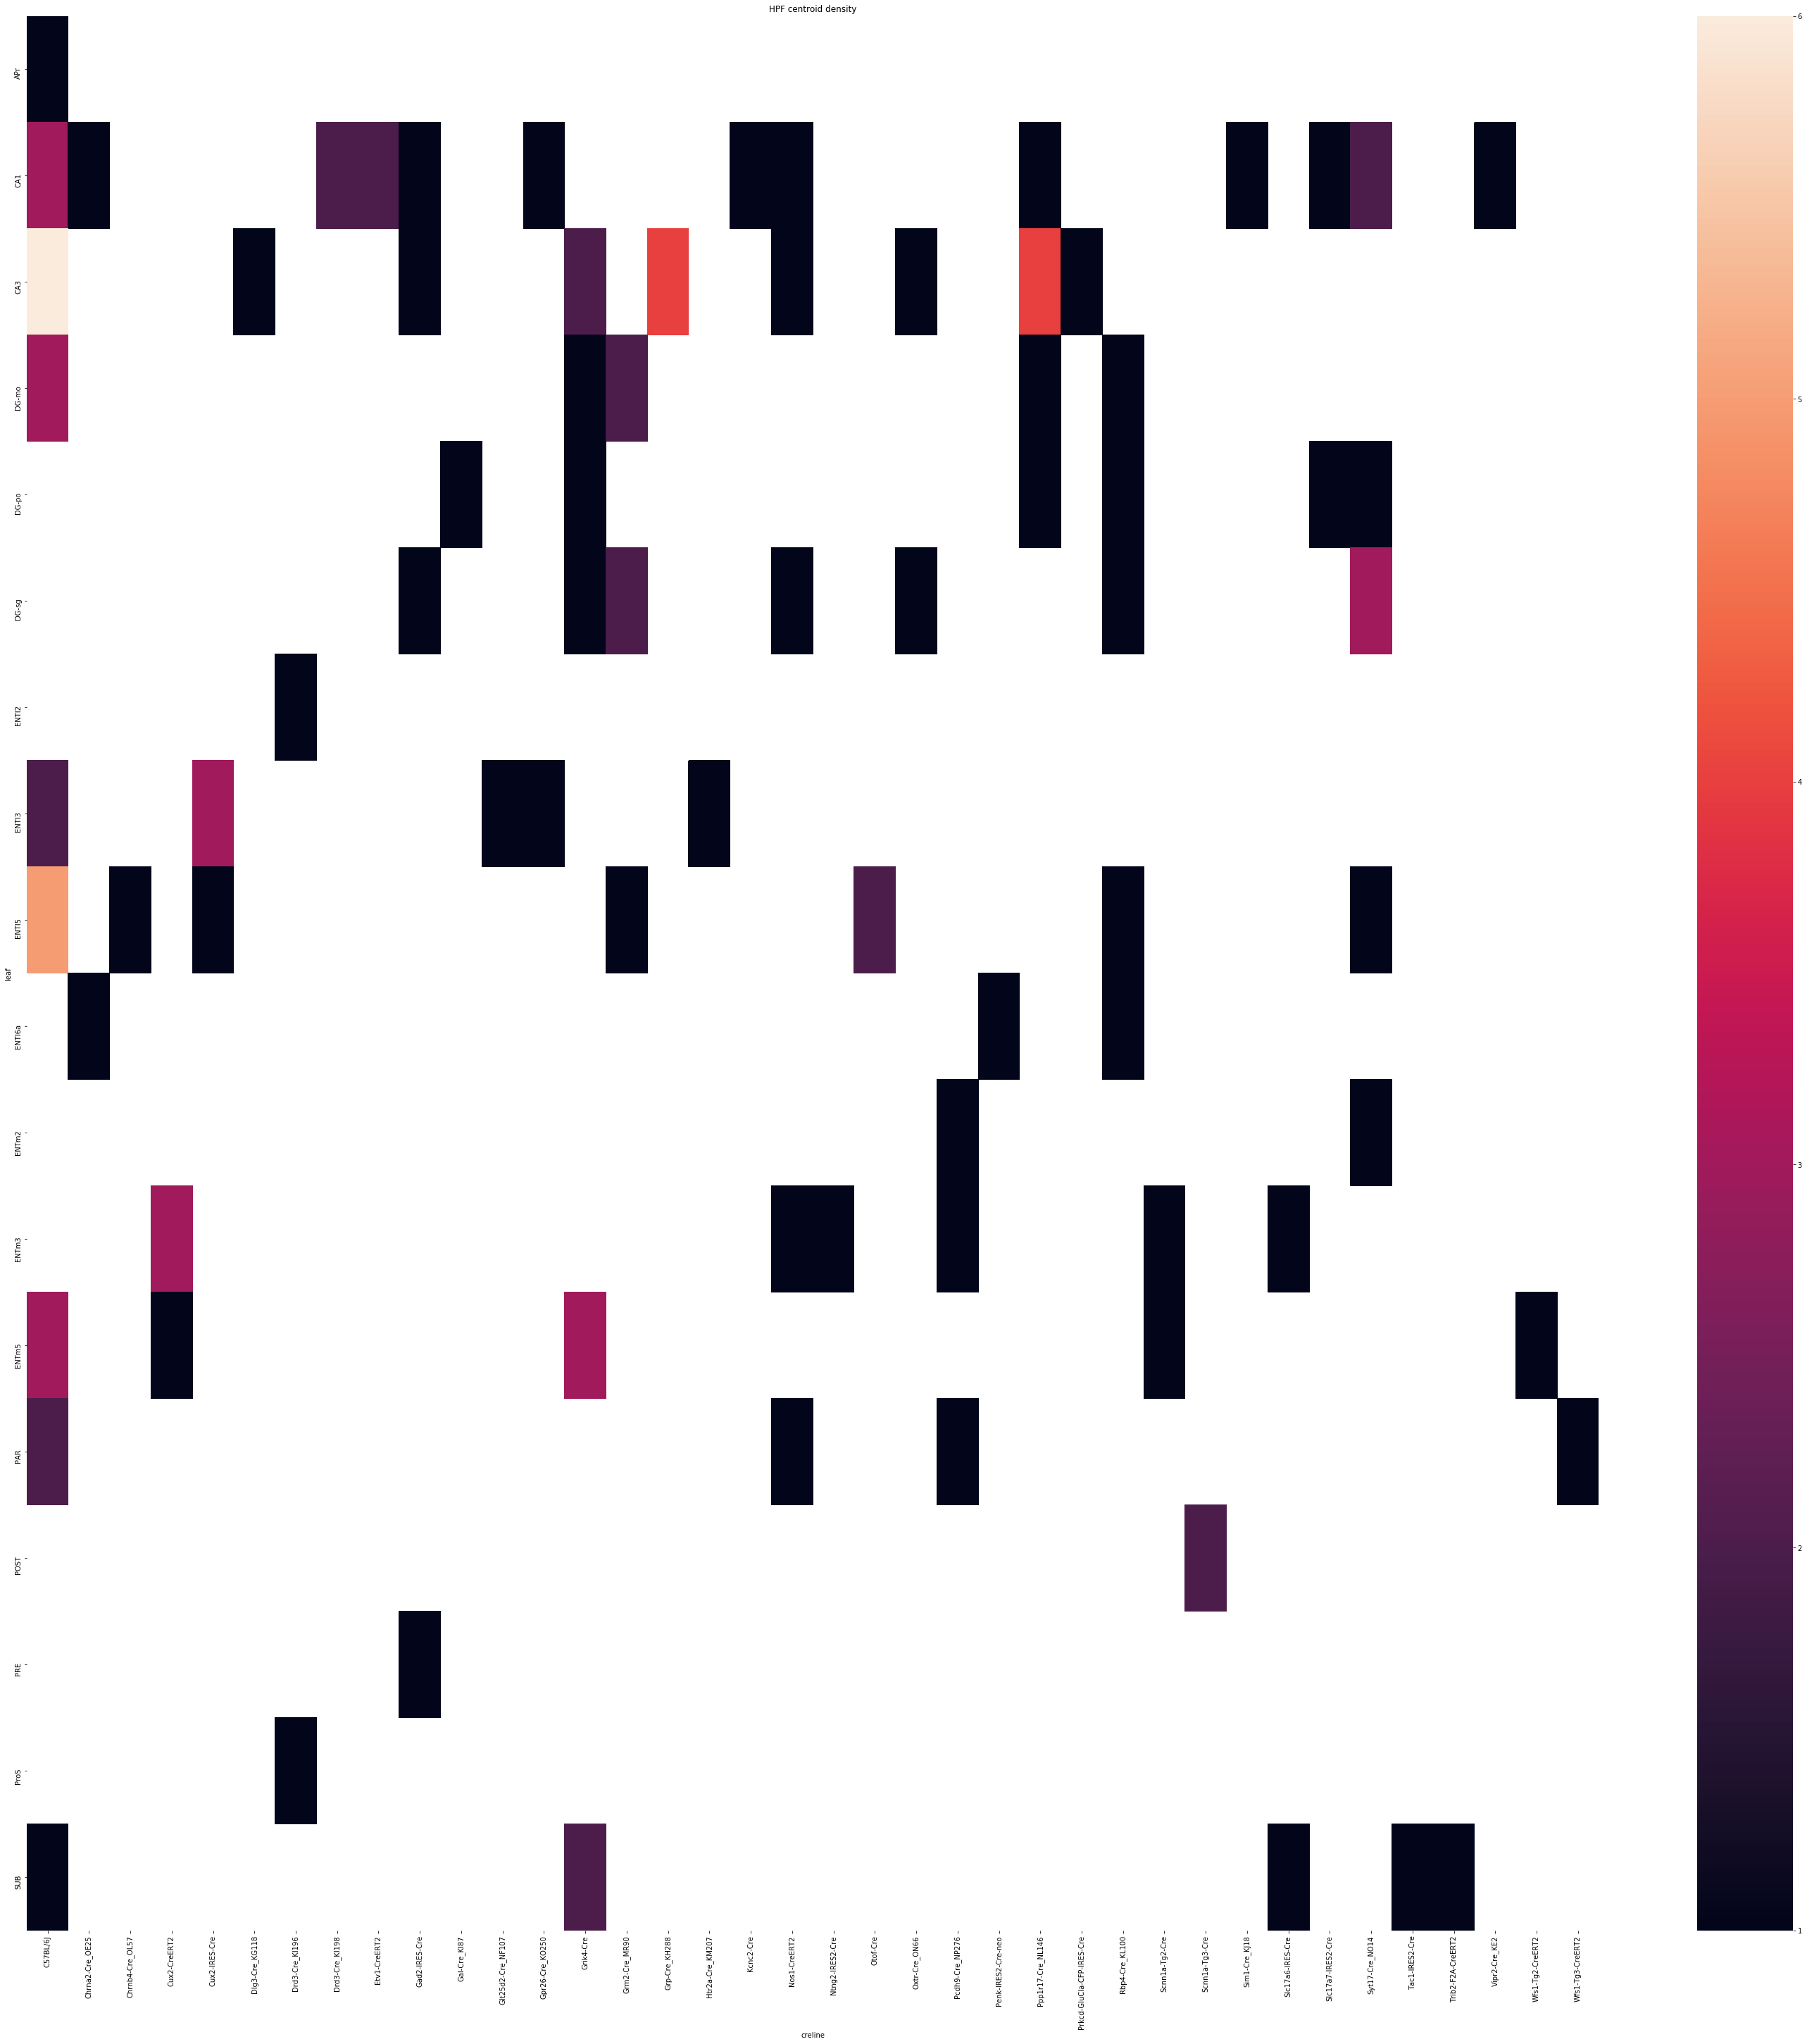

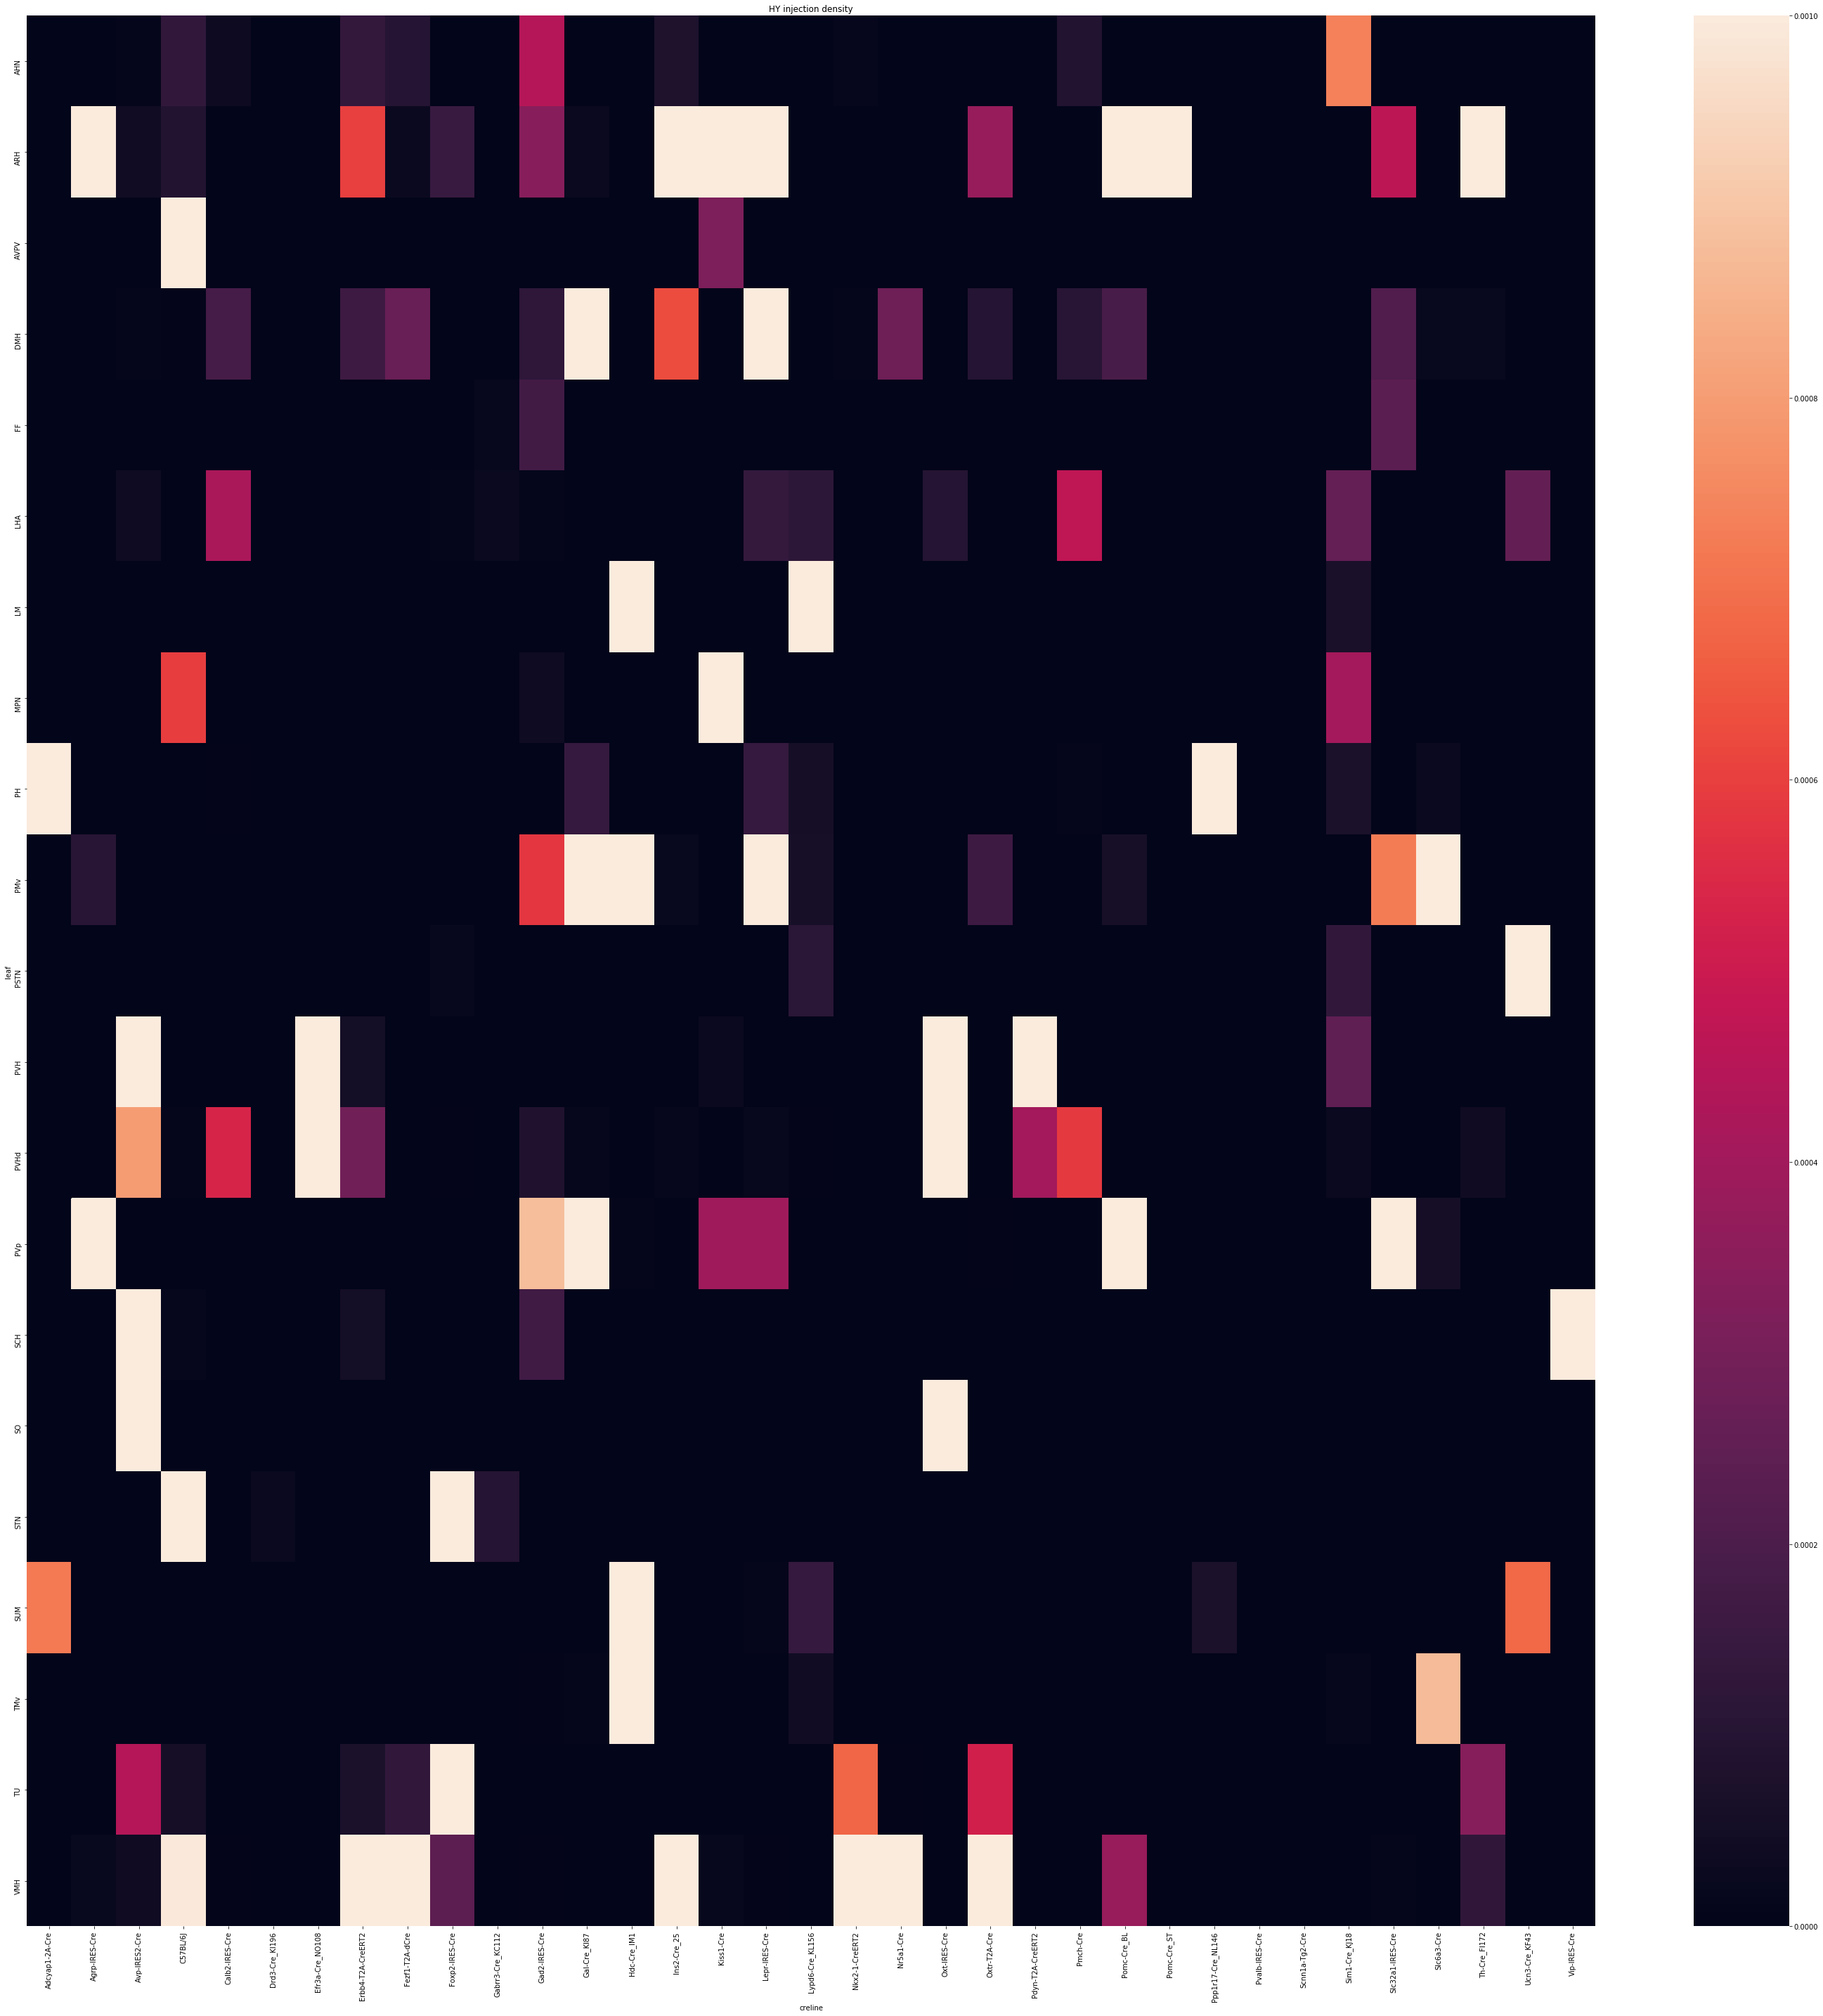

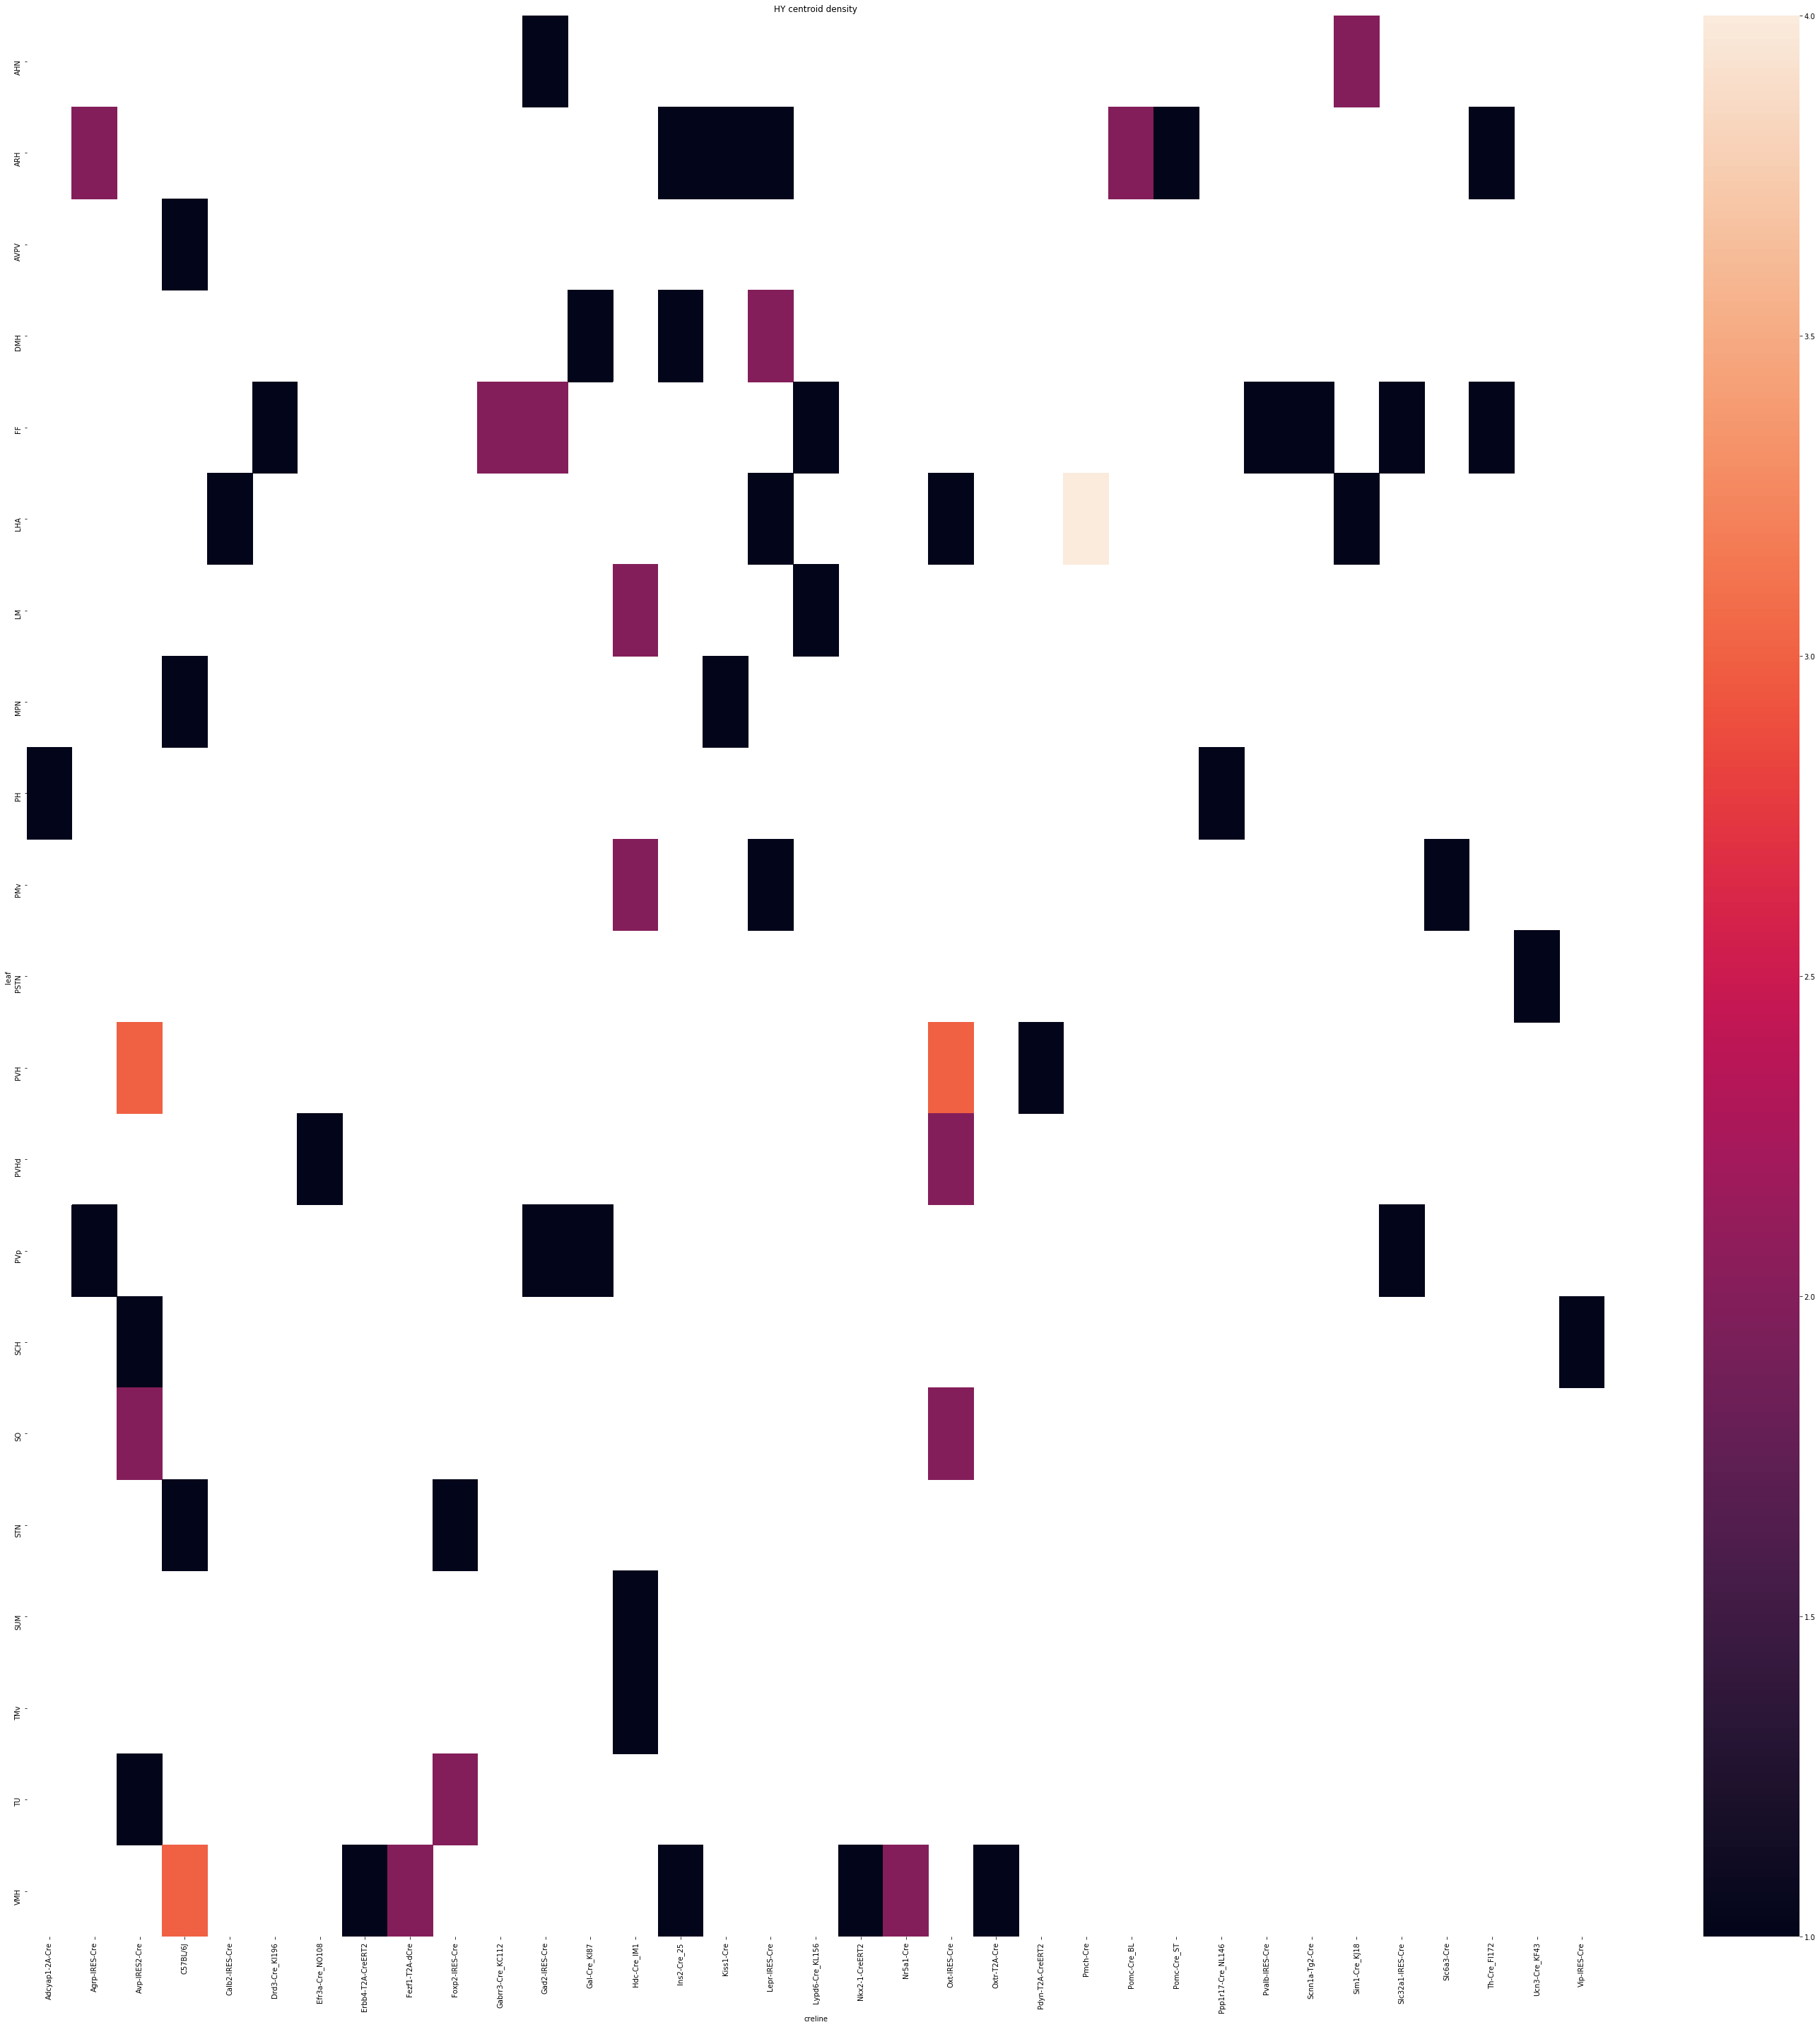

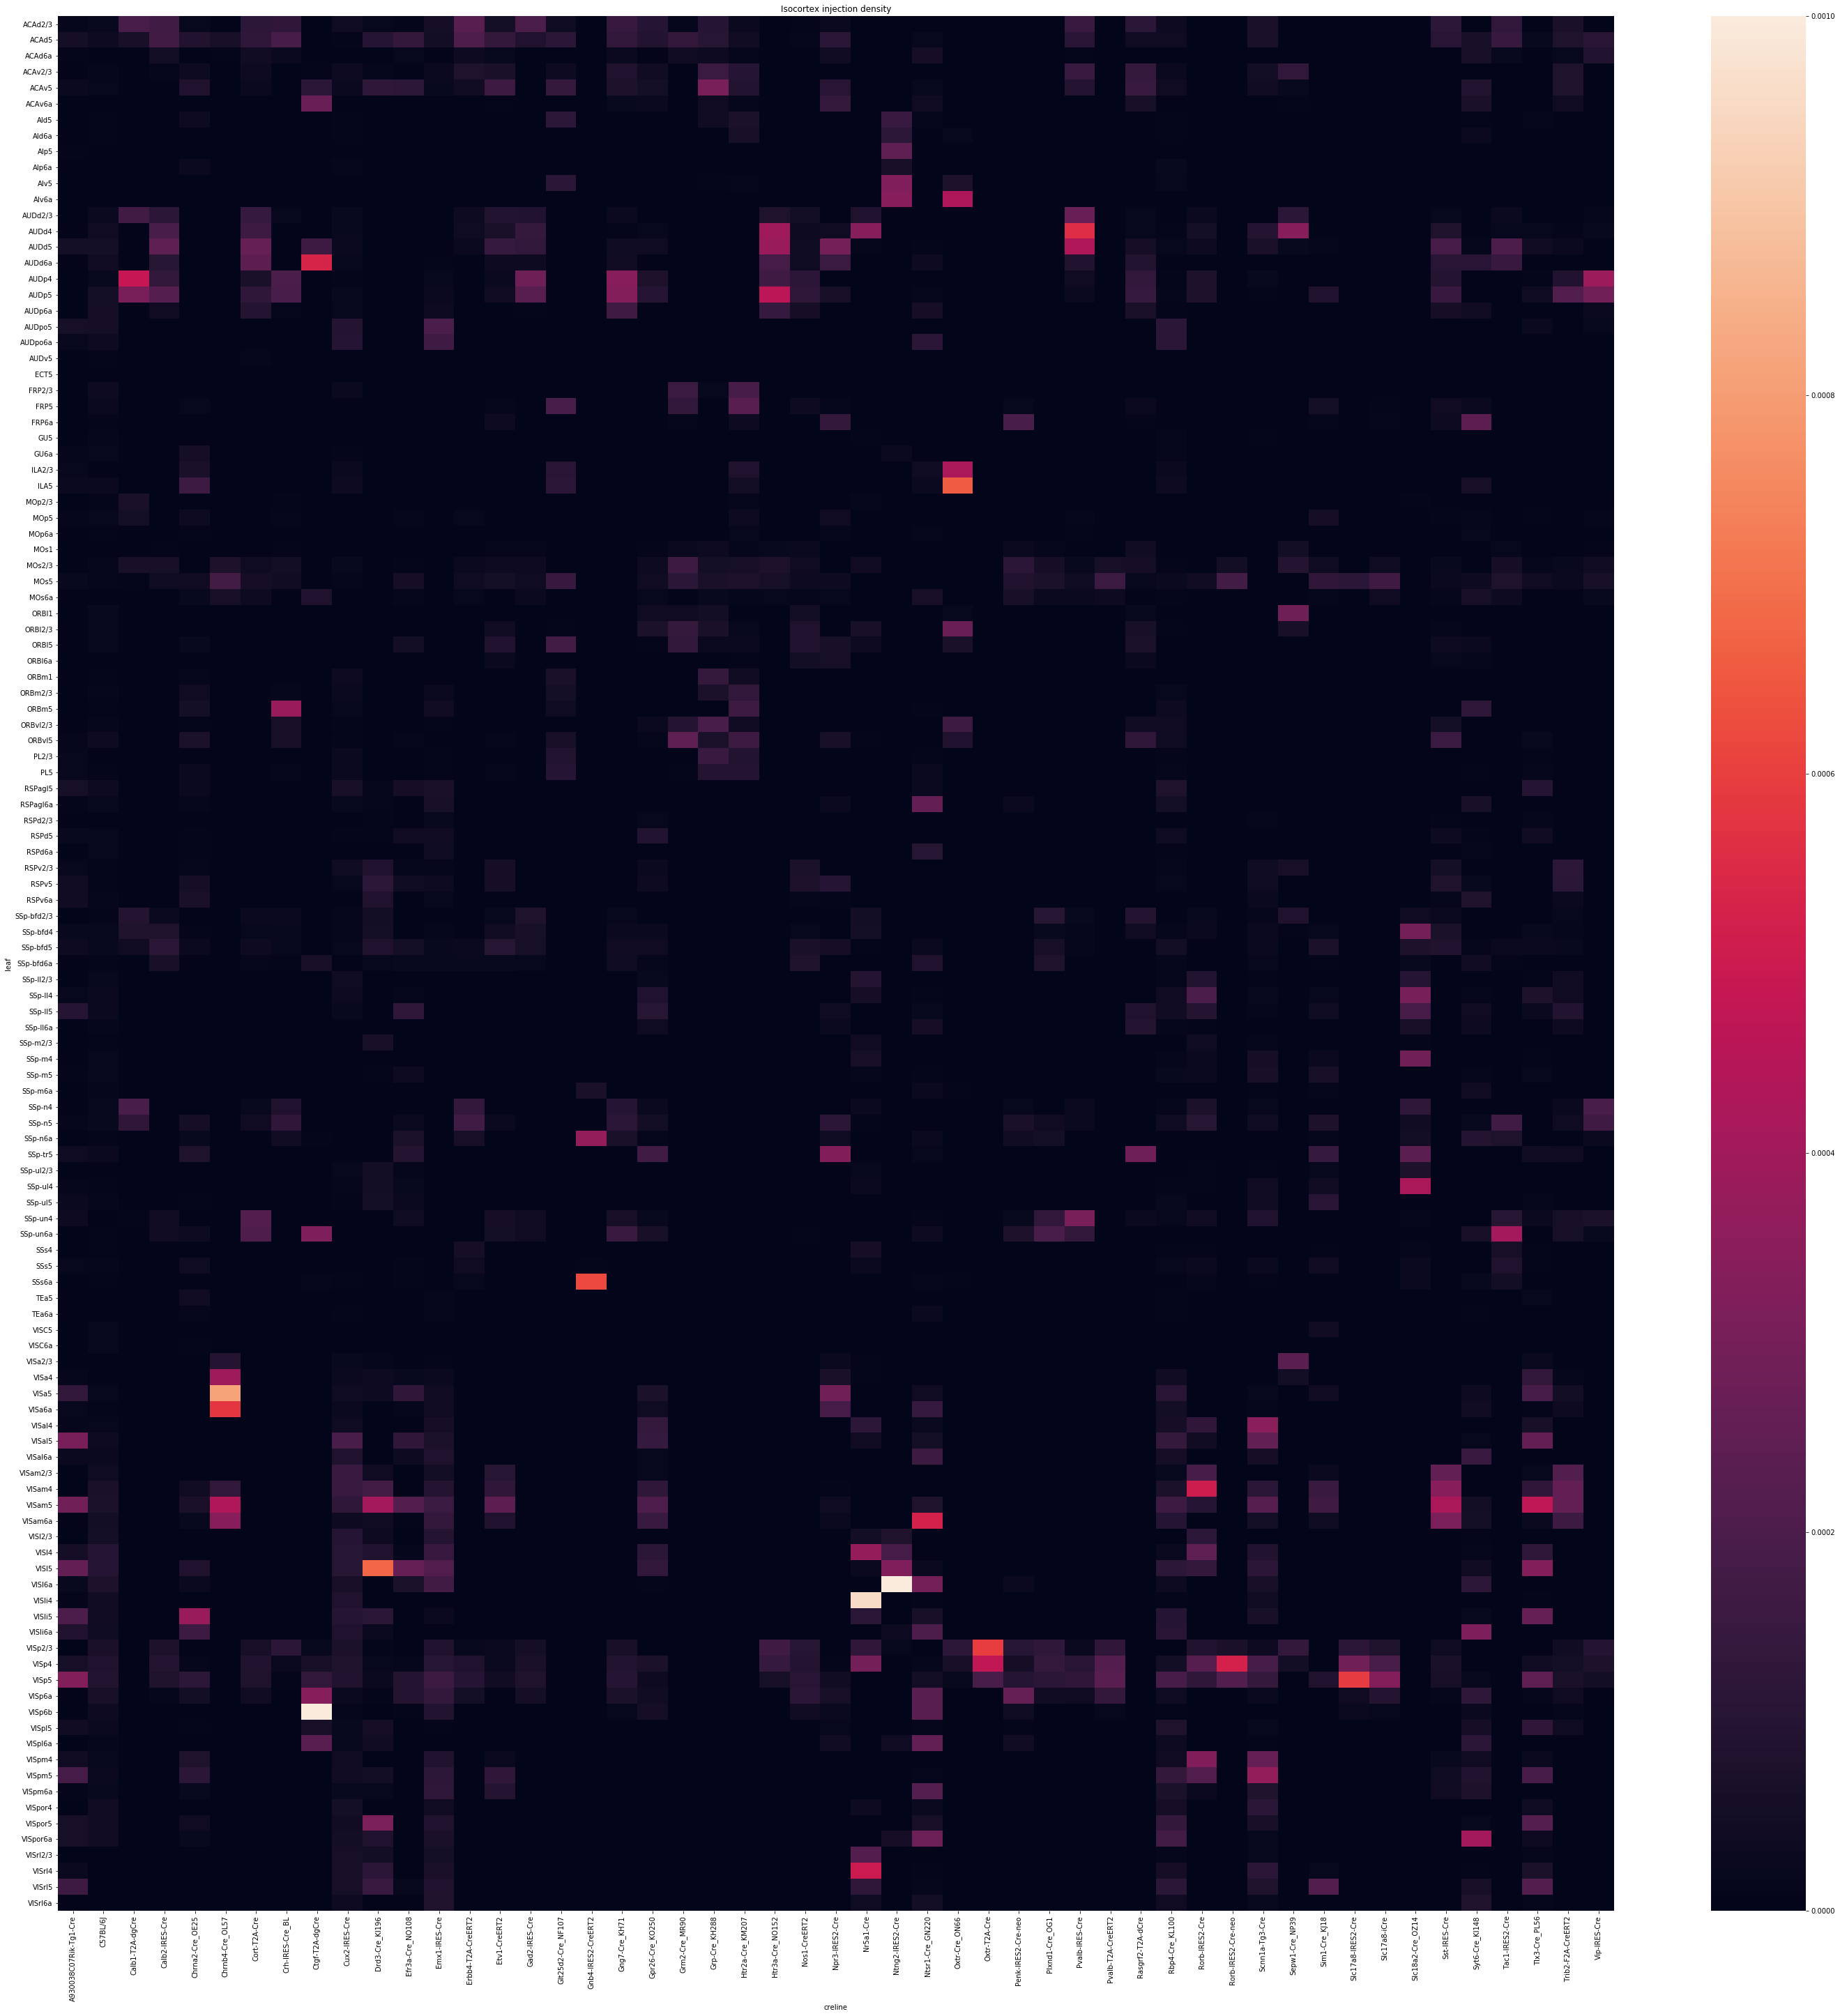

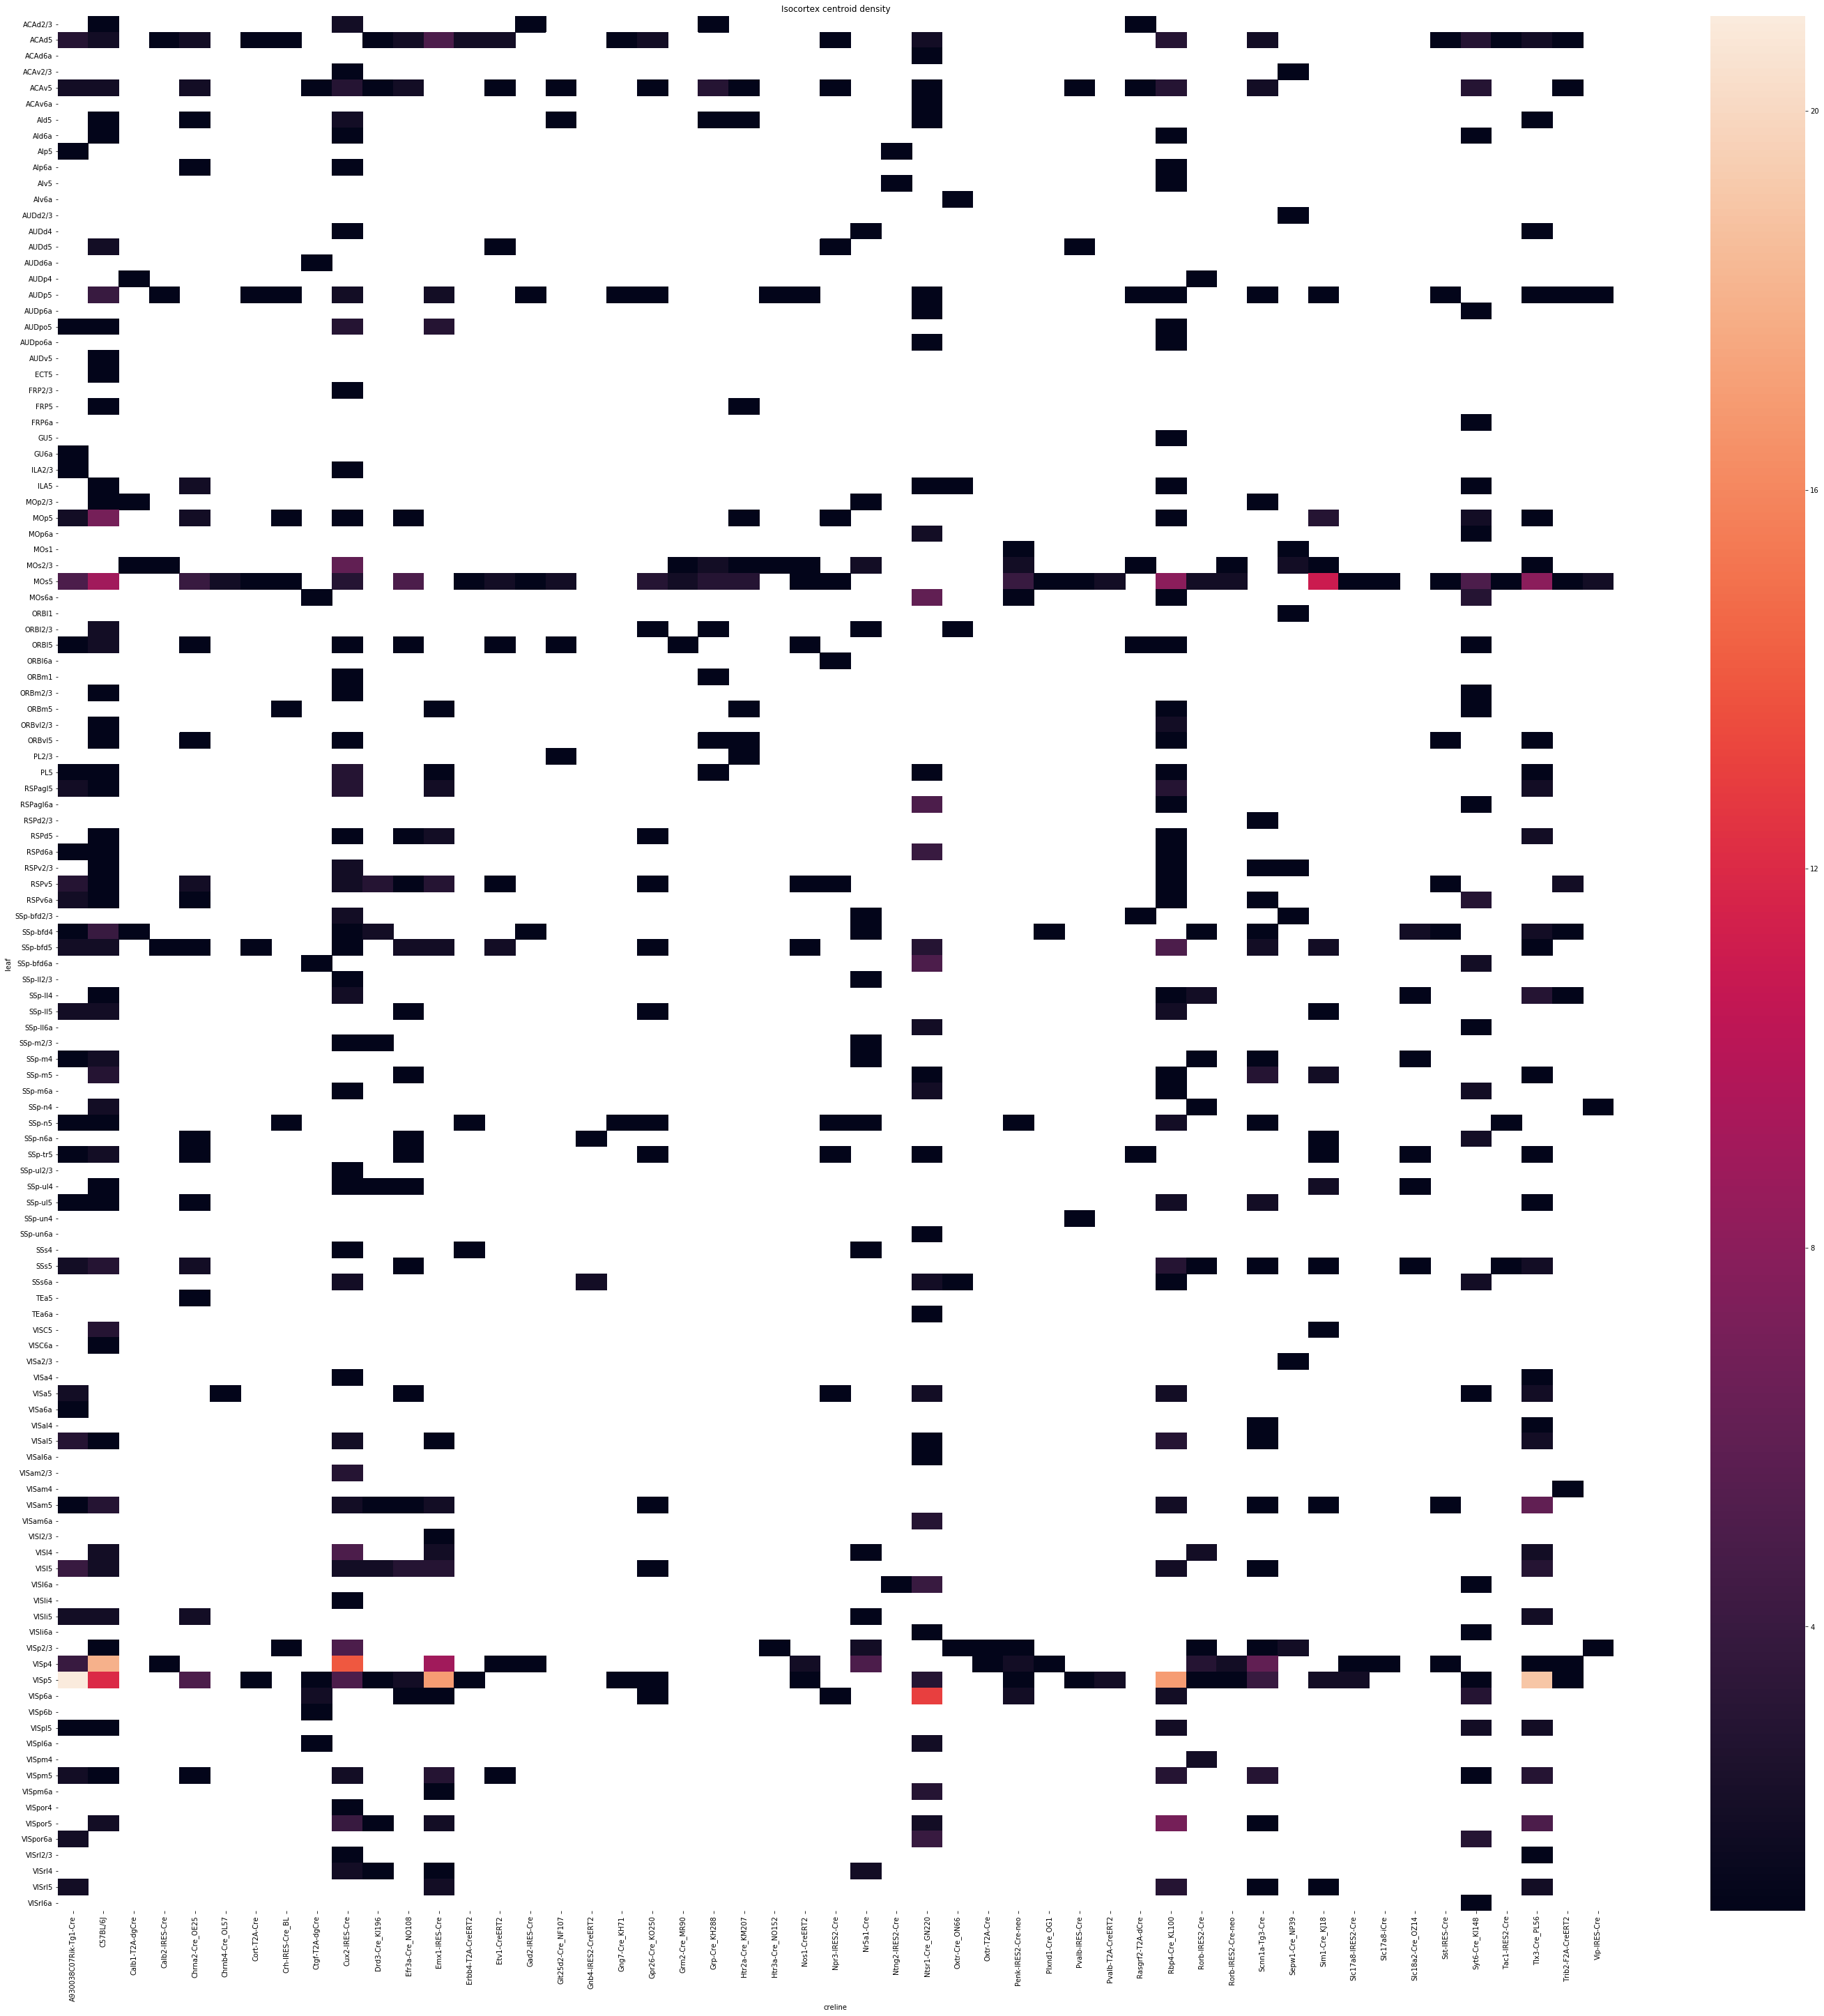

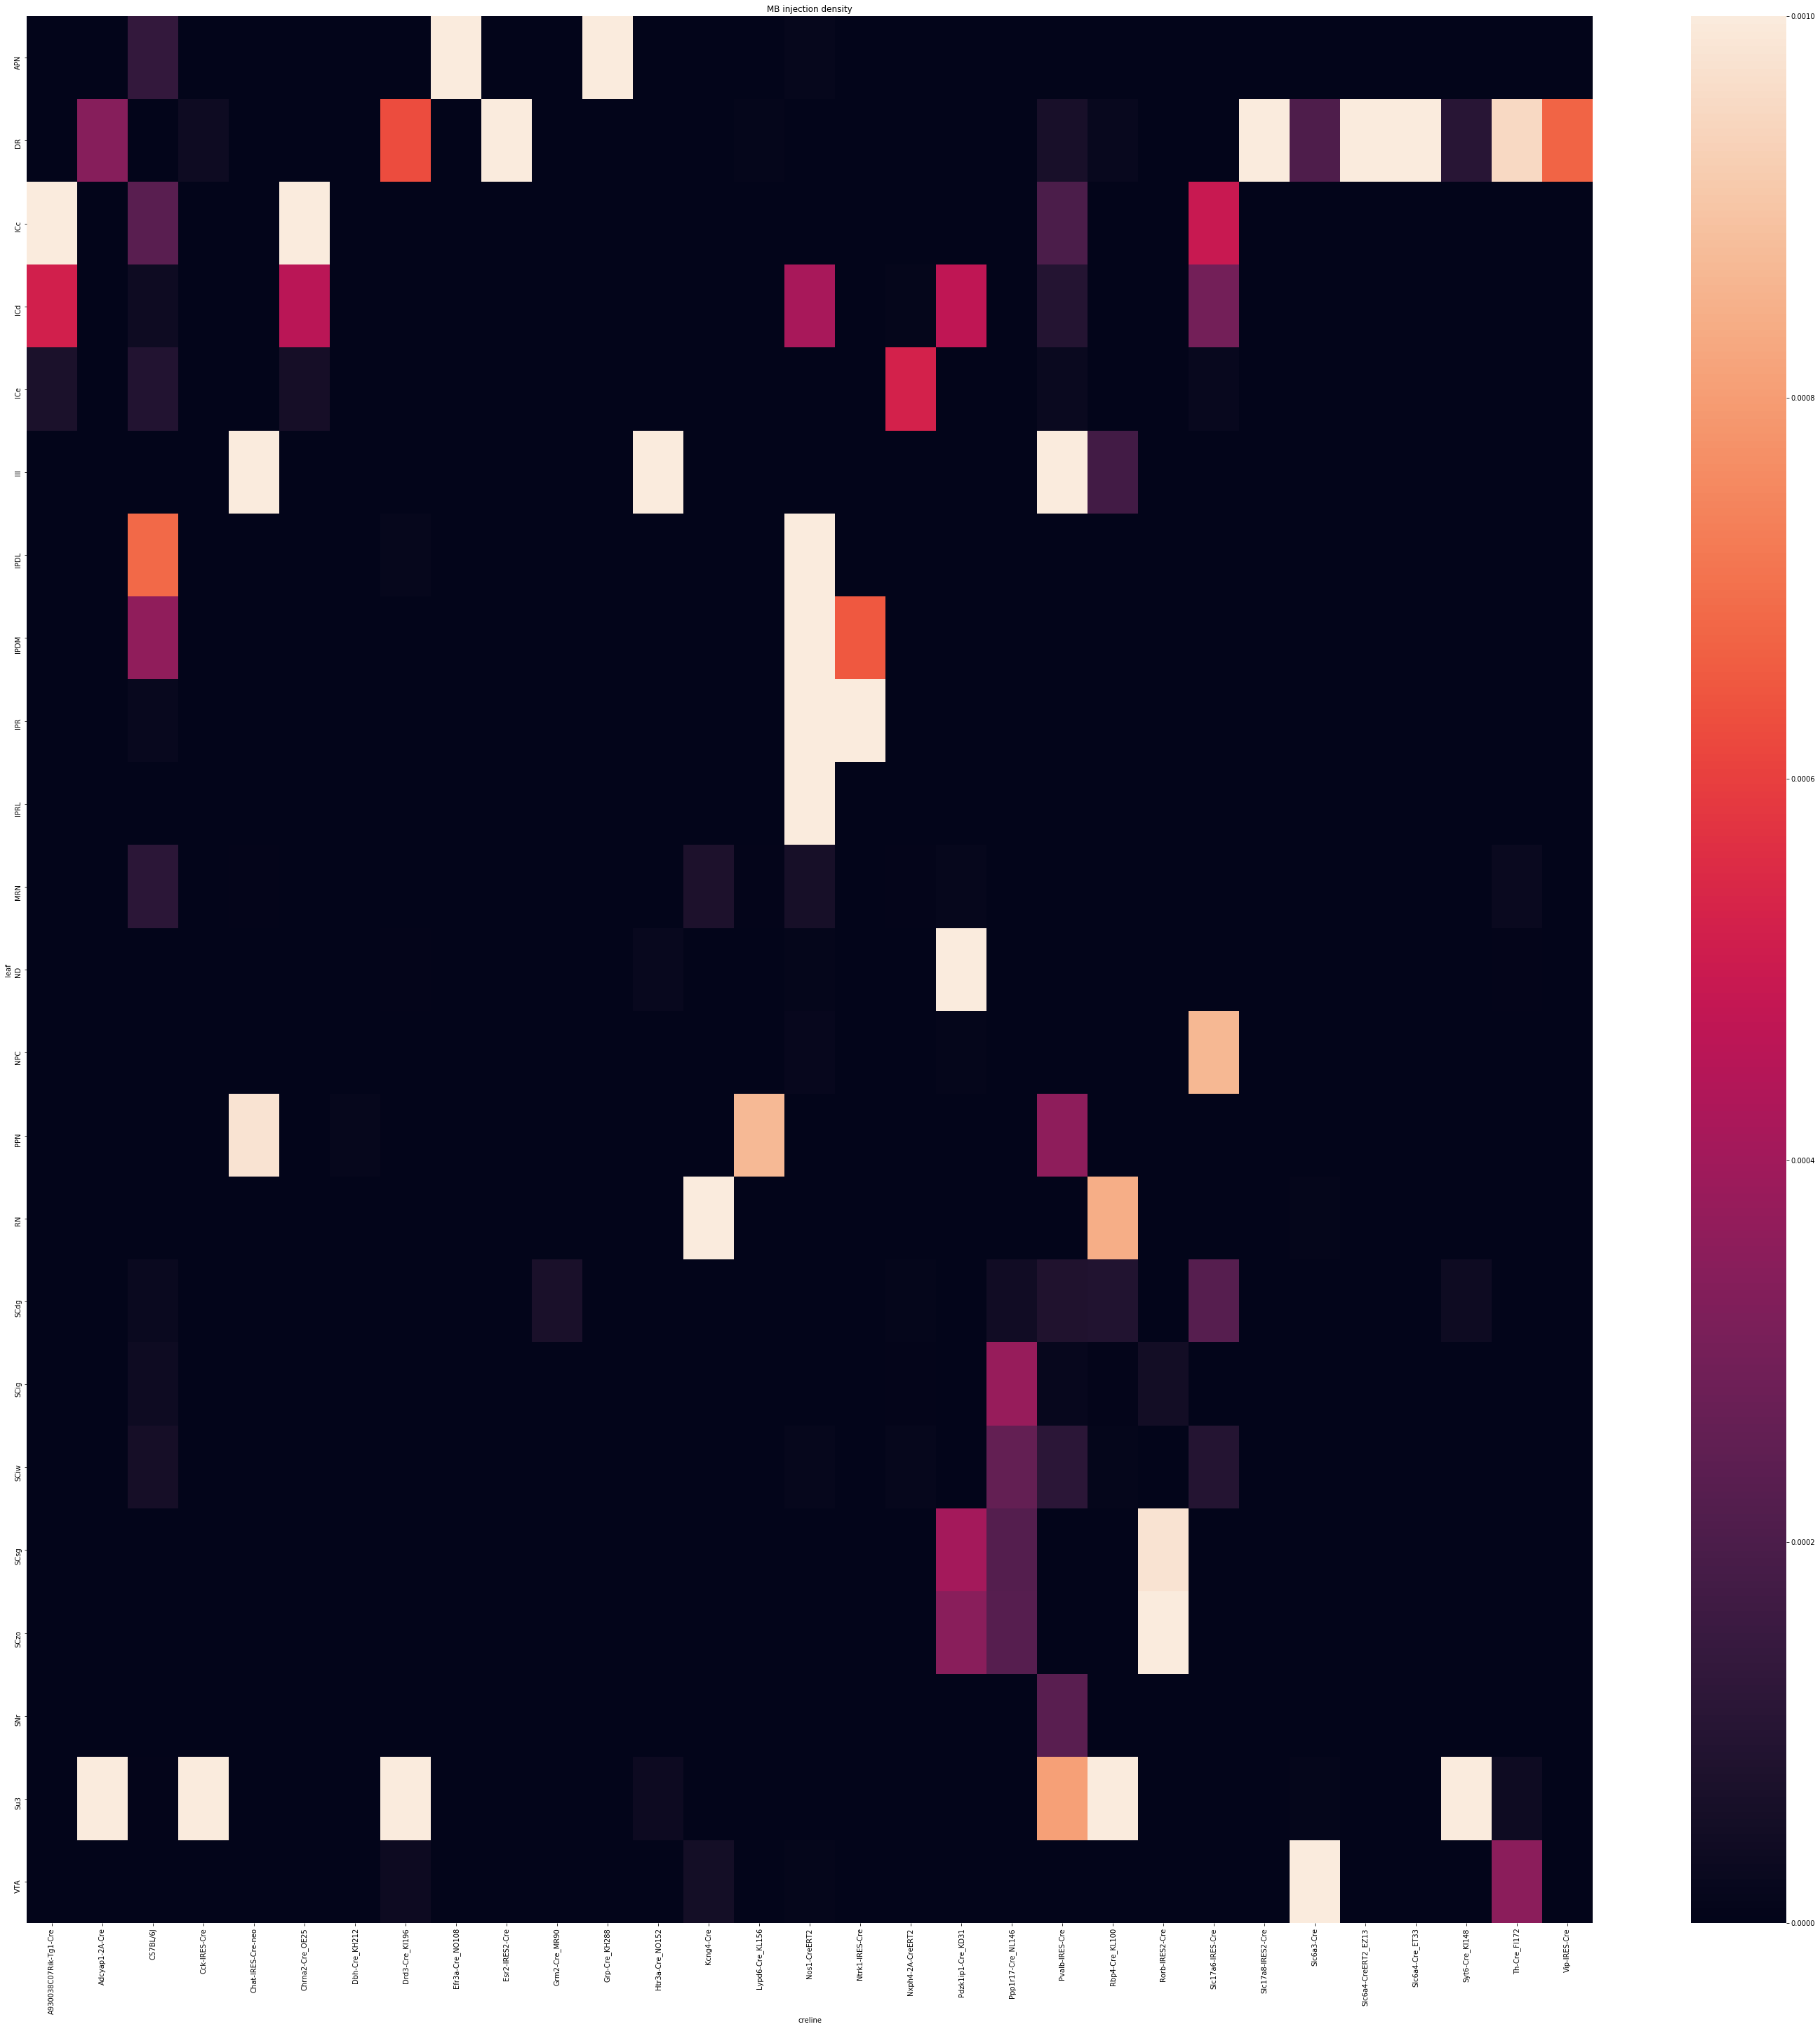

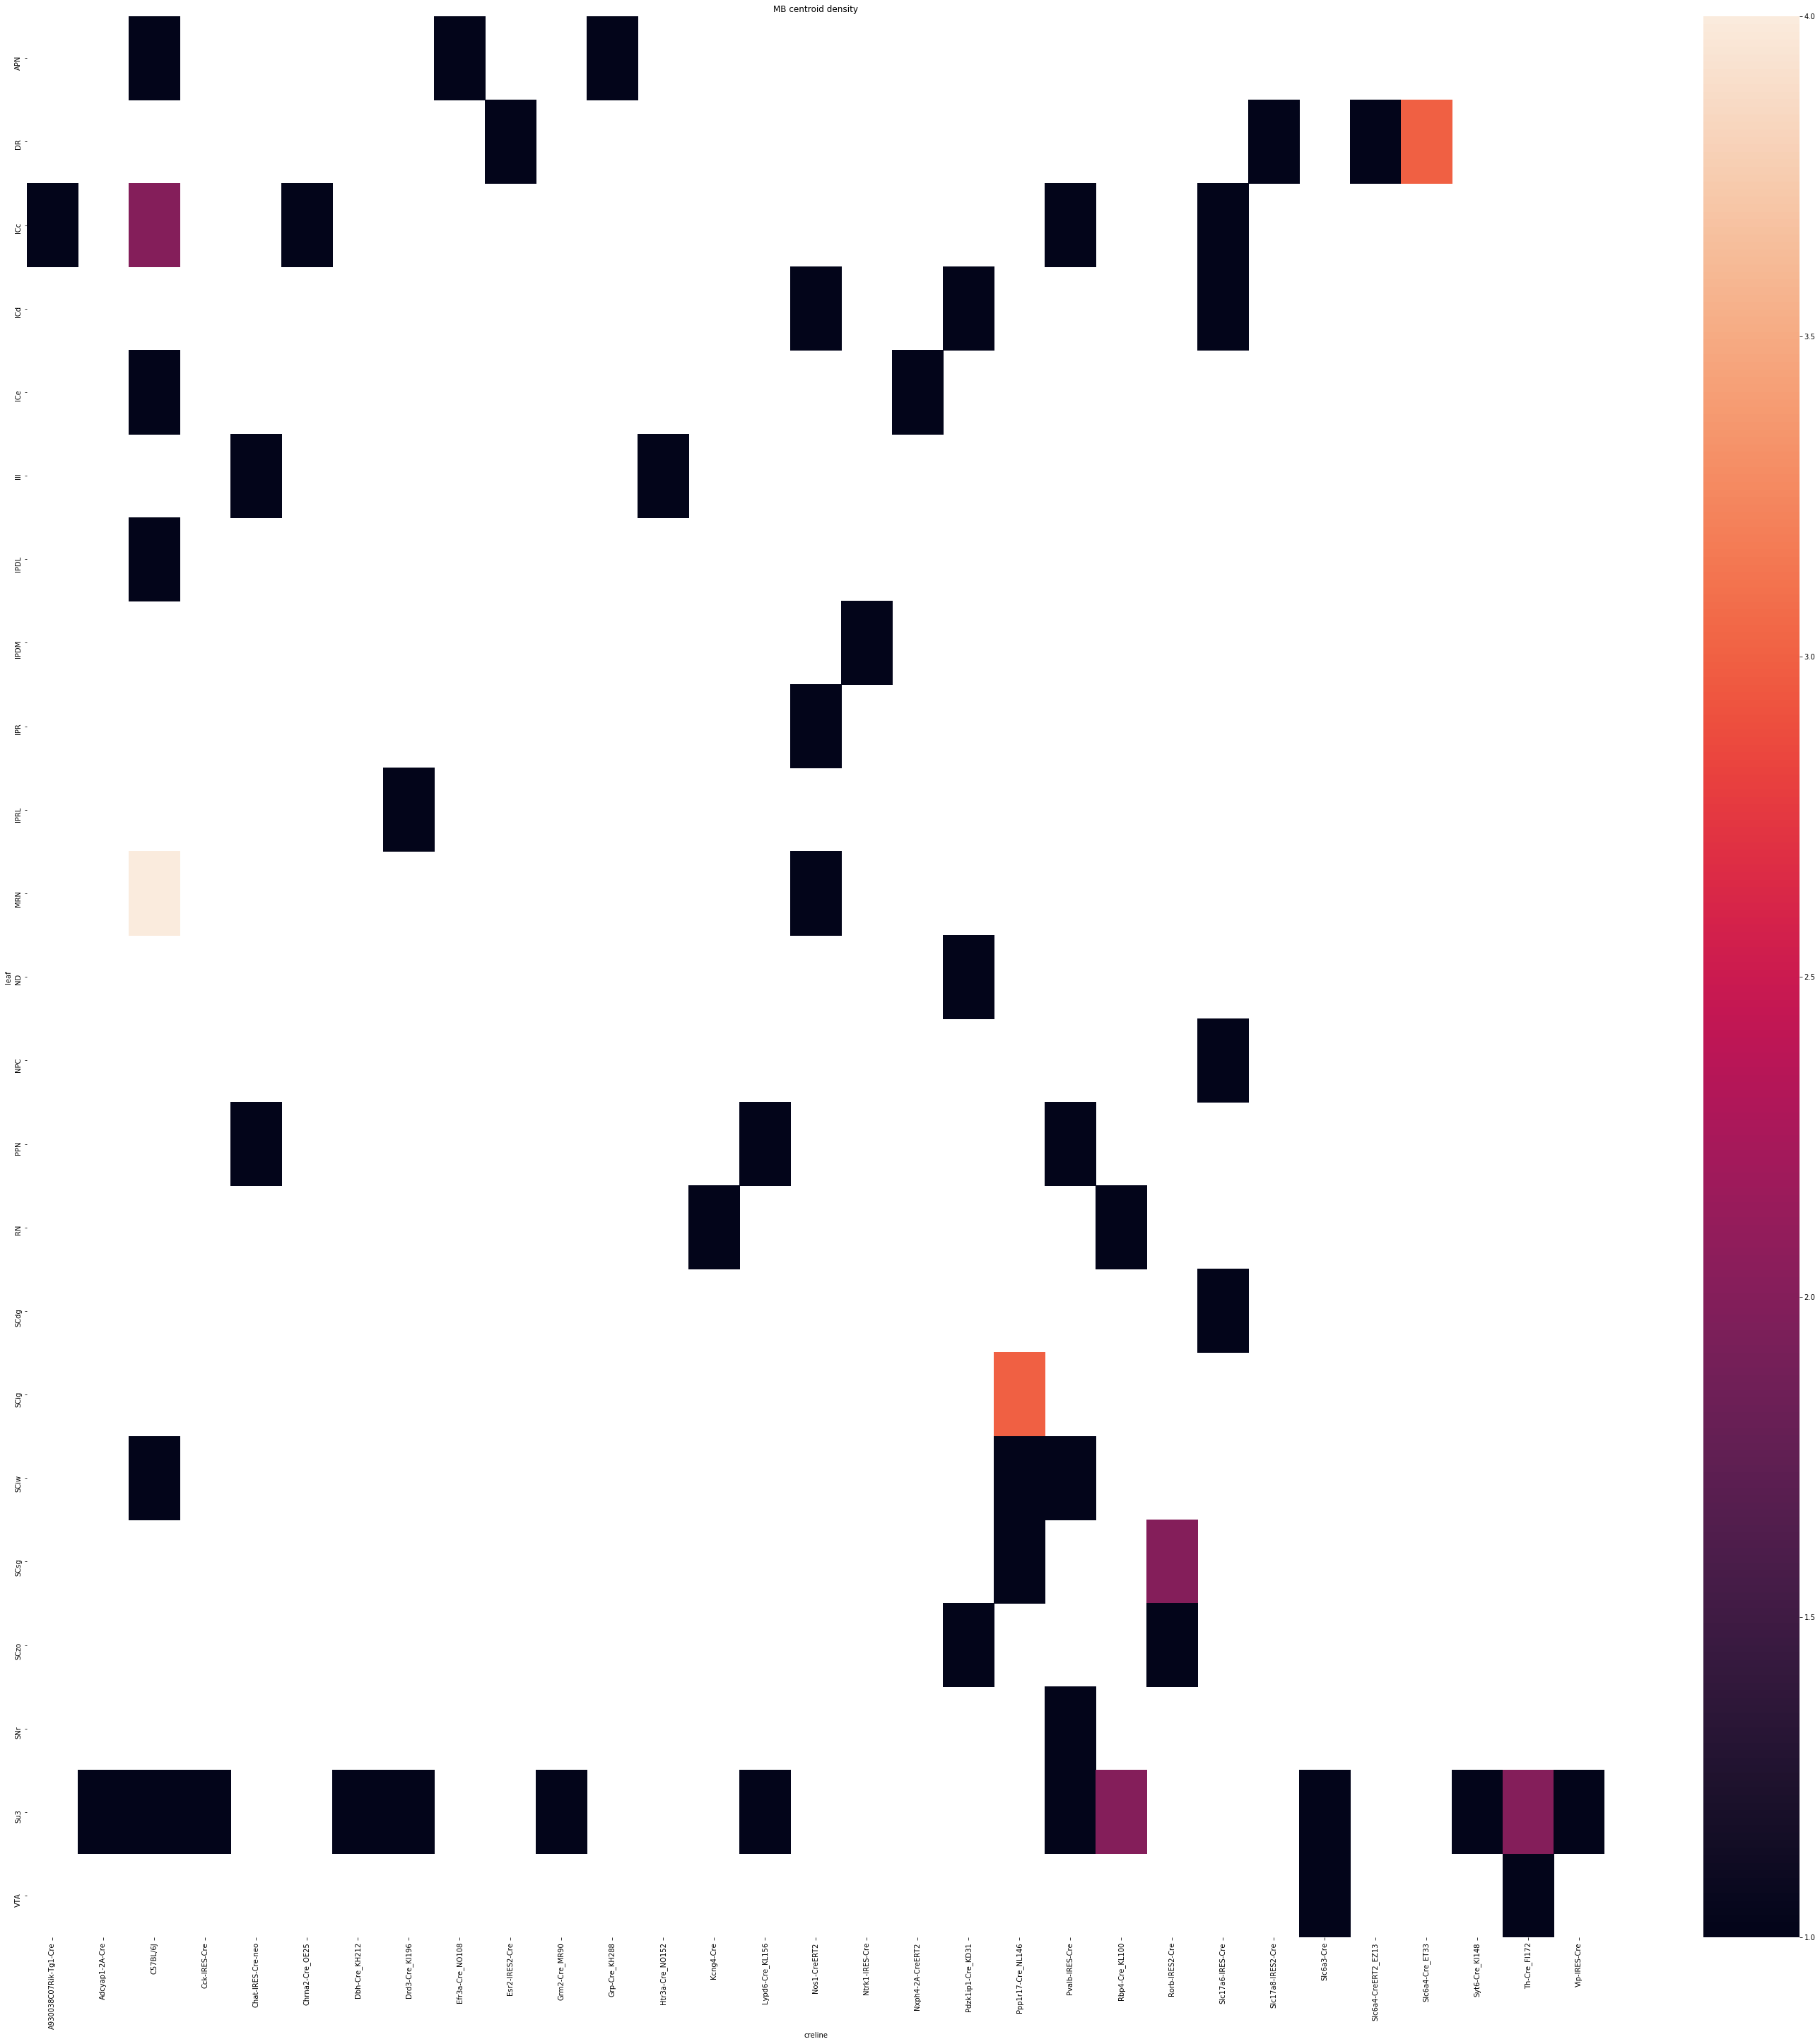

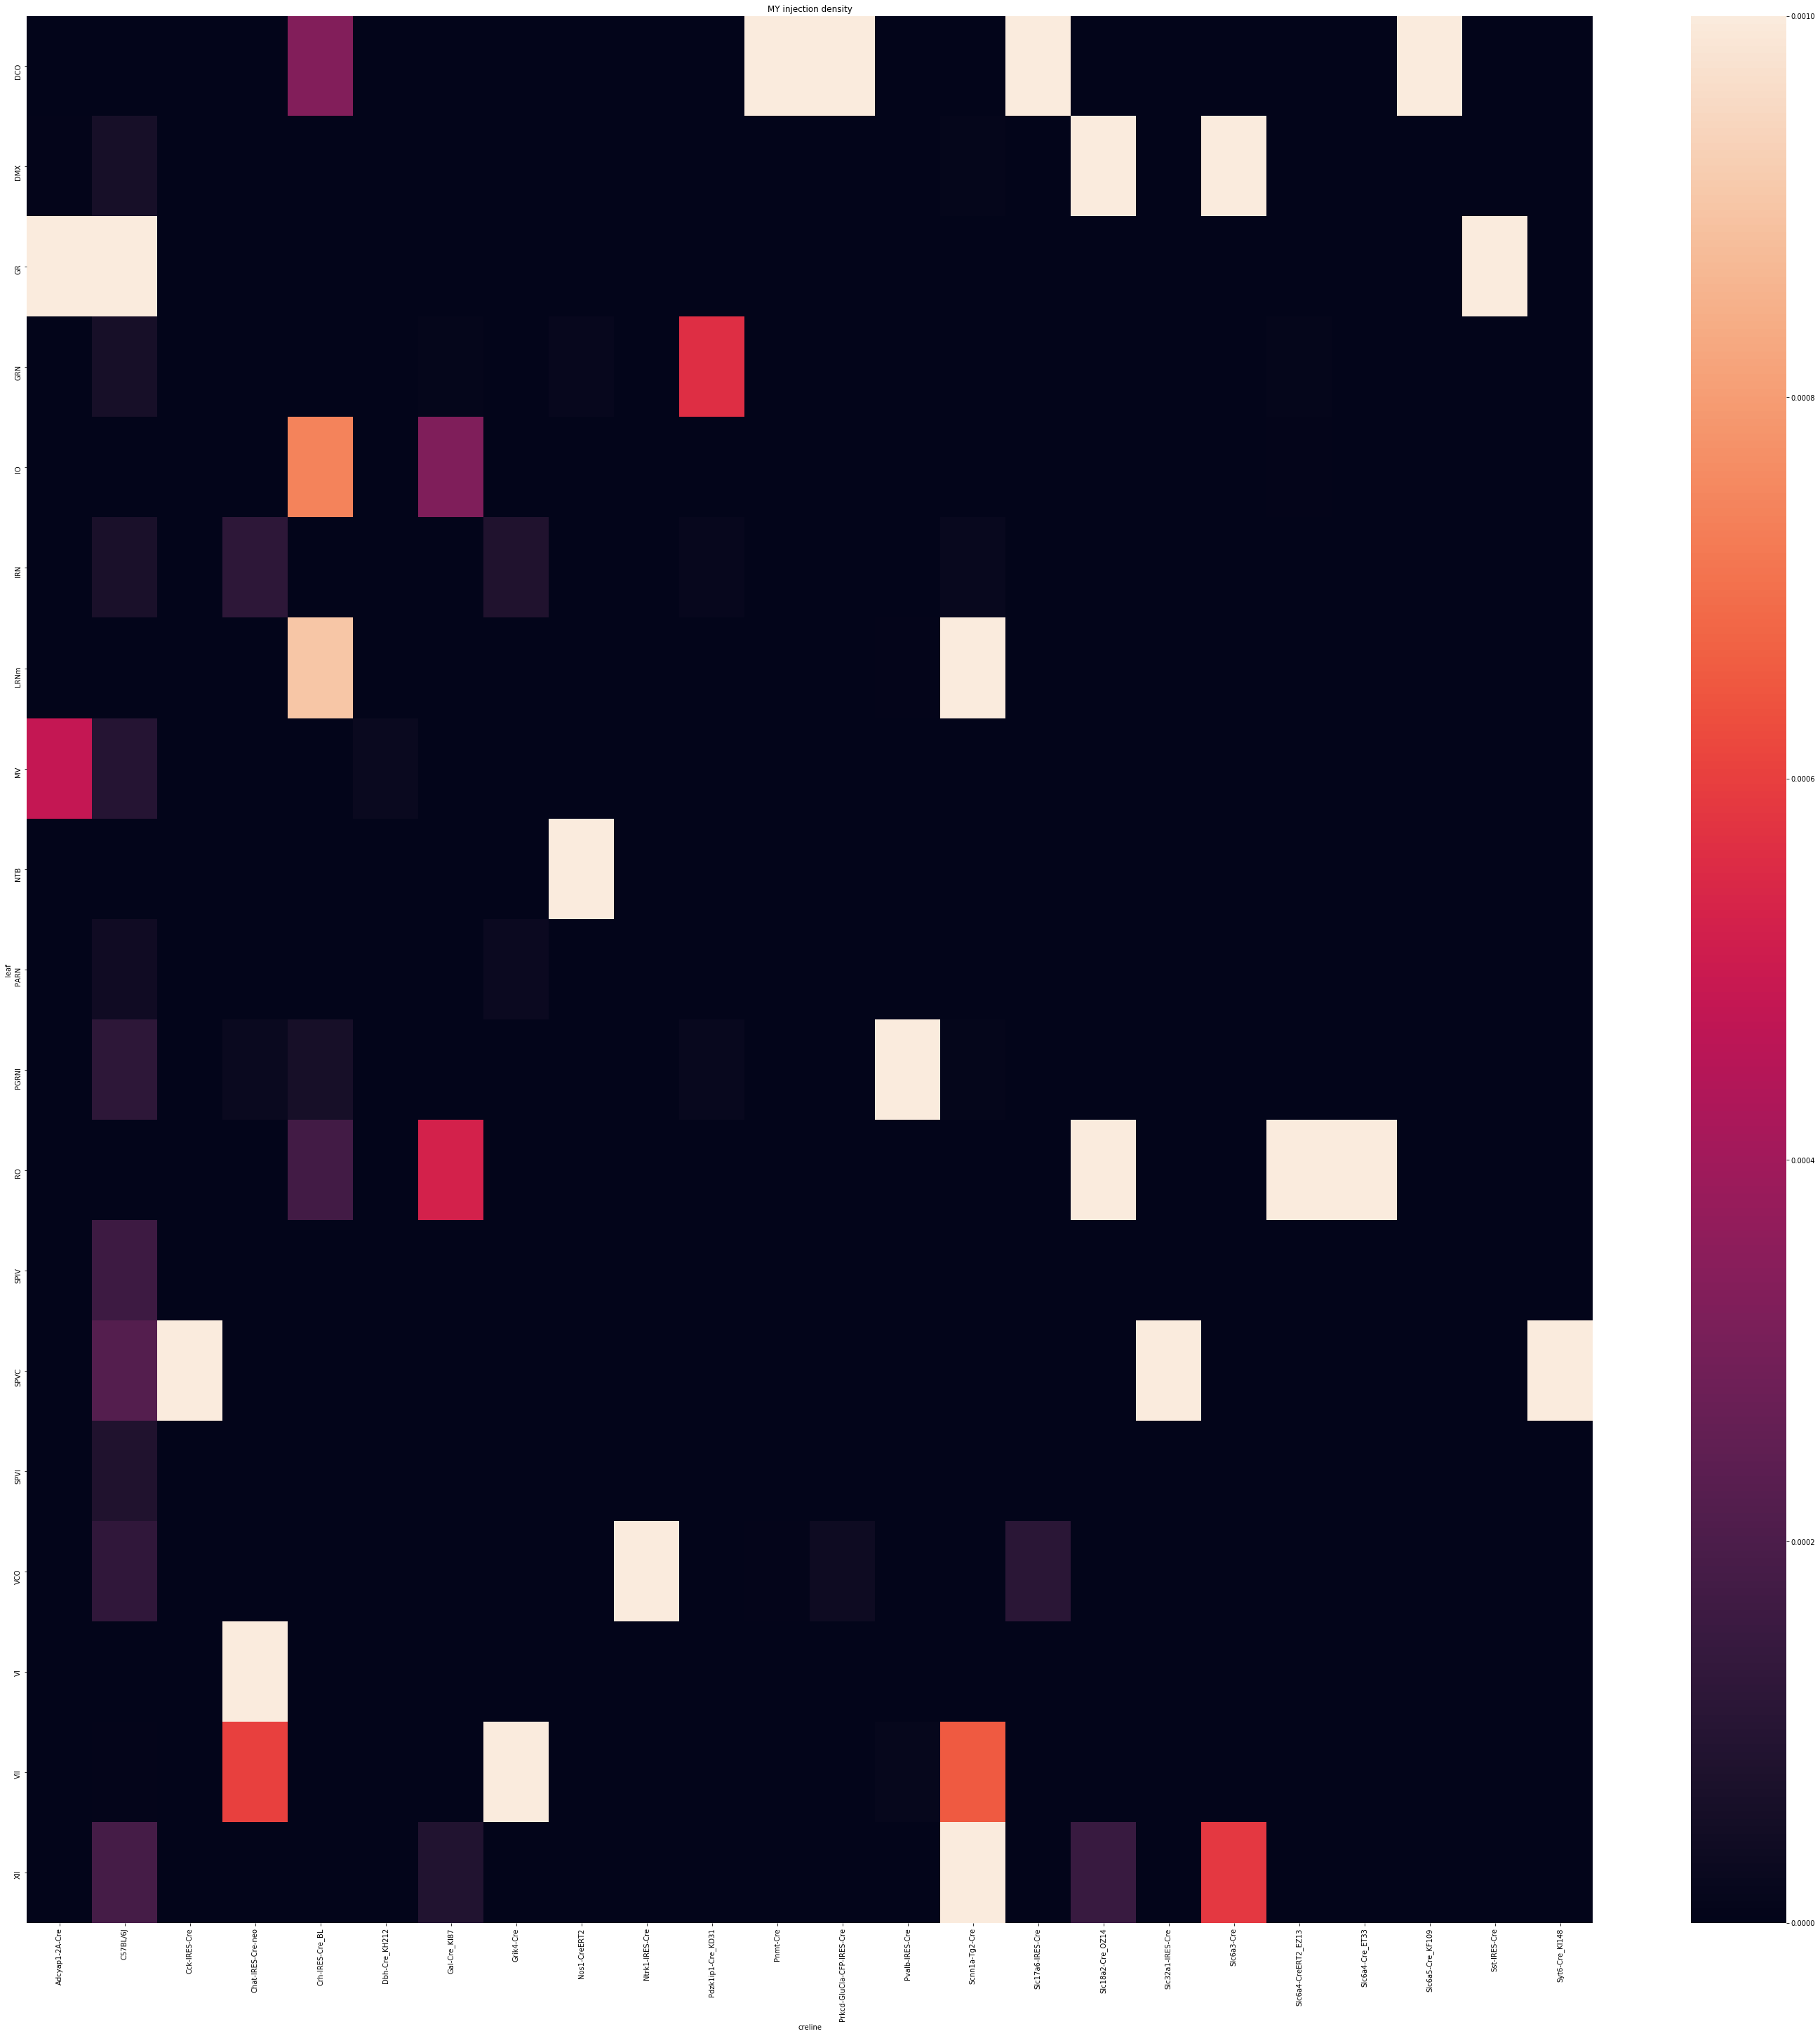

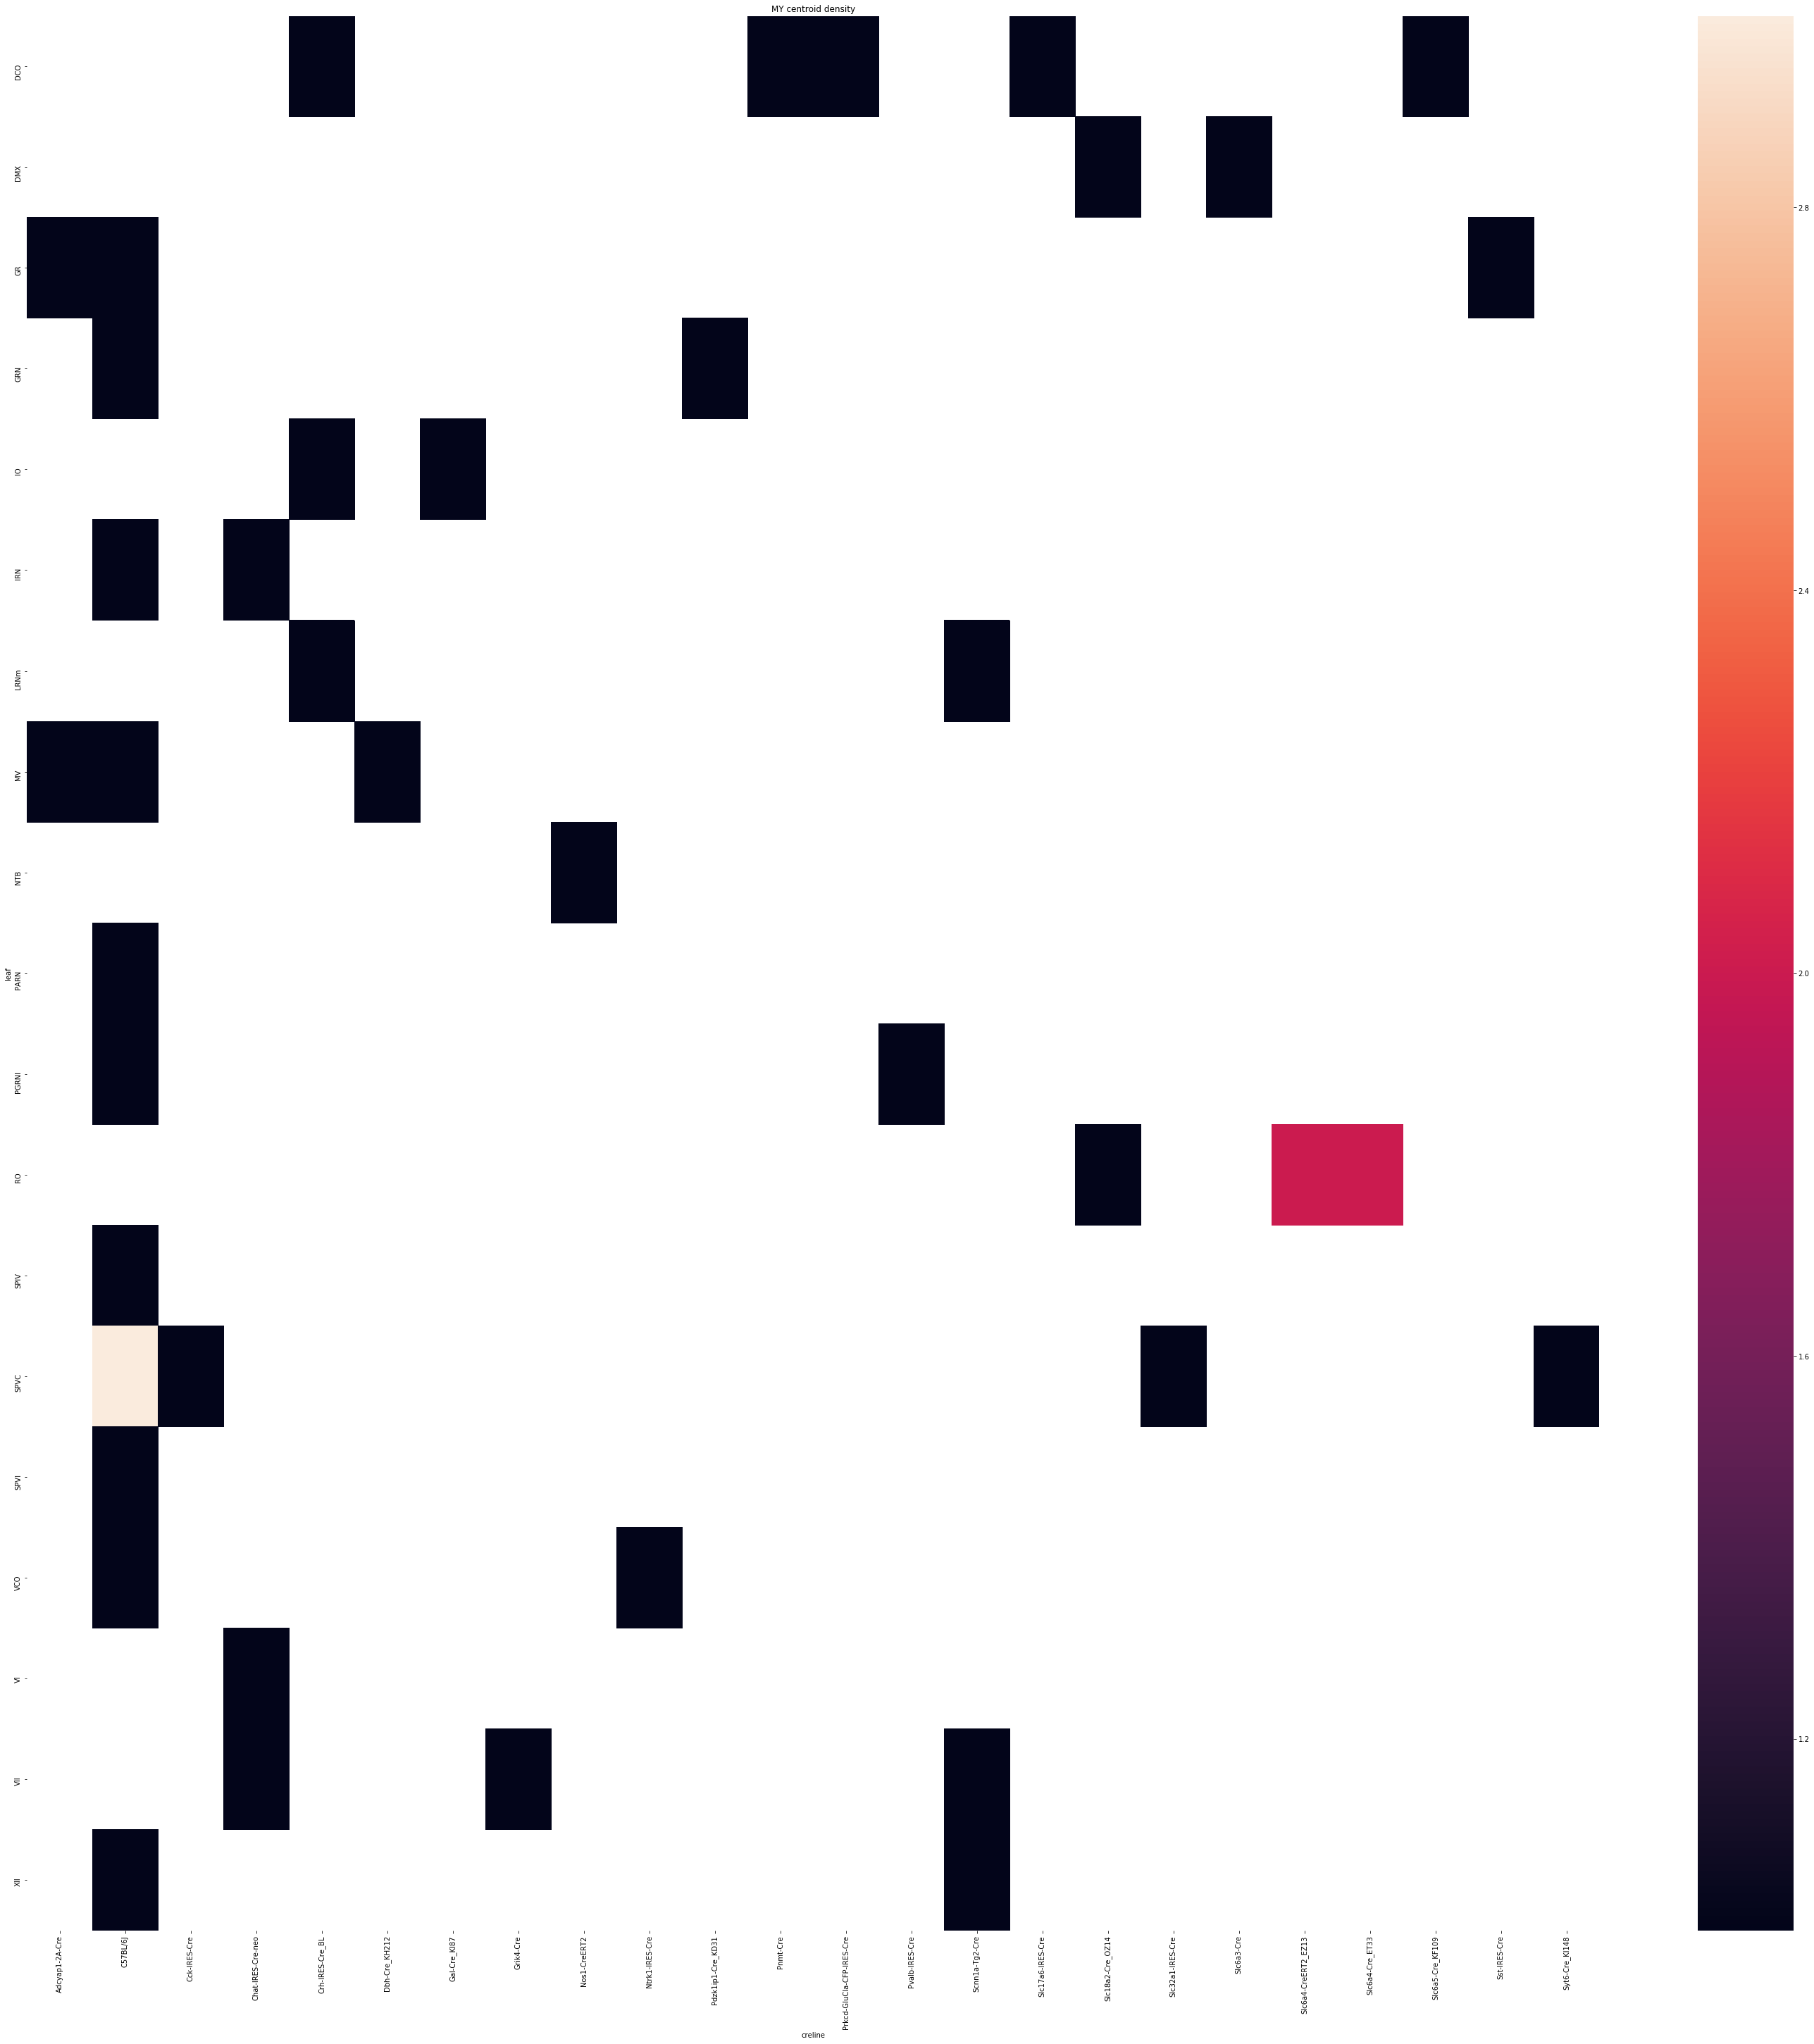

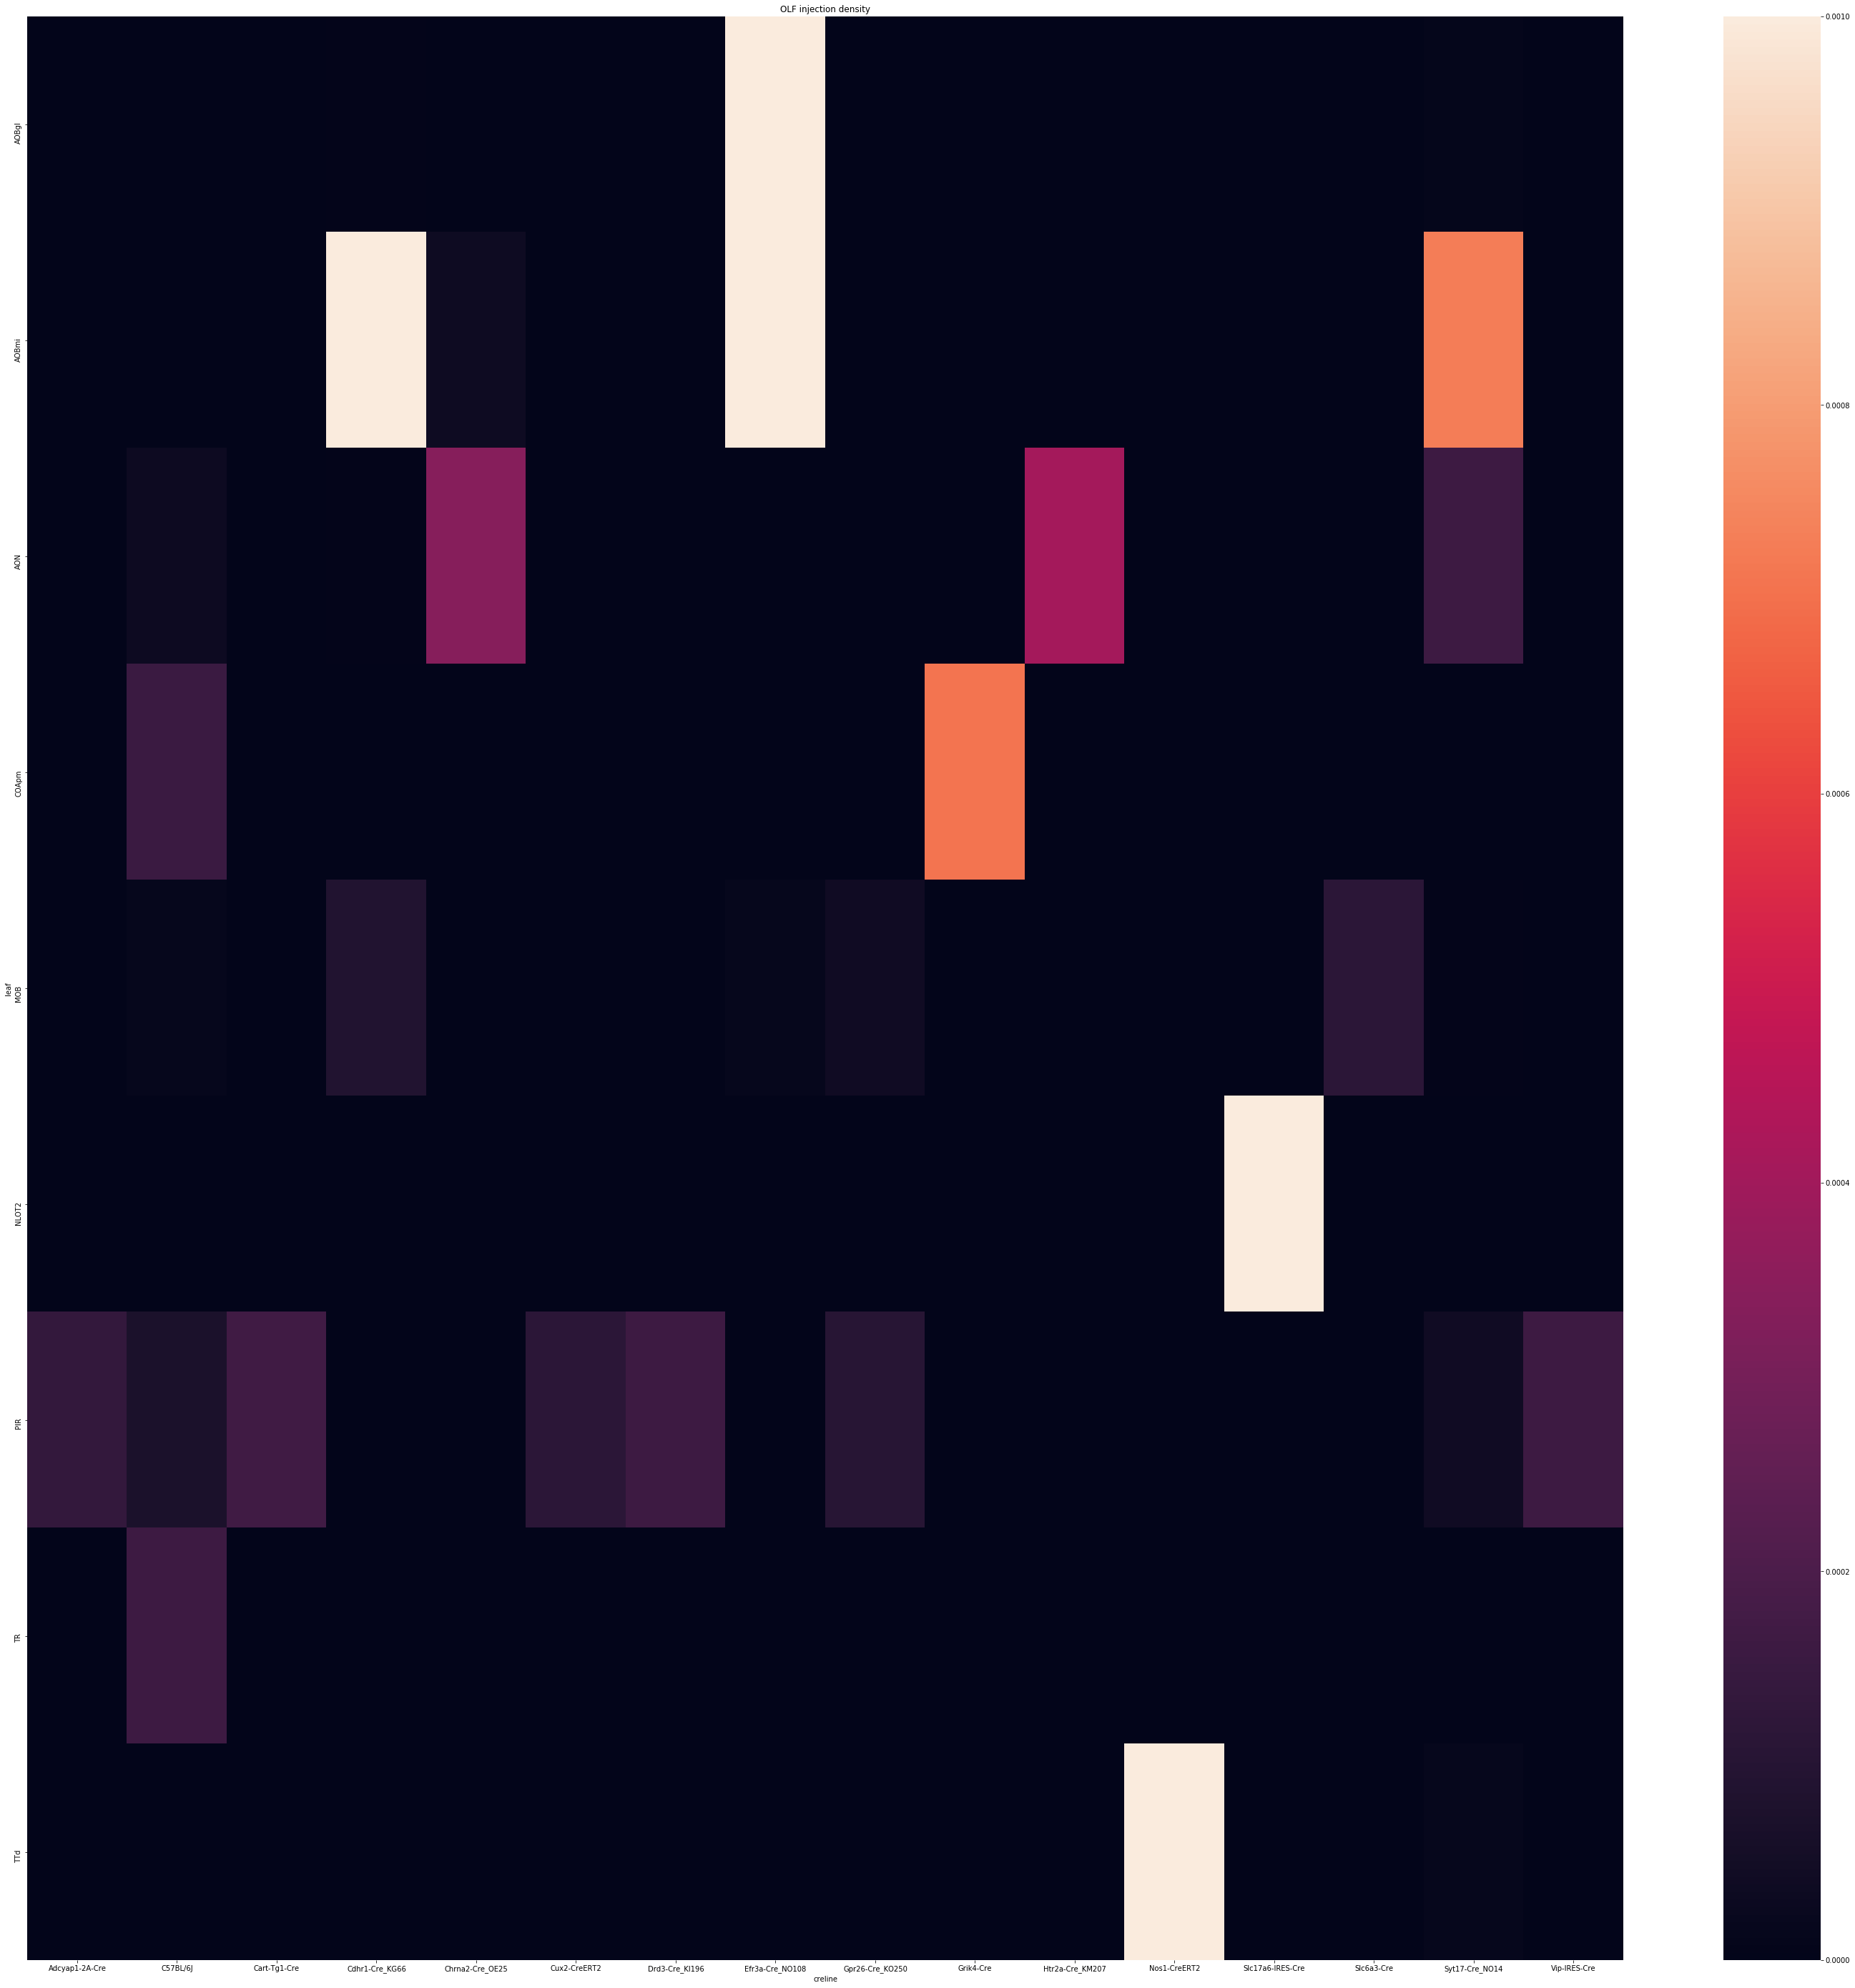

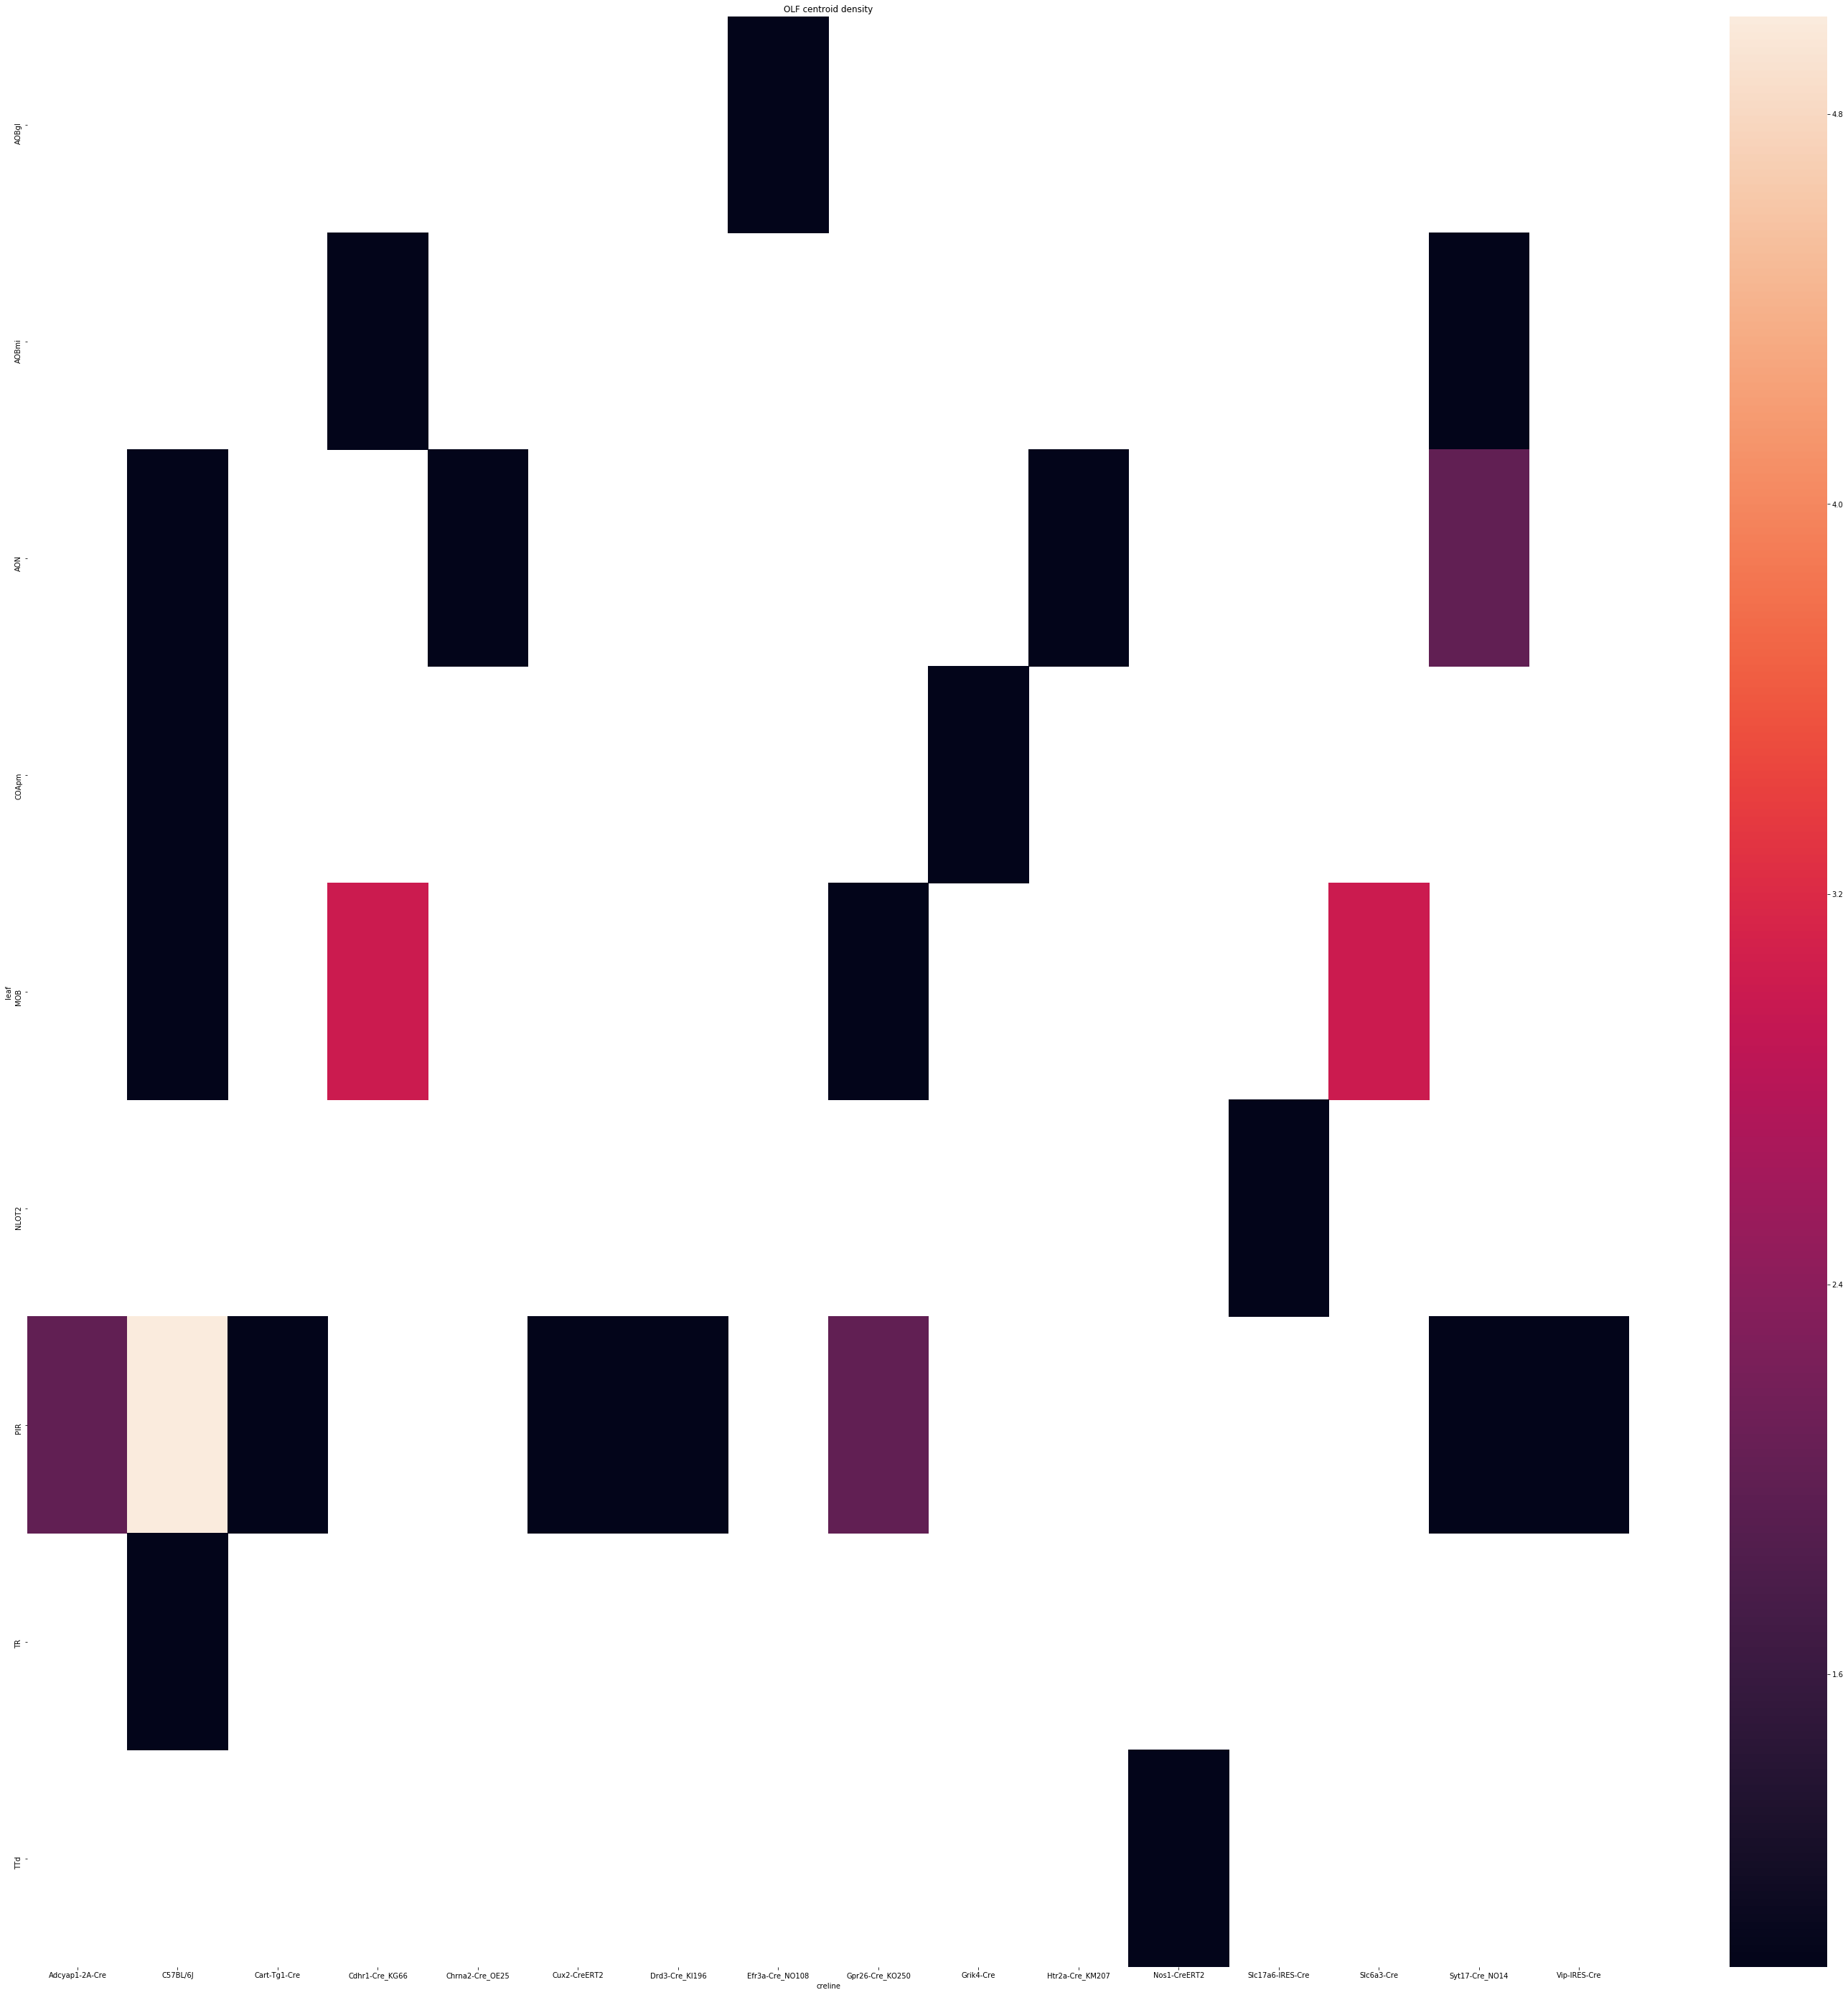

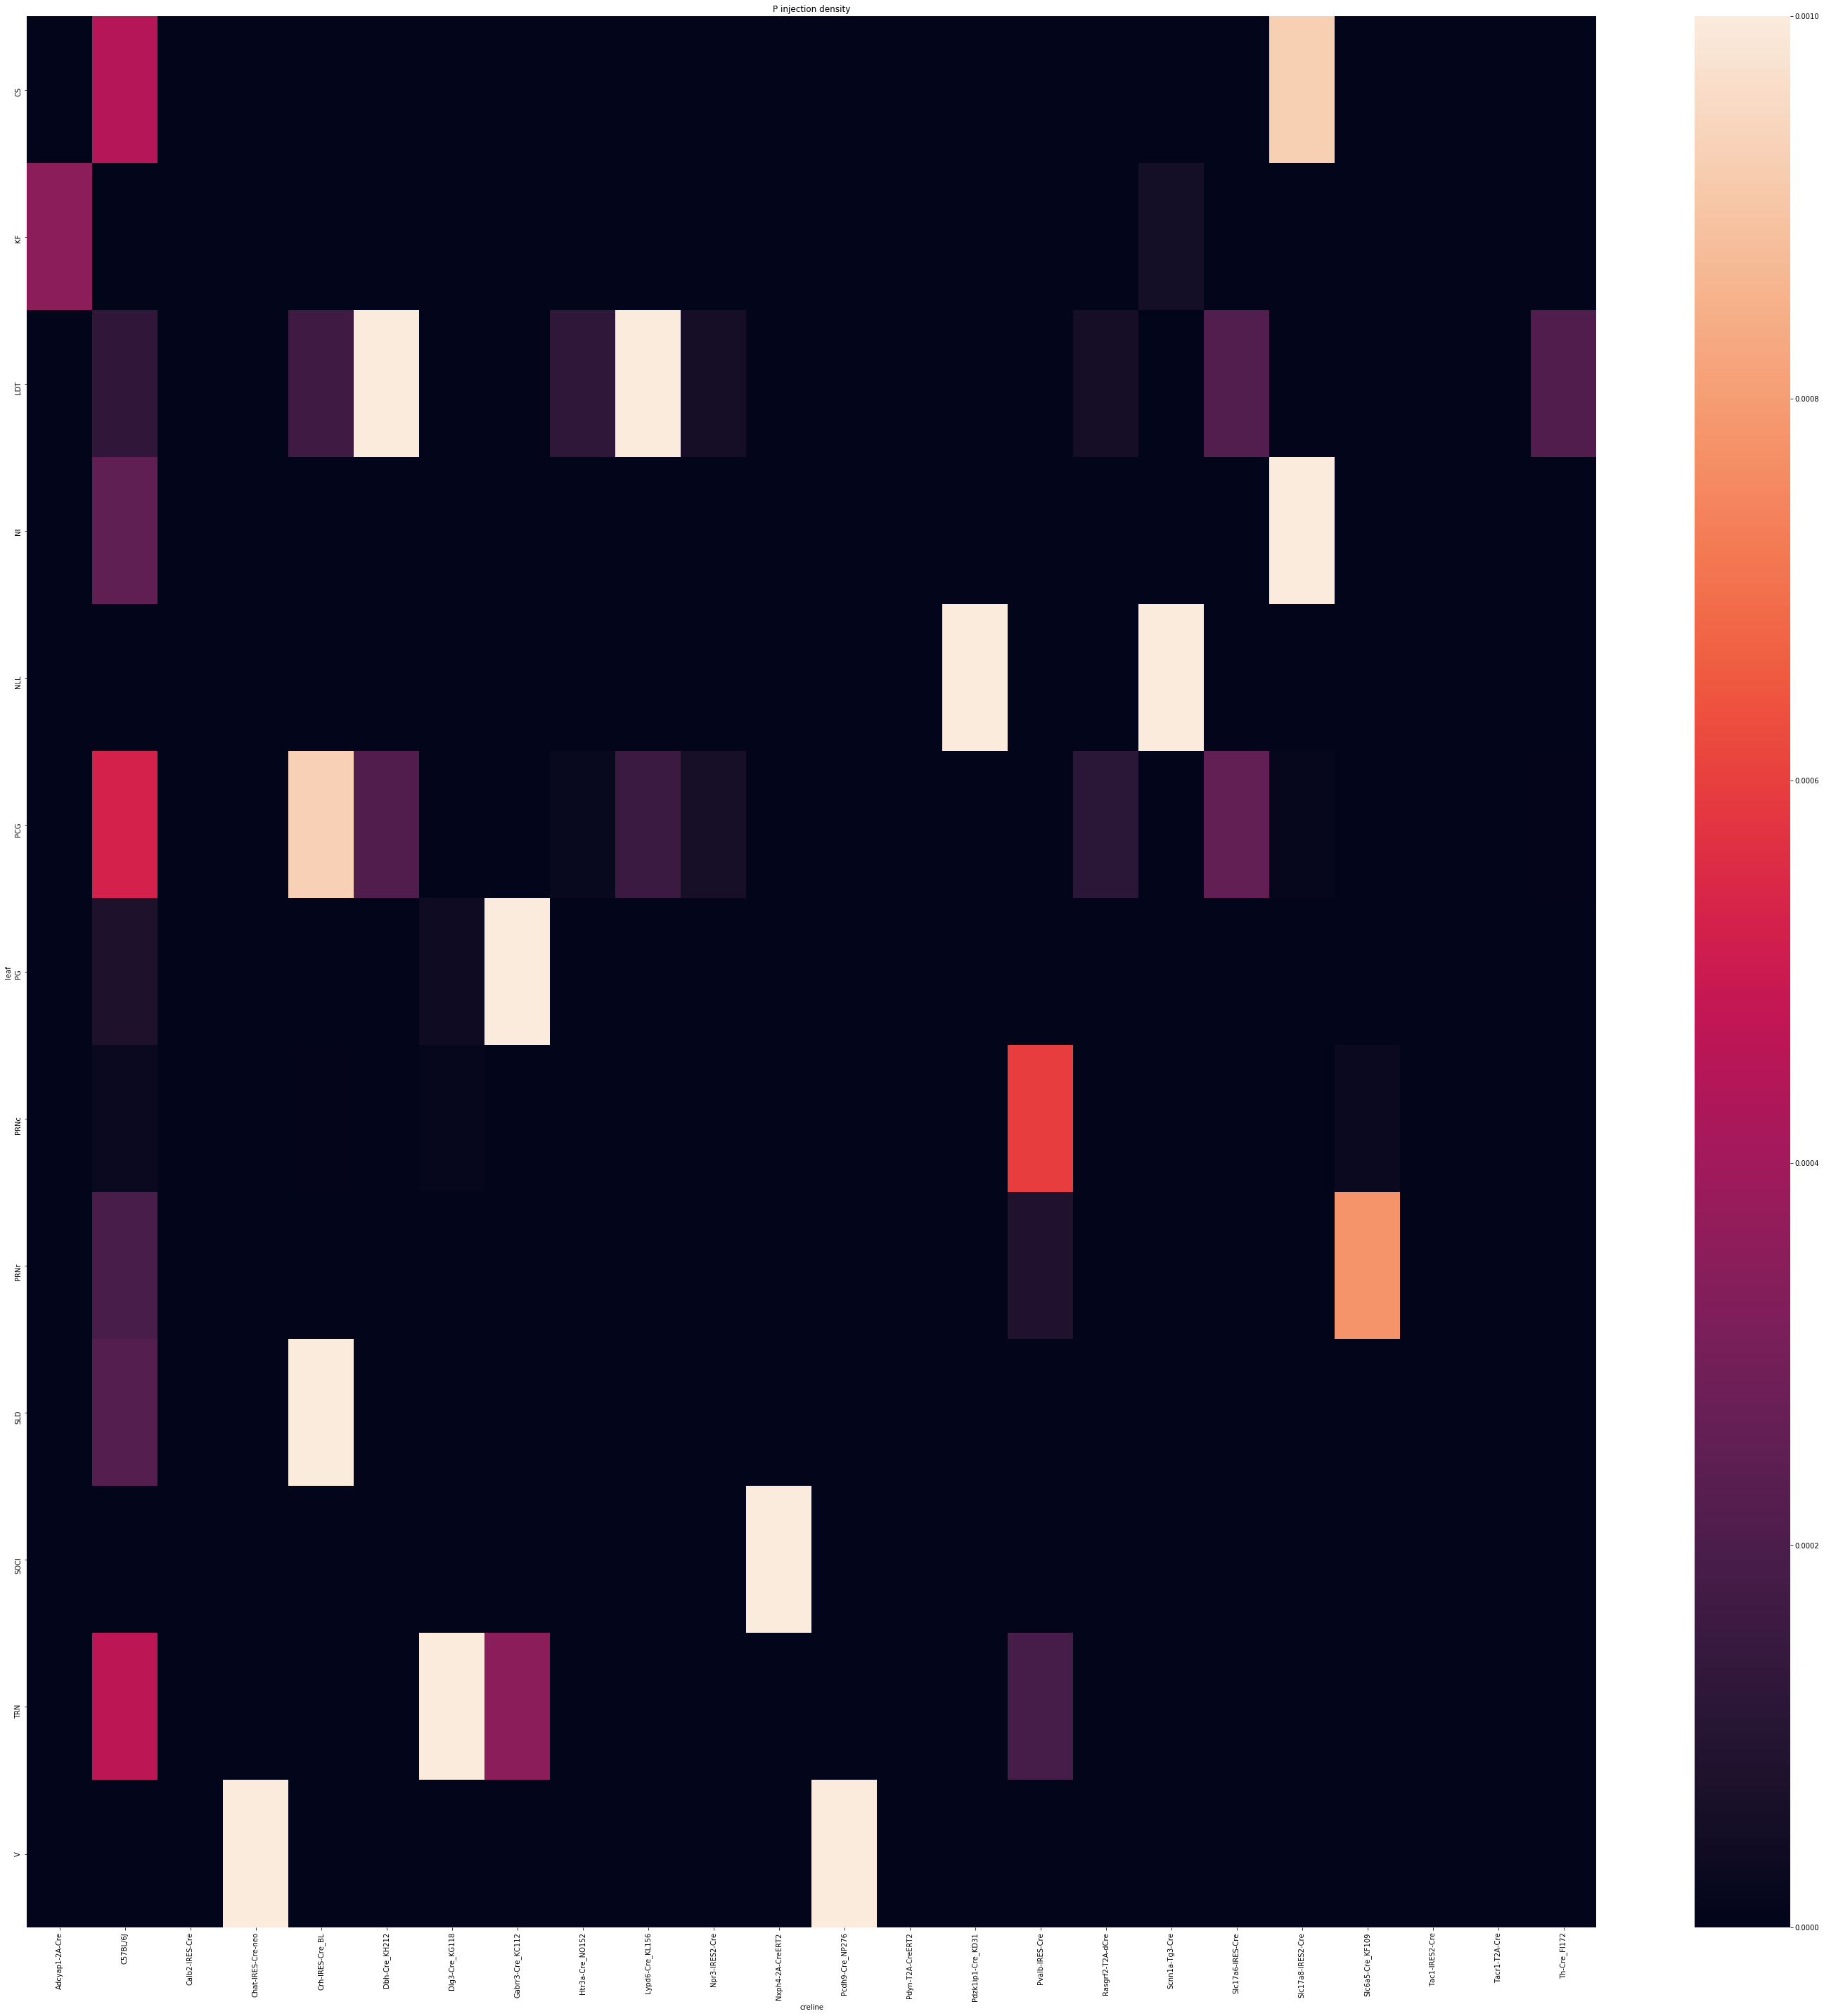

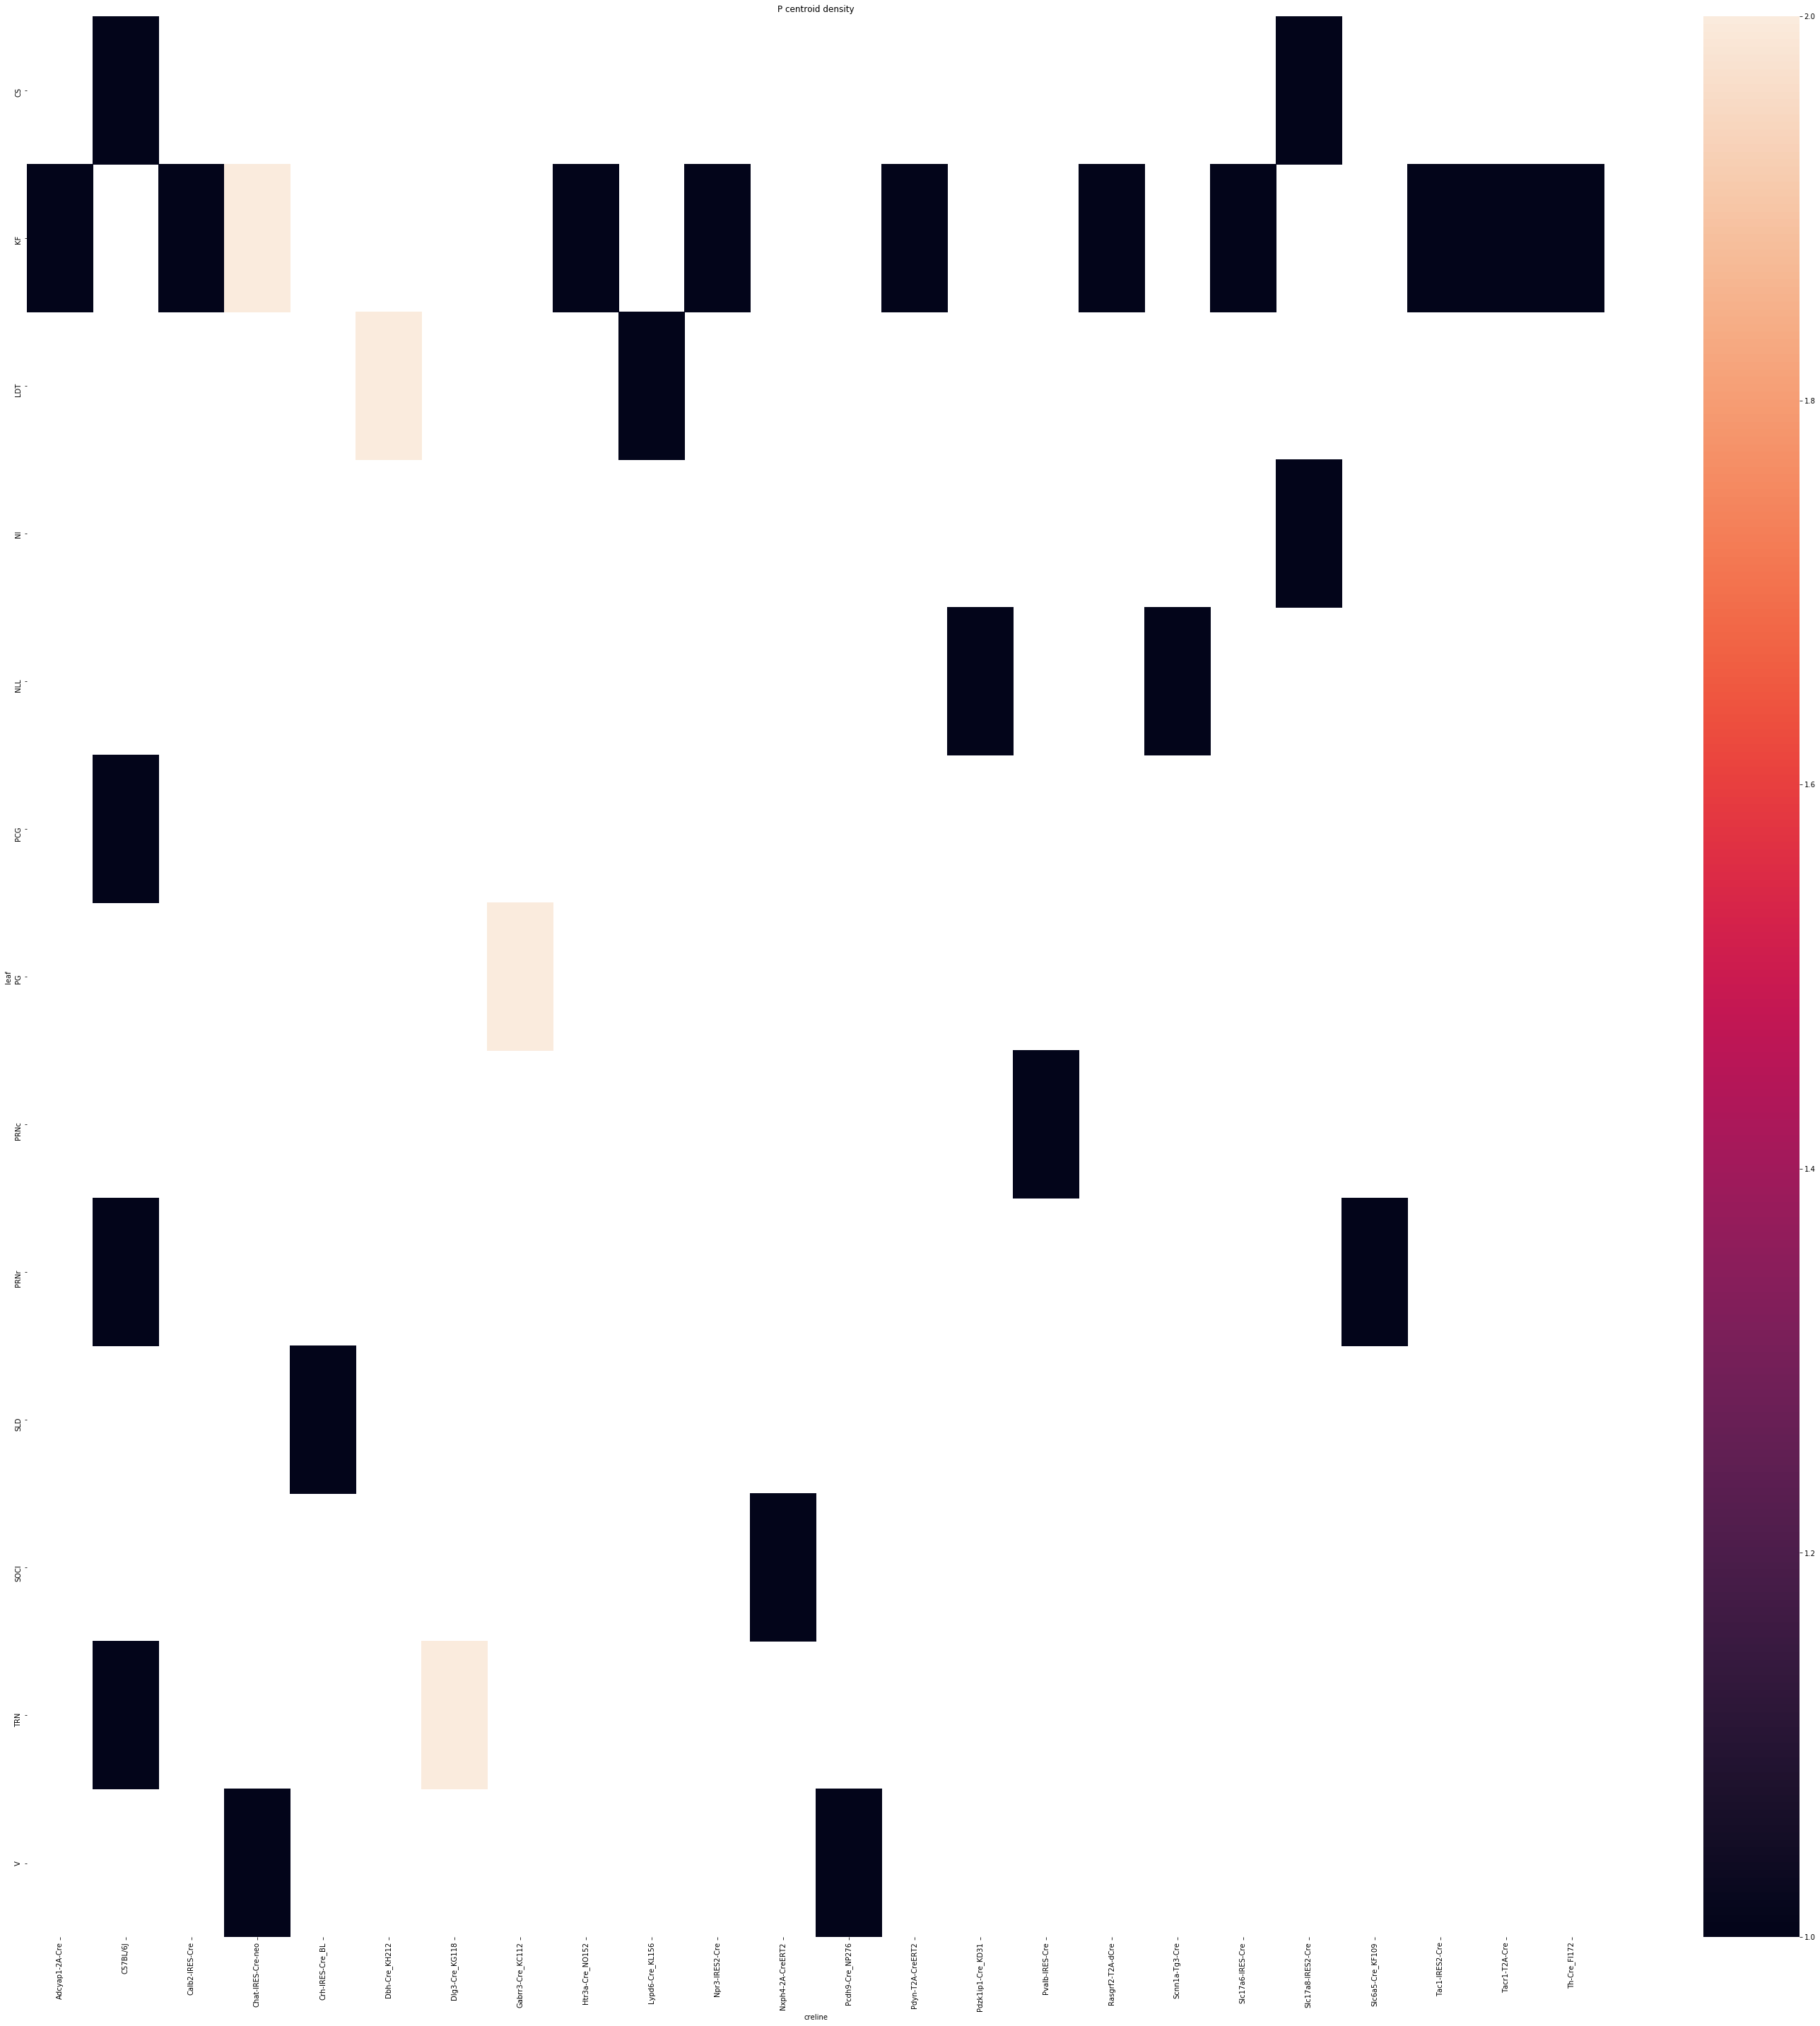

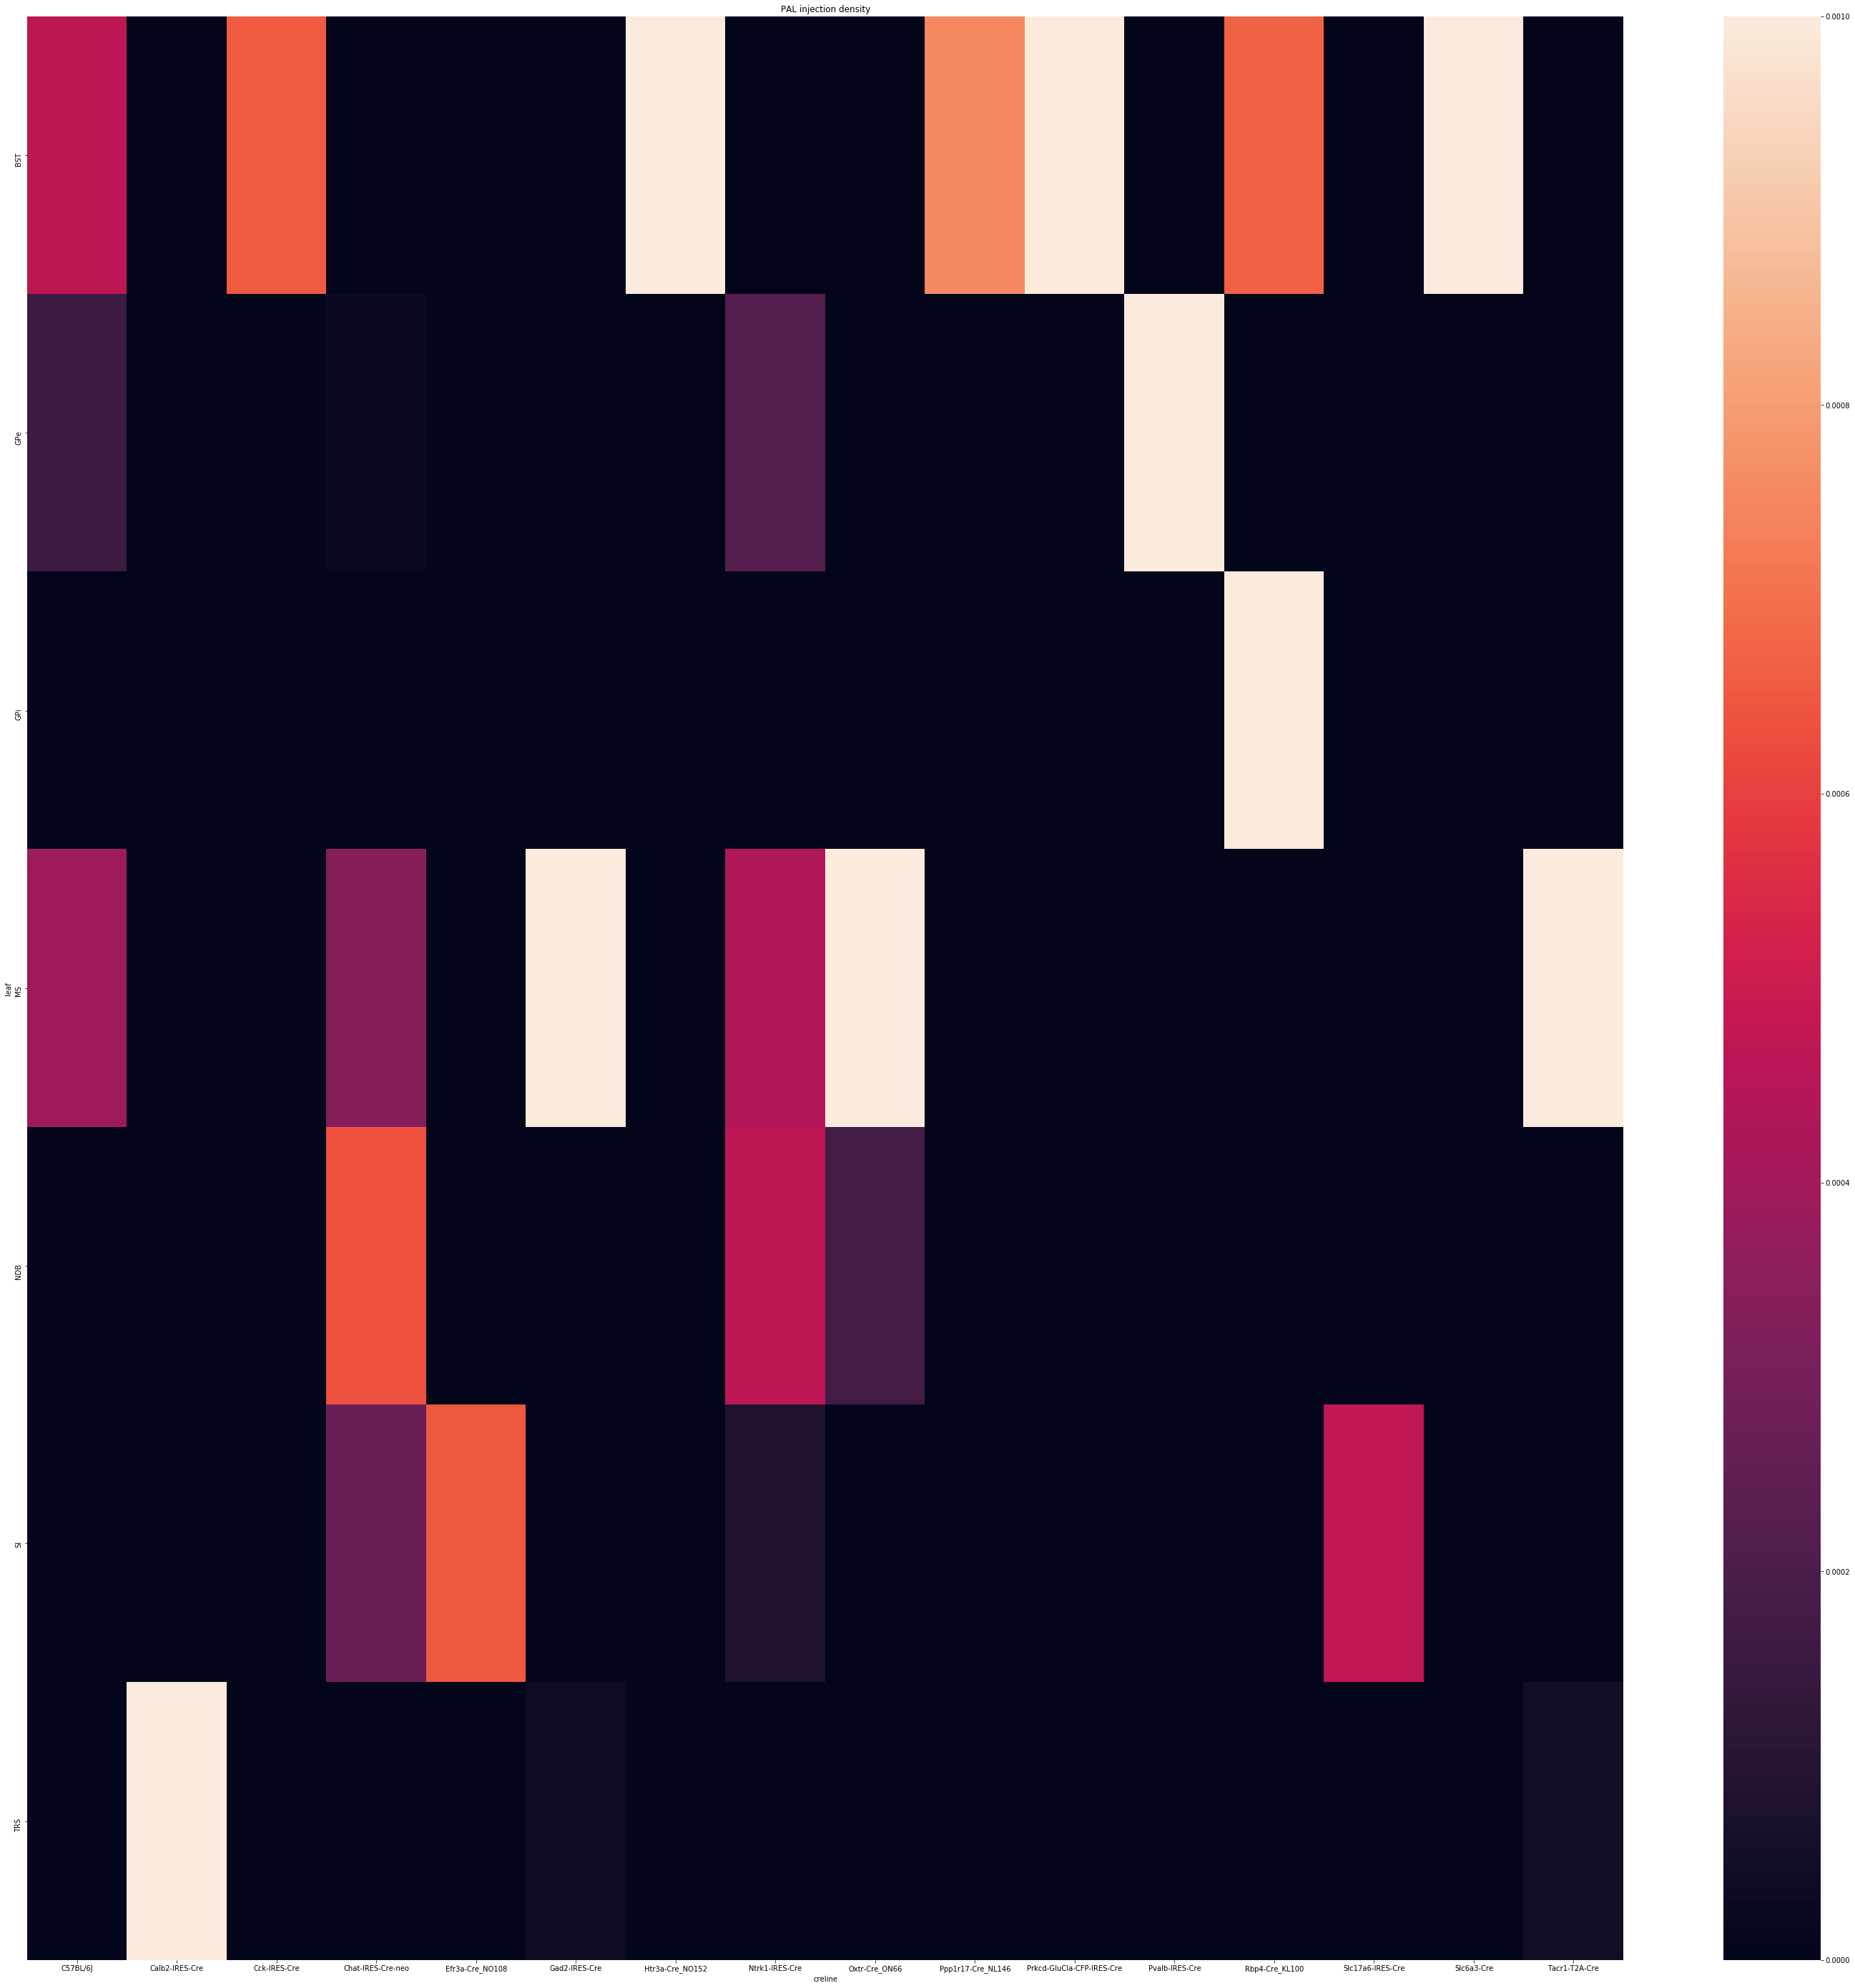

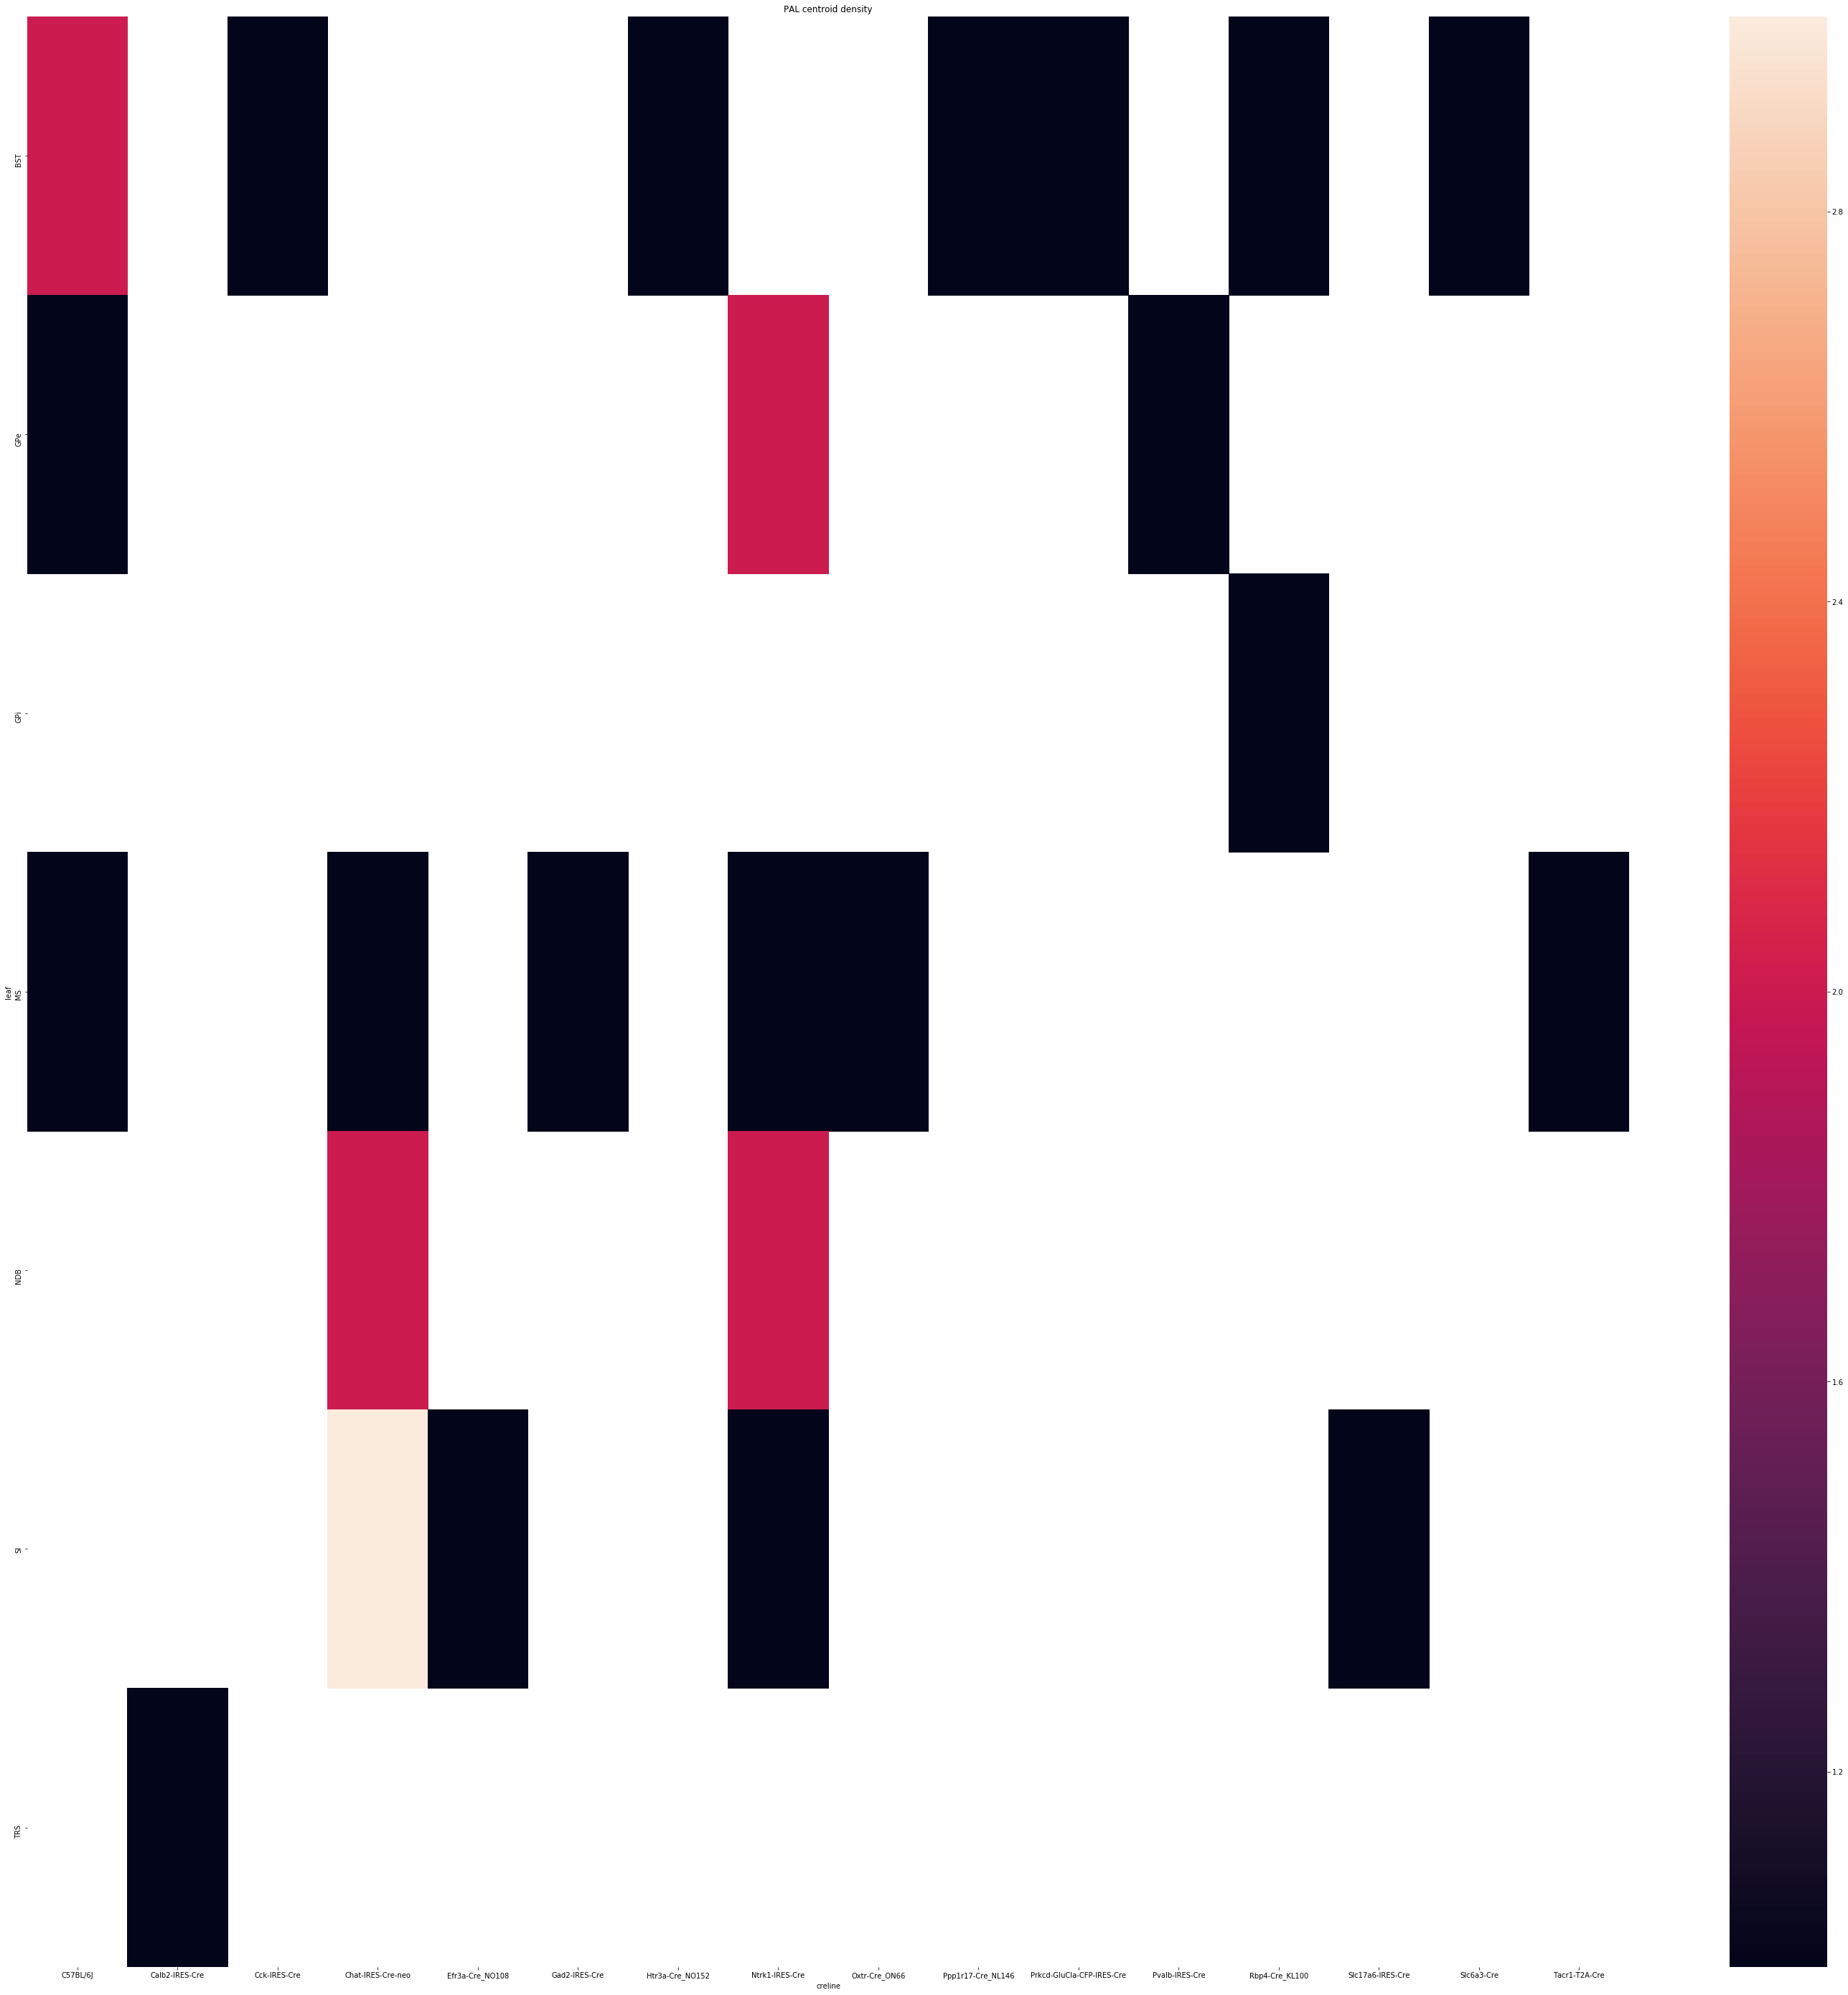

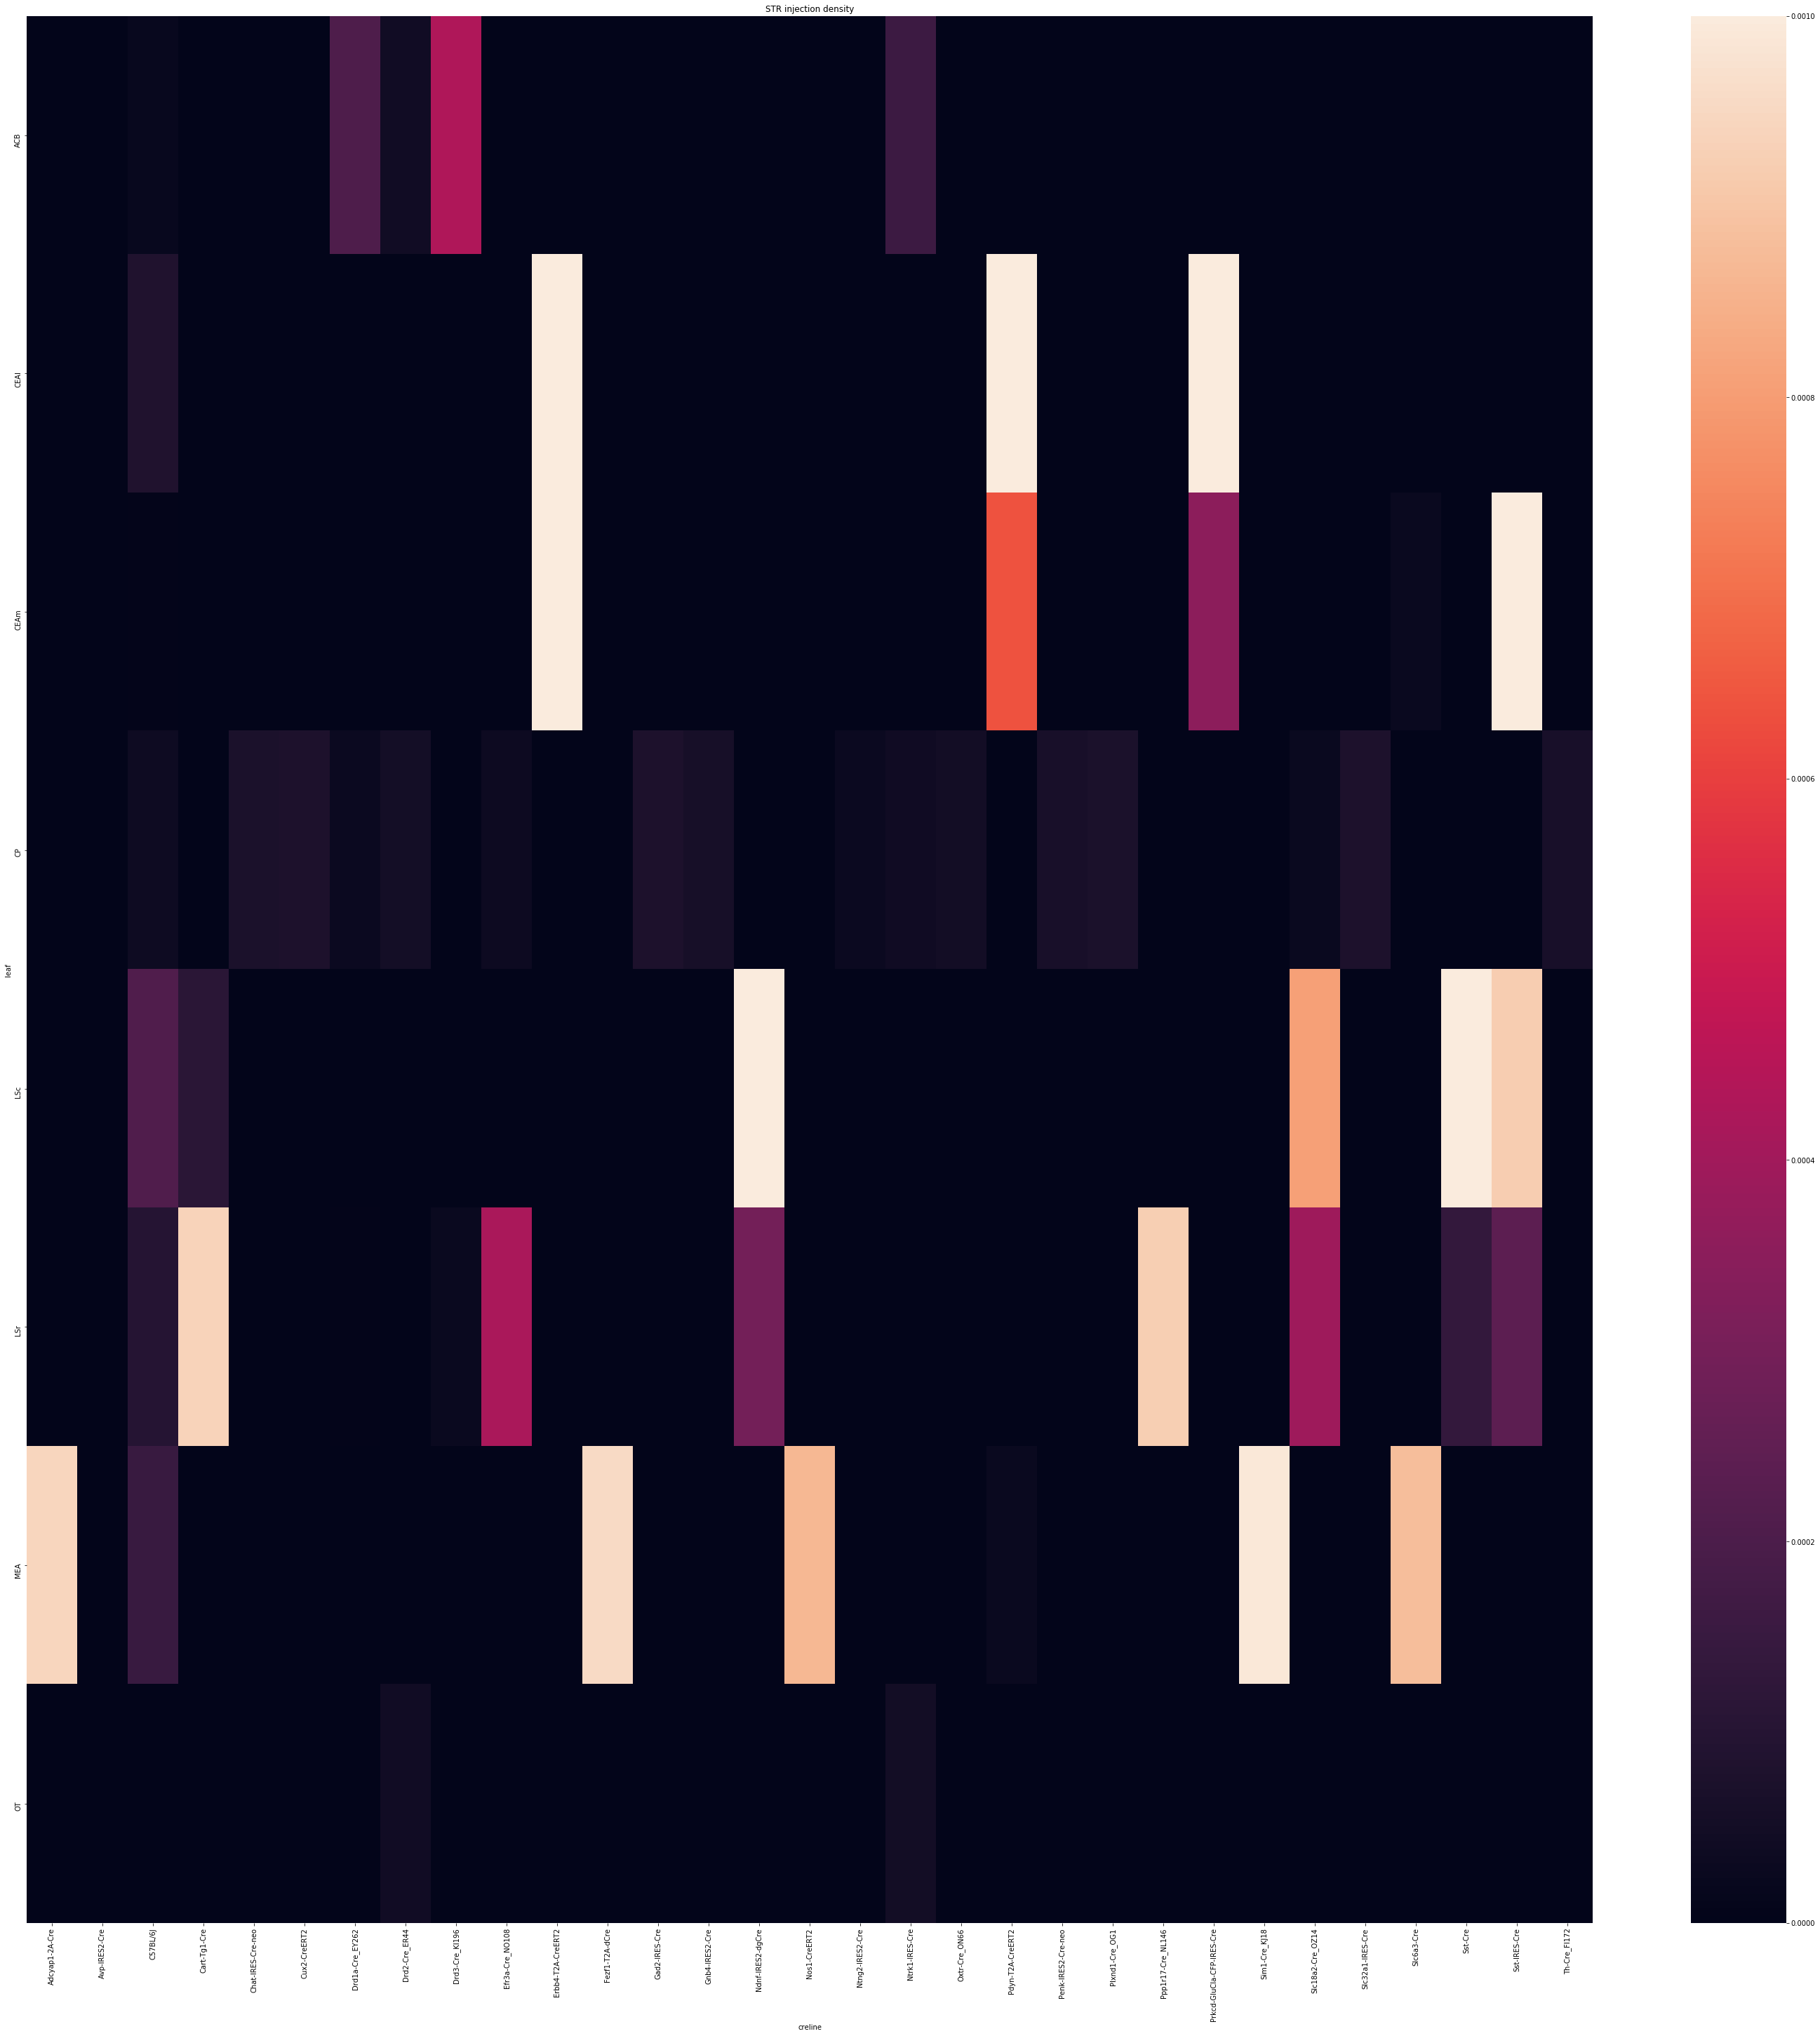

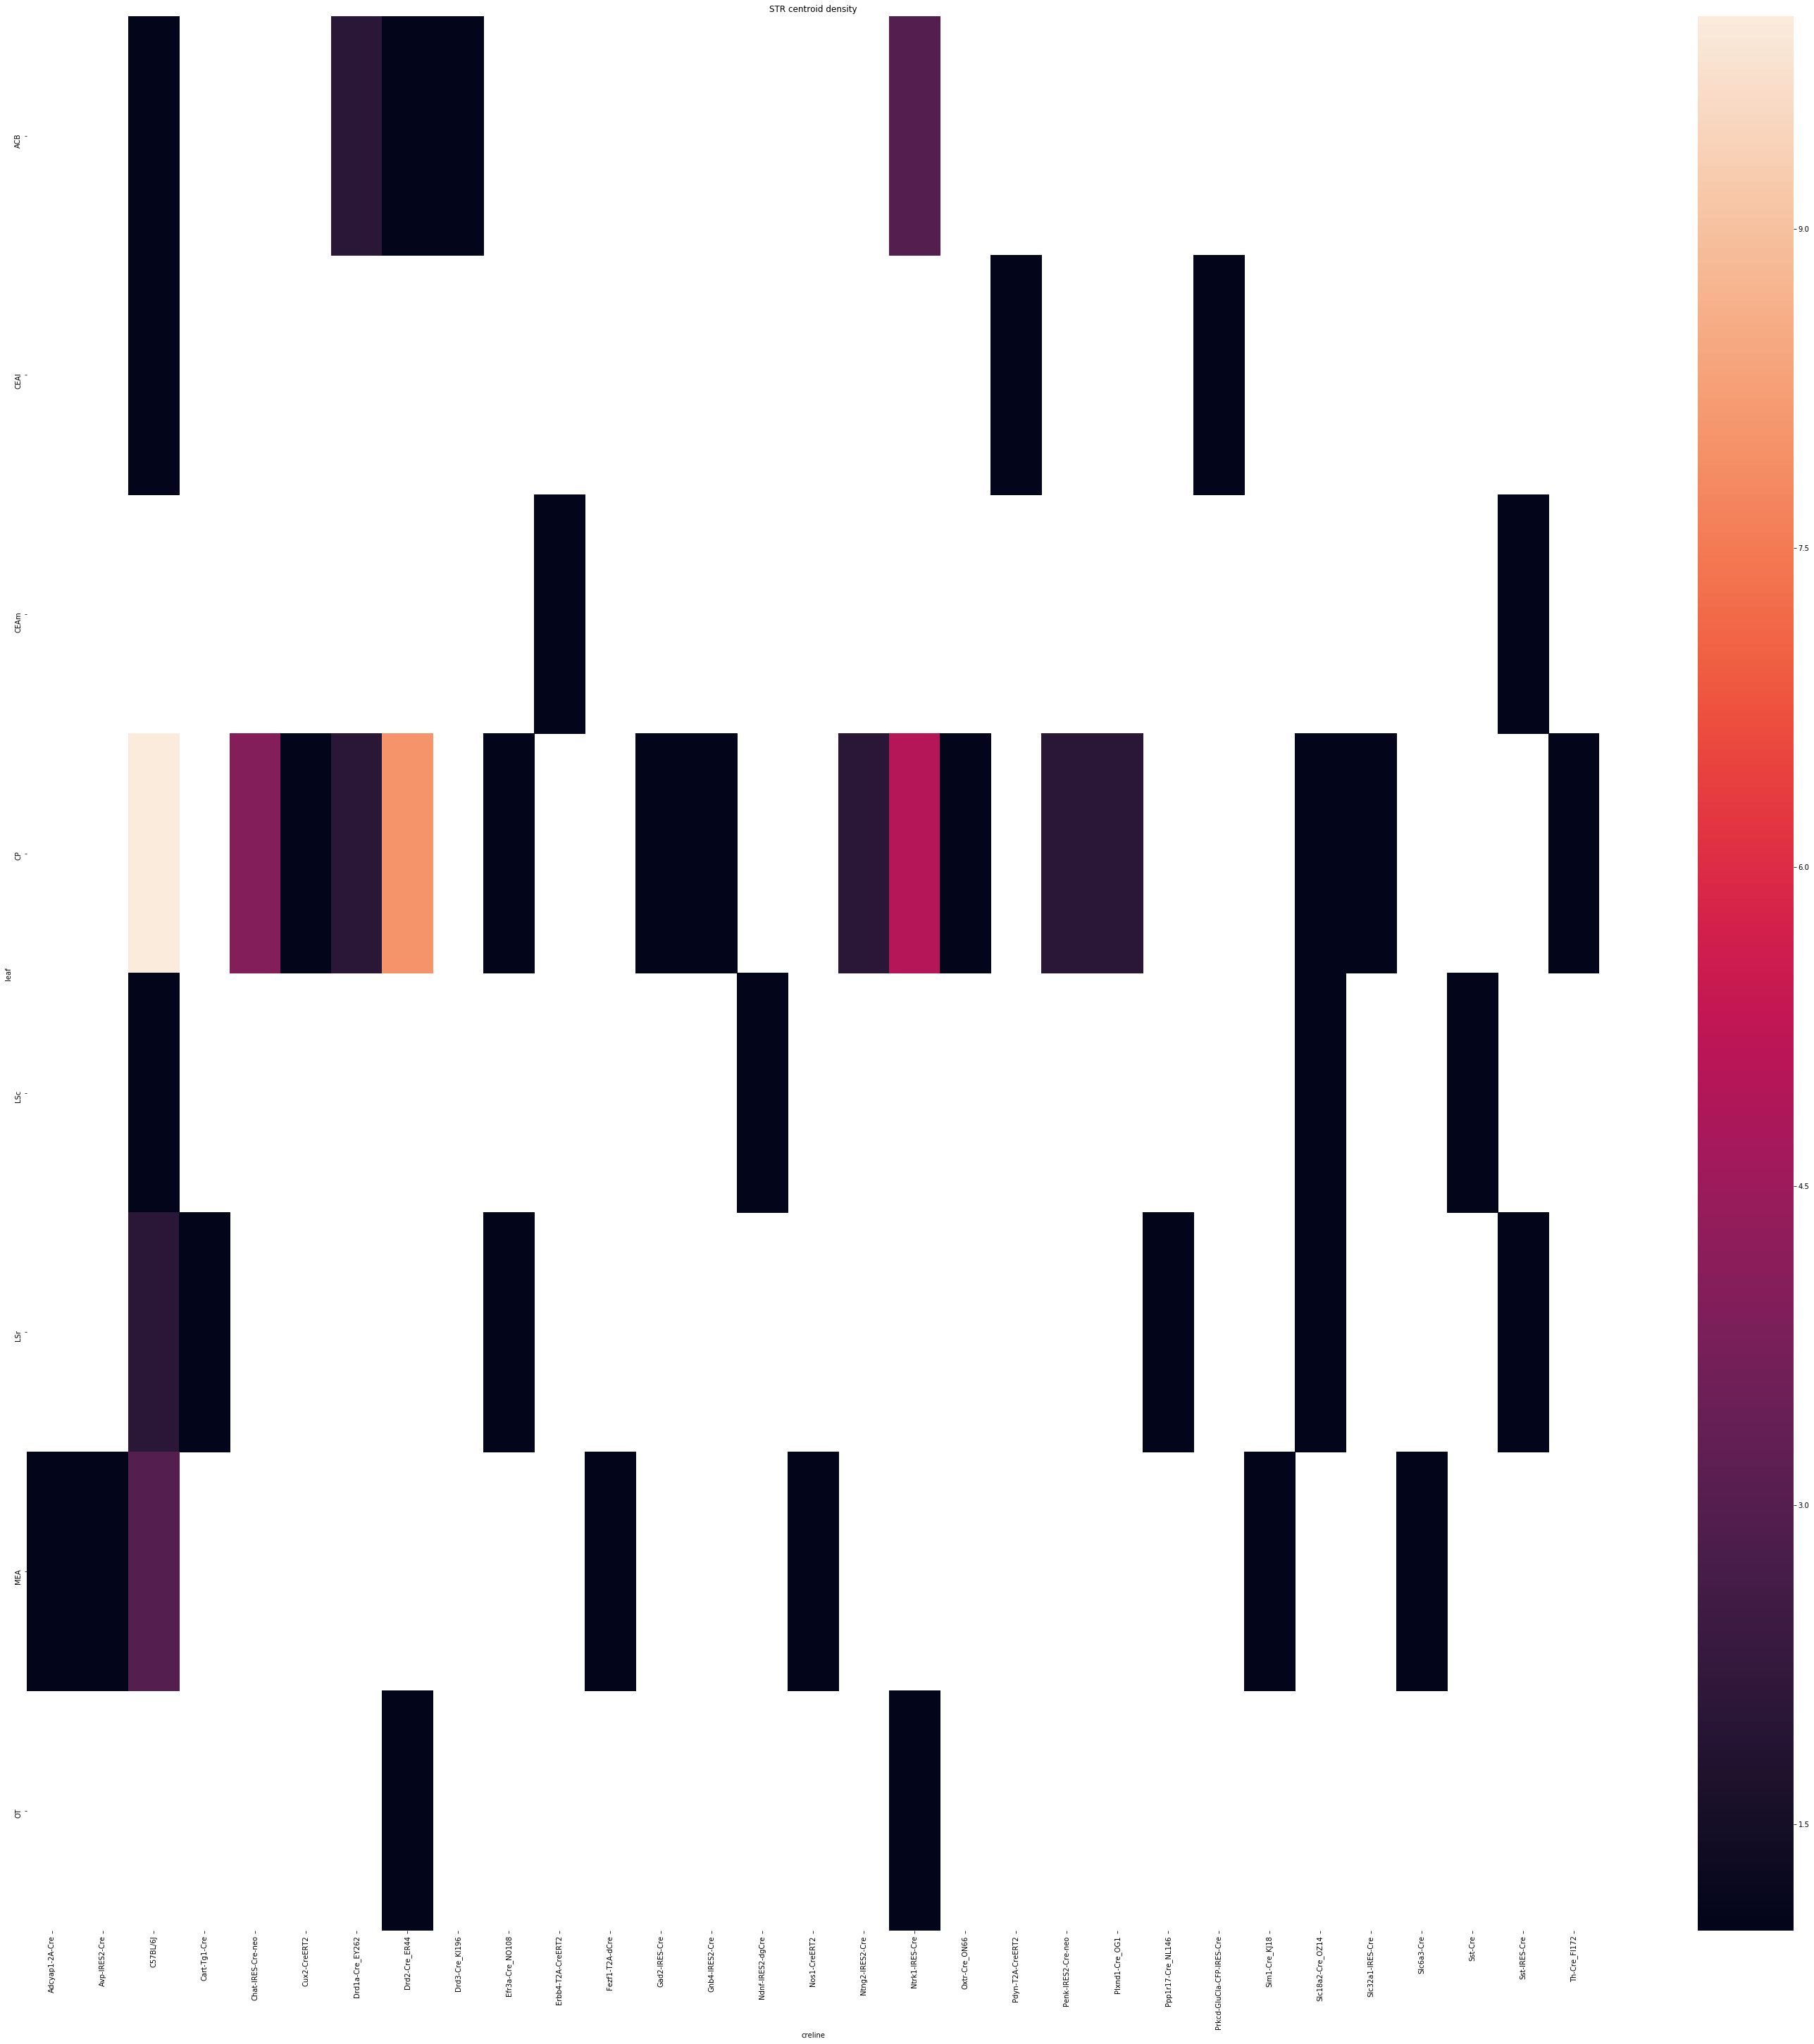

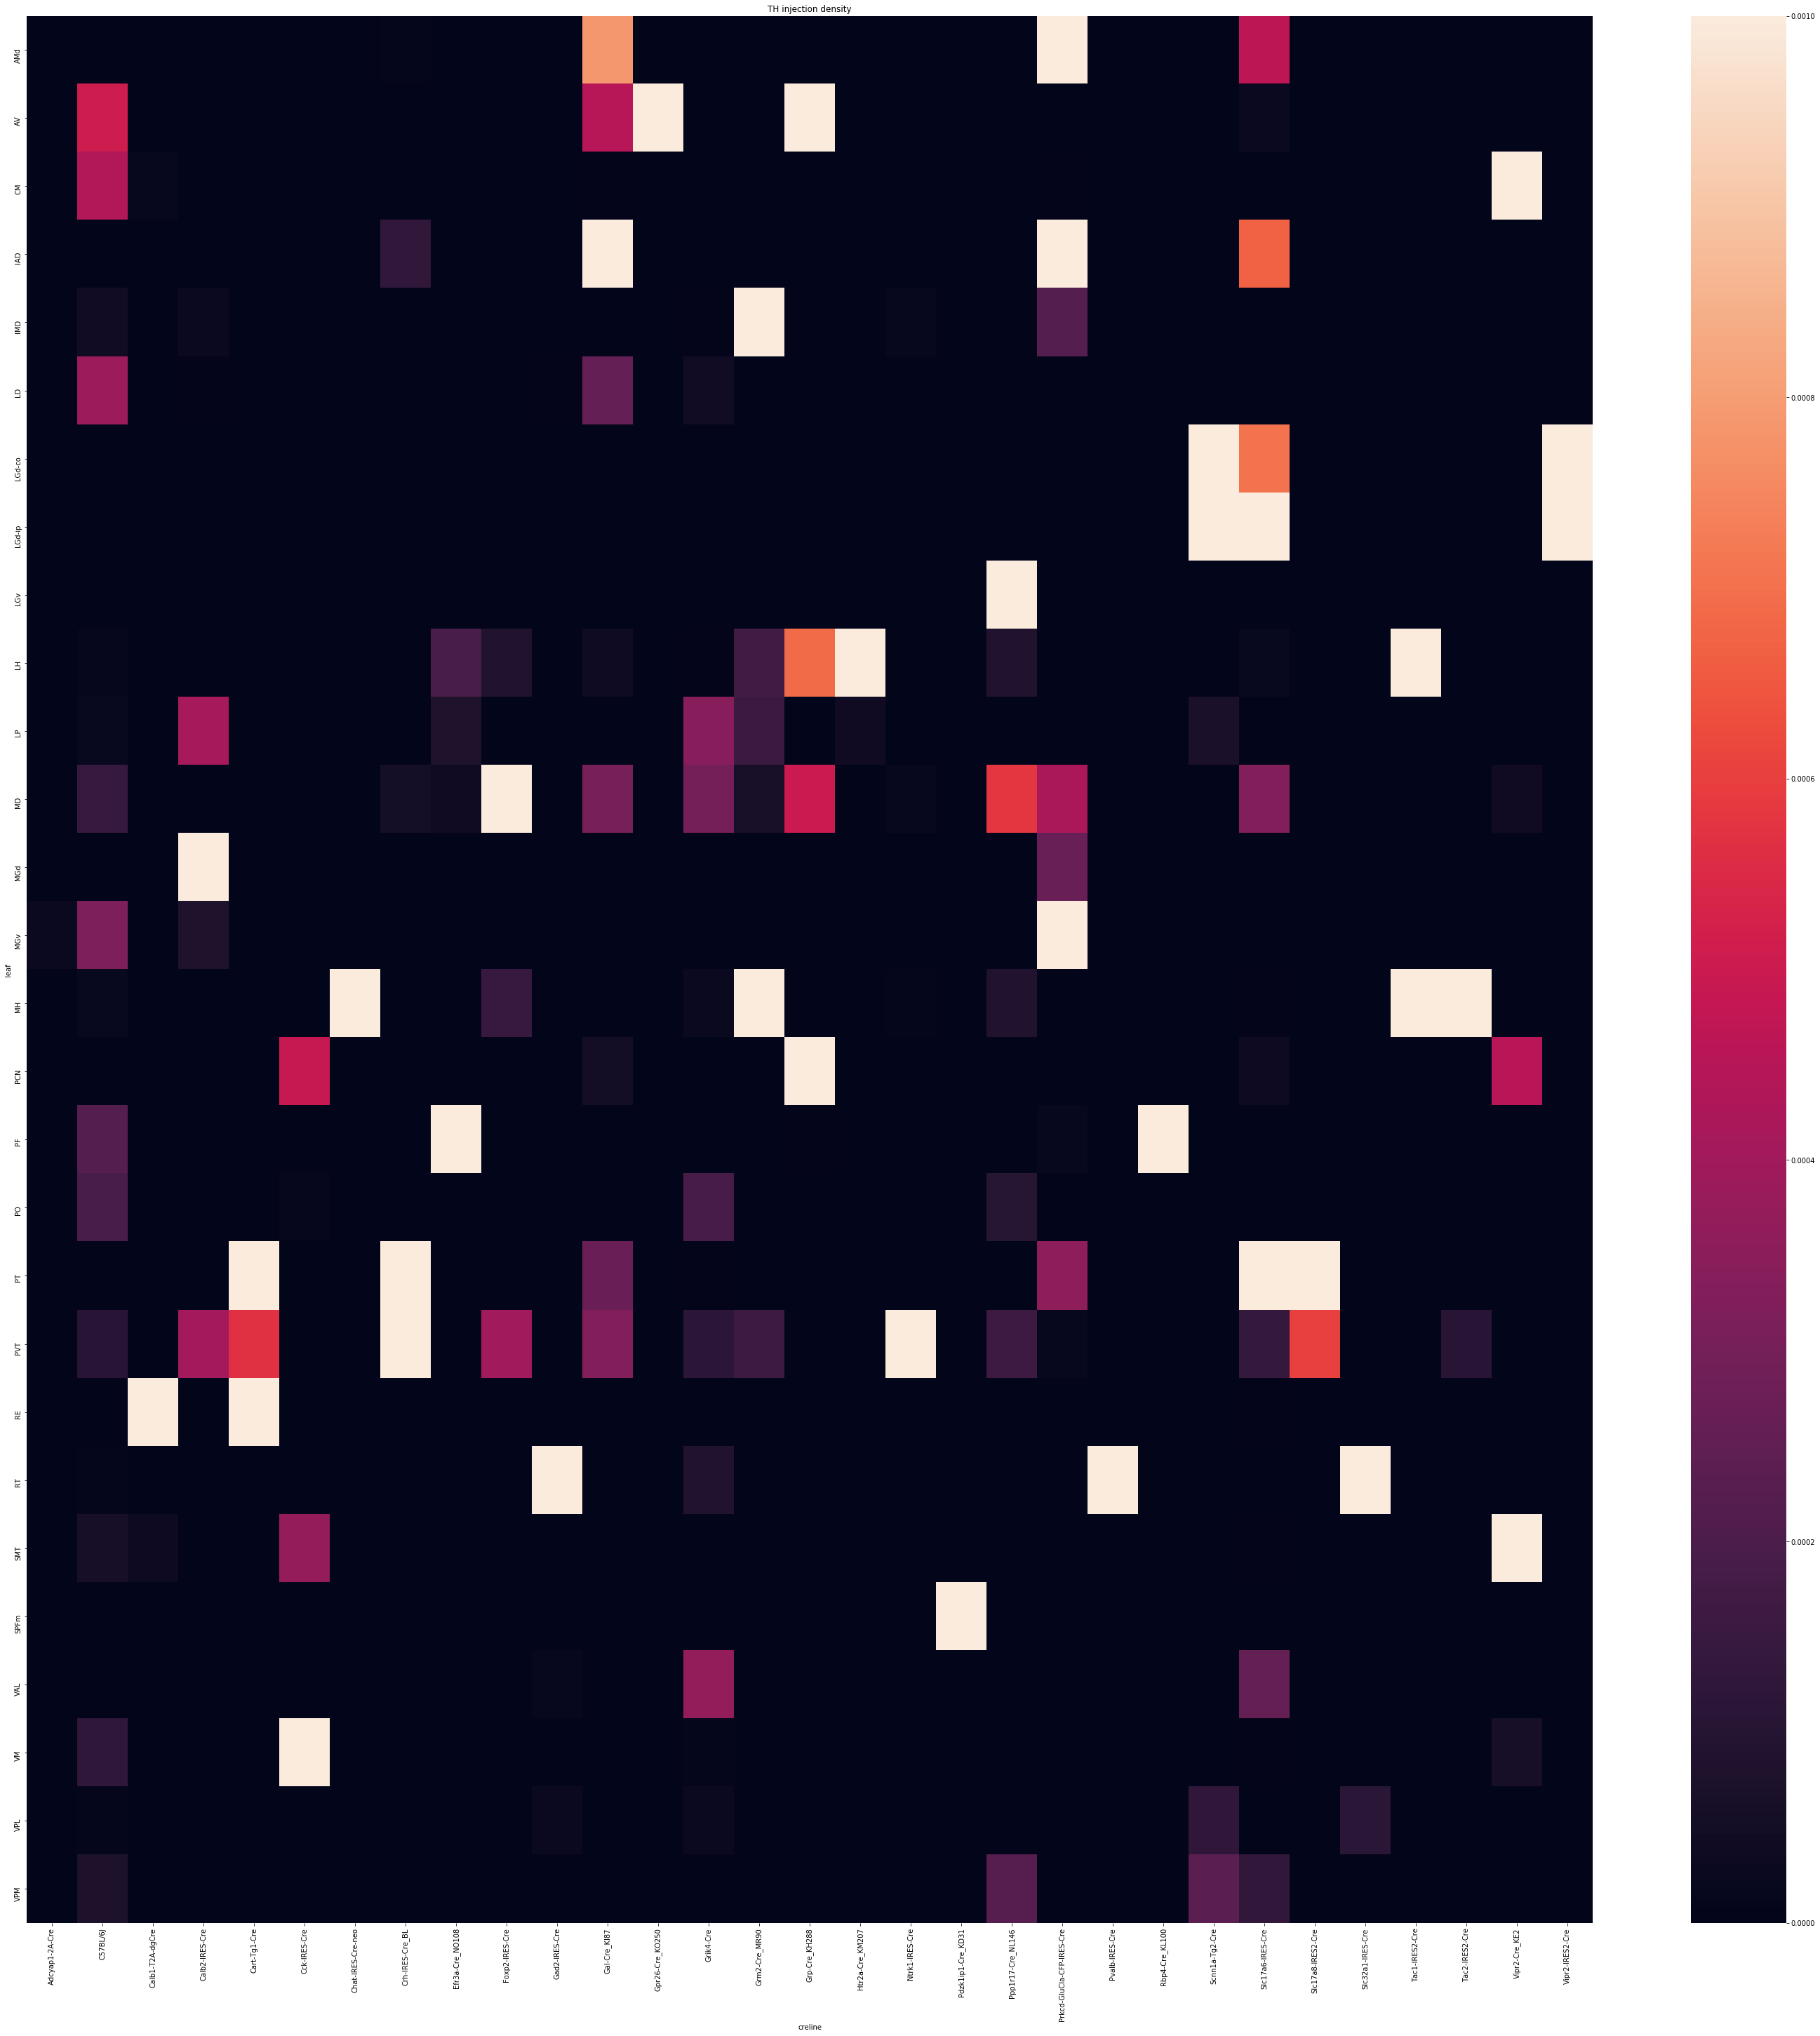

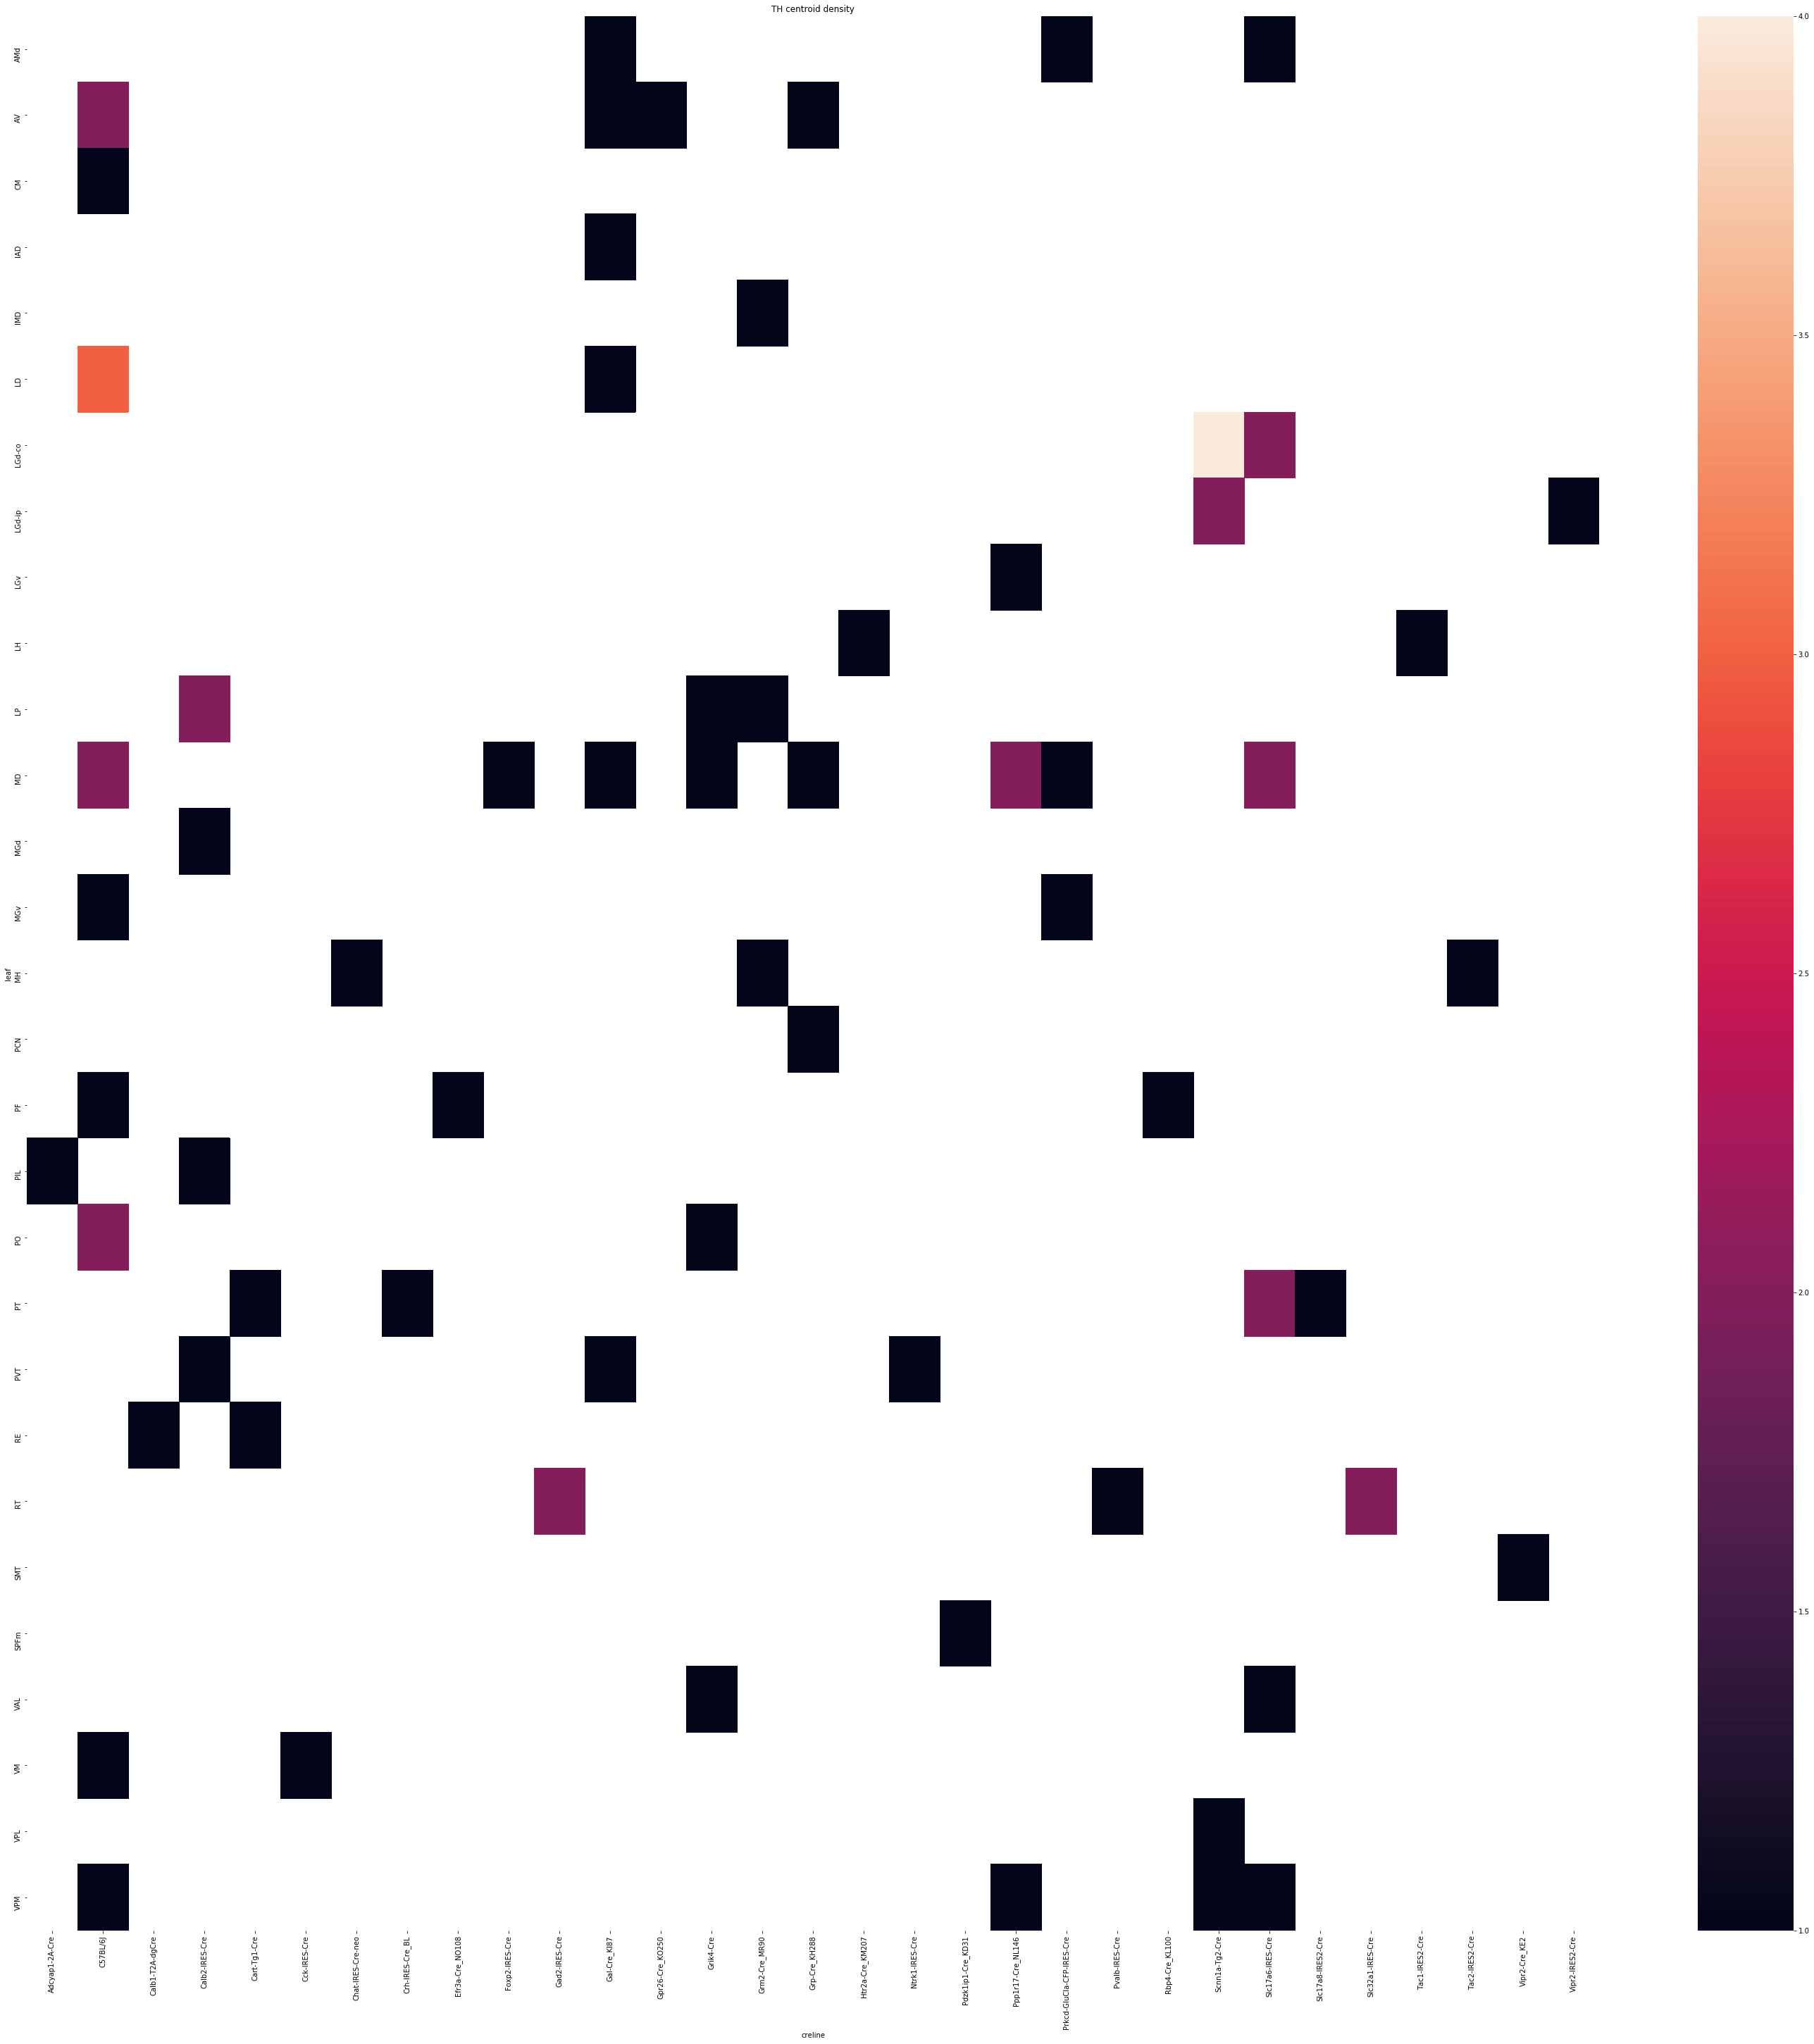

In [242]:
for m in range(len(major_structure_ids)):
    print(m)
    sid = major_structure_ids[m]
    source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
    source_key = source_mask.get_key(structure_ids=source_order)
    source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

    injs = msvds_leaf[sid].reg_inj_vcount_norm
    injr = np.reshape(injs, injs.shape[0]*injs.shape[1]) #first injes[0], then injs[1]
    leaf = np.tile(source_regions, injs.shape[0])
    cree = np.repeat(creline[sid], injs.shape[1])


    ls = [ia_map[leaf[i]] for i in range(len(leaf))]
    crs = cree
    df = pd.DataFrame(np.asarray([ls, crs, injr]).transpose())
    df.columns = np.asarray(['leaf', 'creline','inj'])
    df['inj'] = np.asarray(df['inj'], dtype = float)
    a = df.pivot_table(values='inj',index='leaf',columns='creline',aggfunc=np.mean)

    fig, ax = plt.subplots(1,figsize = (50,50))
    sns.heatmap(a, vmax = .001,ax = ax)
    plt.title(str(major_structures[m]) + ' injection density')
    plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' injection density')
    
    ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
    crs = creline[sid]
    df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
    df.columns = np.asarray(['leaf', 'creline','present'])
    a = df.pivot_table(values='present',index='leaf',columns='creline',aggfunc=np.sum)

    fig, ax = plt.subplots(1,figsize = (50,50))
    sns.heatmap(a, ax = ax)
    plt.title(str(major_structures[m]) + ' centroid density')
    plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' centroid density')
    
    #plt.xlabel(fontsize = 15)

'/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models'

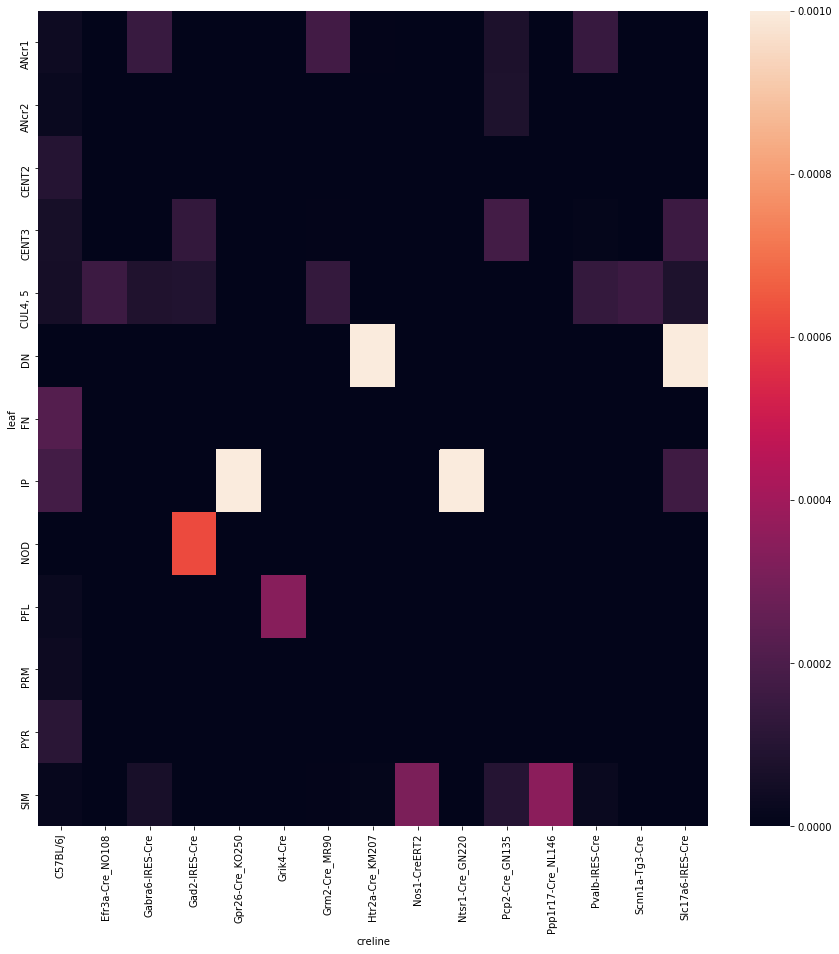

In [179]:
ls = [ia_map[leafs[sid][eval_indices_leaf2ormore[sid]][i]] for i in range(len(eval_indices_leaf2ormore[sid]))]
crs = creline[sid][eval_indices_leaf2ormore[sid]]
df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
df.columns = np.asarray(['leaf', 'creline','present'])
a = df.pivot_table(values='present',index='leaf',columns='creline',aggfunc=np.sum)

(83, 28)

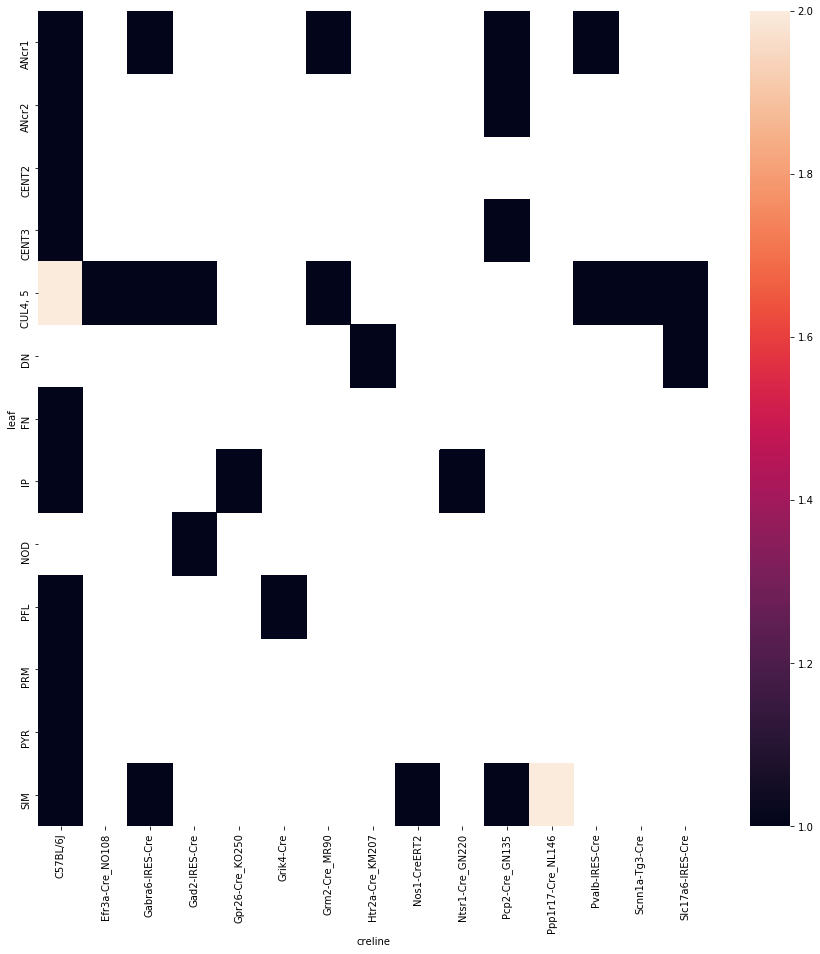

In [228]:
ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
crs = creline[sid]
df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
df.columns = np.asarray(['leaf', 'creline','present'])
a = df.pivot_table(values='present',index='leaf',columns='creline',aggfunc=np.sum)

fig, ax = plt.subplots(1,figsize = (15,15))
sns.heatmap(a, ax = ax)
#plt.xlabel(fontsize = 15)

In [244]:
sid = 315
msvds[sid].loocv_predictions_cortexgoodleaf_leaf2.shape

(5, 1128, 577)

In [247]:
np.where(leafs[sid] == ai_map['VISp4'])[0]

array([  16,   23,   36,   40,   41,   42,   69,   76,   91,  126,  148,
        155,  169,  173,  183,  200,  229,  245,  271,  289,  321,  322,
        324,  333,  343,  398,  410,  412,  419,  439,  446,  449,  490,
        492,  512,  518,  534,  570,  573,  583,  591,  605,  610,  630,
        632,  666,  675,  682,  687,  694,  697,  723,  754,  757,  786,
        787,  791,  811,  815,  844,  850,  863,  883,  889,  905,  960,
       1003, 1008, 1026, 1029, 1061, 1086, 1100, 1108, 1125])

In [249]:
losses_cortgood_leaf2ormore[315][:,np.where(leafs[sid] == ai_map['VISp4'])[0]]

IndexError: index 666 is out of bounds for axis 1 with size 652

In [250]:
np.where(leafs[sid] == ai_map['VISp4'])[0]

array([  16,   23,   36,   40,   41,   42,   69,   76,   91,  126,  148,
        155,  169,  173,  183,  200,  229,  245,  271,  289,  321,  322,
        324,  333,  343,  398,  410,  412,  419,  439,  446,  449,  490,
        492,  512,  518,  534,  570,  573,  583,  591,  605,  610,  630,
        632,  666,  675,  682,  687,  694,  697,  723,  754,  757,  786,
        787,  791,  811,  815,  844,  850,  863,  883,  889,  905,  960,
       1003, 1008, 1026, 1029, 1061, 1086, 1100, 1108, 1125])

In [251]:
losses_cortgood_leaf2ormore[315].shape

(5, 652)

In [252]:
msvds[sid].loocv_predictions_cortexgoodleaf_leaf2

(5, 1128, 577)

In [266]:
a = {}
a[315] = reg_proj_vcount_norm_renorms[315]
b = {}
b[315] =msvds[315].loocv_predictions_cortexgoodleaf_leaf2
c = {}
c[315] =np.where(leafs[sid] == ai_map['VISp4'])[0]

In [267]:
d = get_loss(a, b,c,c,keys = keys)


In [269]:
np.nanmean(d[315], axis = 1)

array([0.44376526, 0.47173079, 0.4974418 , 0.5281864 , 0.56921228])

In [263]:
np.linalg.norm(msvds[315].loocv_predictions_cortexgoodleaf_leaf2[0][c[315]],axis = 1)

array([0.78790868, 0.94369358, 0.86544048, 0.87709416, 0.87342619,
       0.82852175, 0.88062805, 0.81637077, 0.80278551, 0.89860294,
       0.85431284, 0.86826675, 0.8411638 , 0.85583191, 0.81959778,
       0.88319548, 0.79599711, 0.86121641, 0.90839021, 0.86259446,
       0.85675118, 0.86471767, 0.86124508, 0.78504649, 0.83560923,
       0.80202855, 0.85902968, 0.85950462, 0.79331402, 0.90717135,
       0.8011357 , 0.88112779, 0.8251865 , 0.86049081, 0.85676504,
       0.85238213, 0.88029699, 0.85870562, 0.92582846, 0.82711415,
       0.86781404, 0.87293906, 0.79092616, 0.958612  , 0.85256068,
       0.85646821, 0.80629046, 0.87055167, 0.84260525, 0.80794263,
       0.81575698, 0.83727877, 0.83450799, 0.81288549, 0.8530942 ,
       0.88827453, 0.82226509, 0.8650424 , 0.8028279 , 0.88420733,
       0.79226256, 0.83563934, 0.84721956, 0.87492041, 0.80563434,
       0.8614564 , 0.83552111, 0.82627867, 0.81064085, 0.86562908,
       0.83791588, 0.85244186, 0.87489996, 0.885718  , 0.83778

(5, 75)

In [264]:
msvds[315].loocv_predictions_cortexgoodleaf_leaf2.shape
#normalization question?

(5, 1128, 577)

In [265]:
np.linalg.norm(msvds[315].loocv_predictions_leaf_leaf2[0][c[315]],axis = 1)

array([0.74880112, 0.94210399, 0.83283776, 0.80342252, 0.84530354,
       0.79823578, 0.85017568, 0.72142148, 0.7548206 , 0.81237878,
       0.83052546, 0.76899335, 0.75659084, 0.7806447 , 0.79840275,
       0.85511799, 0.76093148, 0.79084627, 0.88756085, 0.79094446,
       0.81101424, 0.83422164, 0.83429329, 0.7572007 , 0.77195575,
       0.75567798, 0.81365446, 0.82794495, 0.7656078 , 0.86111875,
       0.75123453, 0.86097858, 0.78458092, 0.80885007, 0.79913553,
       0.81161907, 0.85271805, 0.83998921, 0.92244635, 0.76141893,
       0.81518014, 0.82020311, 0.76006446, 0.85164133, 0.78044547,
       0.8562301 , 0.76699894, 0.84395979, 0.82923694, 0.75404142,
       0.75986265, 0.79184621, 0.80304485, 0.78573897, 0.82314847,
       0.83398868, 0.77129695, 0.80319281, 0.74875996, 0.85738757,
       0.75531602, 0.79881269, 0.81860933, 0.85527588, 0.75456018,
       0.78408735, 0.74587471, 0.76226645, 0.76504474, 0.81723435,
       0.78611983, 0.77237223, 0.8300213 , 0.83090999, 0.73688

In [270]:
a = {}
a[315] = reg_proj_vcount_norm_renorms[315]
b = {}
b[315] =msvds[315].loocv_predictions_leaf_leaf2
c = {}
c[315] =np.where(leafs[sid] == ai_map['VISp4'])[0]

In [271]:
d = get_loss(a, b,c,c,keys = keys)


In [272]:
np.nanmean(d[315], axis = 1)

array([0.44014333, 0.46478261, 0.50074013, 0.53096036, 0.55755219])

In [273]:
np.where(creline[315] == 'C57BL/6J')[0]

array([   9,   13,   33,   41,   74,   81,   93,  101,  116,  120,  121,
        131,  148,  151,  158,  202,  237,  241,  254,  255,  257,  258,
        275,  282,  285,  286,  305,  314,  321,  330,  331,  346,  348,
        354,  360,  366,  381,  394,  398,  410,  421,  427,  429,  433,
        441,  444,  447,  458,  479,  492,  512,  523,  540,  546,  558,
        566,  573,  586,  596,  601,  623,  630,  632,  676,  681,  688,
        696,  697,  701,  710,  712,  749,  755,  765,  772,  778,  800,
        801,  807,  811,  816,  826,  829,  834,  853,  863,  865,  873,
        883,  893,  913,  920,  922,  923,  926,  947,  948,  951,  954,
        965,  981,  998, 1001, 1006, 1015, 1022, 1025, 1027, 1028, 1029,
       1036, 1037, 1058, 1065, 1066, 1070, 1072, 1084, 1086, 1100, 1125,
       1127])

In [275]:
np.intersect1d(np.where(creline[315] == 'Cux2-IRES-Cre')[0], np.where(leafs[sid] == ai_map['VISp4'])[0])

array([  40,   42,   76,  126,  155,  200,  245,  333,  534,  583,  605,
        682,  889, 1008])

In [276]:
np.intersect1d(np.where(creline[315] == 'C57BL/6J')[0], np.where(leafs[sid] == ai_map['VISp4'])[0])

array([  41,  148,  321,  398,  410,  492,  512,  573,  630,  632,  697,
        811,  863,  883, 1029, 1086, 1100, 1125])

In [277]:
a = {}
a[315] = reg_proj_vcount_norm_renorms[315]
b = {}
b[315] =msvds[315].loocv_predictions_wtleaf_leaf2
c = {}
c[315] =np.intersect1d(np.where(creline[315] == 'Cux2-IRES-Cre')[0], np.where(leafs[sid] == ai_map['VISp4'])[0])
d = get_loss(a, b,c,c,keys = keys)


In [278]:
np.nanmean(d[315], axis = 1)

array([0.85363496, 0.85191162, 0.8549094 , 0.85922851, 0.87615932])

In [279]:
a = {}
a[315] = reg_proj_vcount_norm_renorms[315]
b = {}
b[315] =msvds[315].loocv_predictions_wtleaf_leaf2
c = {}
c[315] =np.intersect1d(np.where(creline[315] == 'C57BL/6J')[0], np.where(leafs[sid] == ai_map['VISp4'])[0])
d = get_loss(a, b,c,c,keys = keys)


In [280]:
np.nanmean(d[315], axis = 1)

array([0.09860833, 0.12457887, 0.13586294, 0.14495715, 0.14508494])

4


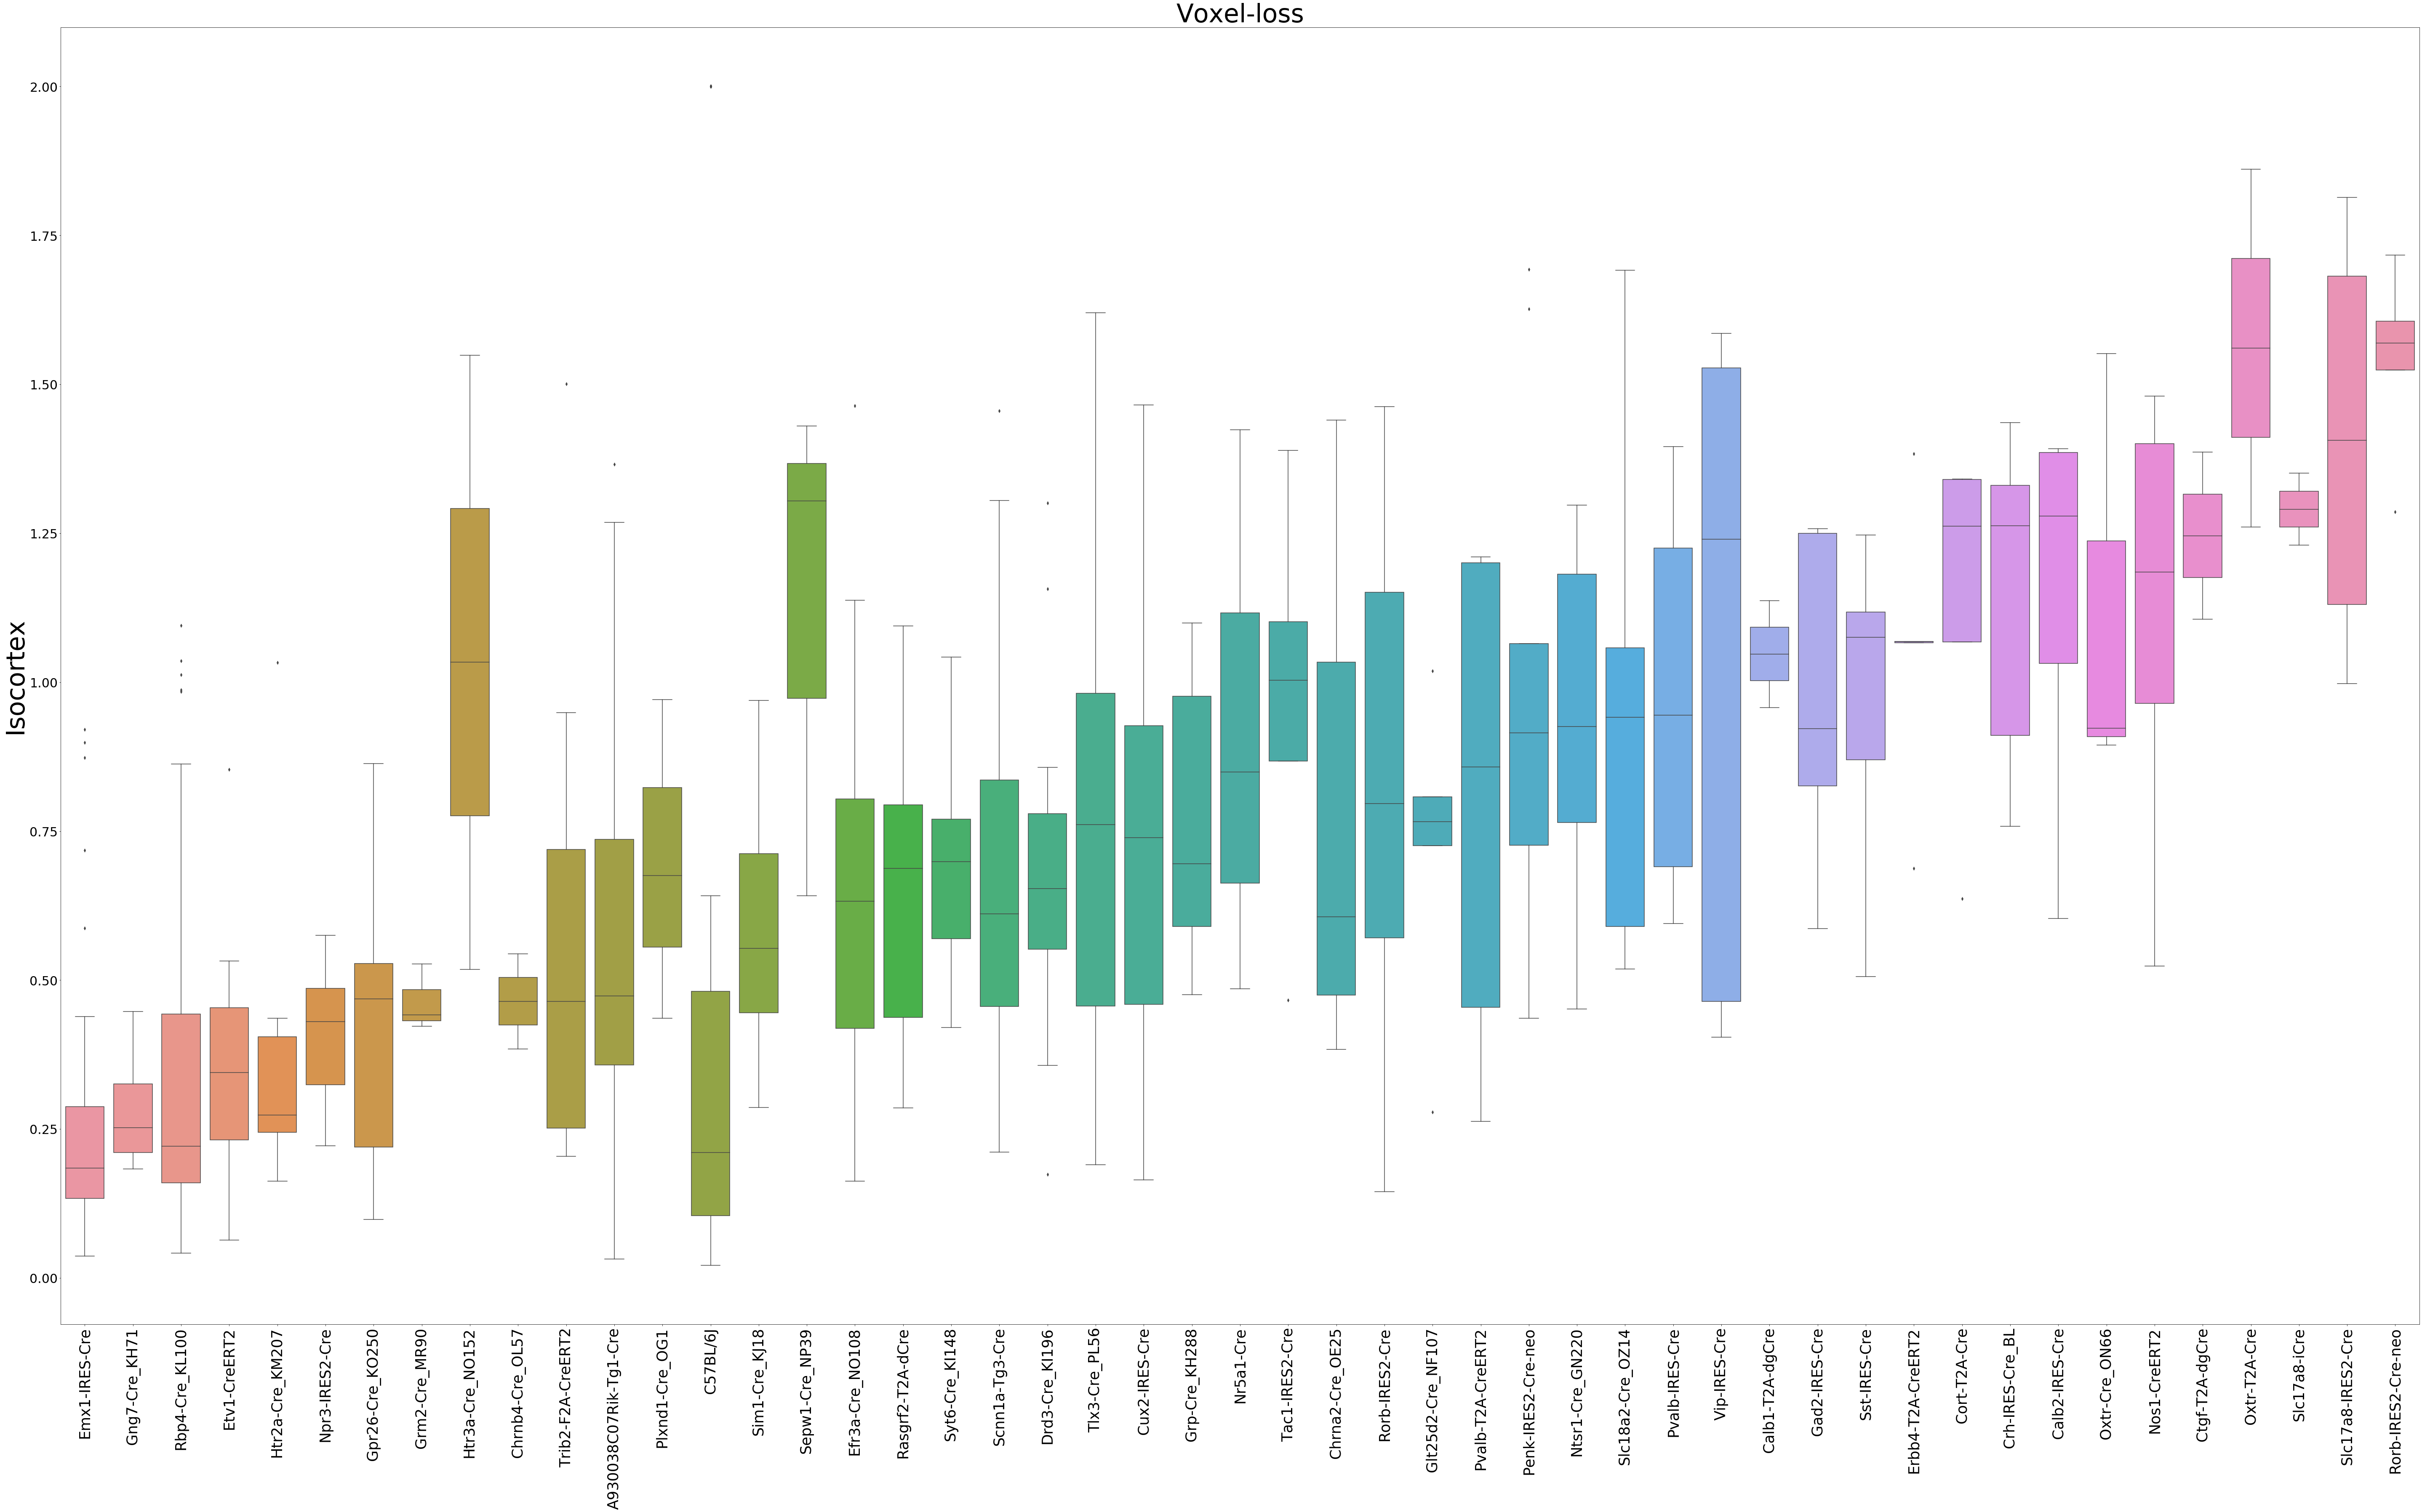

In [292]:
%matplotlib inline
nms = len(major_structure_ids)
fig, ax = plt.subplots(1,1, figsize = (80,50))
#for m in range(1):
for m in range(4,5):#nms[4:5]):
    print(m)
    sid = major_structure_ids[m]
#     sns.boxplot(x = creline[sid], y = paperlosses_all[sid][selected_gamma_all[m]], ax=axes[m,0])
#     axes[m,0].set_xticklabels(axes[m,0].get_xticklabels(), rotation=90, fontsize = 35)
#     #axes[m,0].set_yticklabels(axes[m,0].get_yticklabels(), fontsize = 40)
#     axes[m,0].tick_params(axis='y', which='major', labelsize=30)
#     #axes[m,0].set_xl
#     axes[m,0].set_ylabel(major_structures[m], fontsize = 60)
    losses_bycre = pd.DataFrame(np.asarray([losses_wt_leaf2ormore_wt[sid][best_gamma_wtleaf_wtleaf2[m,0]], creline[sid][eval_indices_leaf2ormore_wt[sid]]]).transpose())
    losses_bycre = losses_bycre.astype({0: np.float64})
    order = np.unique(losses_bycre[1])[losses_bycre.groupby(by=[1])[0].mean().argsort()]
    sns.boxplot(x = creline[sid][eval_indices_leaf2ormore_wt[sid]], y = losses_wt_leaf2ormore_wt[sid][best_gamma_finest_finest2[m,0]], ax=ax, order = order)
    #axes[m,1].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = 35)
    #axes[m,0].set_xl
    ax.tick_params(axis='y', which='major', labelsize=30)
    ax.set_ylabel(major_structures[m], fontsize = 60)
    
#     sns.boxplot(x = creline[sid], y = paperlosses_all_reg[sid][selected_gamma_all_reg[m]], ax=axes[m,2])
#     #axes[m,2].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
#     axes[m,2].set_xticklabels(axes[m,2].get_xticklabels(), rotation=90, fontsize = 35)
#     axes[m,2].tick_params(axis='y', which='major', labelsize=30)
#     #axes[m,0].set_xl
#     axes[m,2].set_ylabel(major_structures[m], fontsize = 60)
    
    ax.set_title('Voxel-loss', fontsize = 60)
plt.tight_layout() 
plt.savefig('/Users/samsonkoelle/justsaveit')
    #axes[0,1].set_title('All-normalized-voxelloss', fontsize = 60)
    #axes[0,2].set_title('All-regionalloss', fontsize = 60)
    #add losses for crenorm

In [282]:
losses_wt_leaf2ormore_wt

{512: array([[2.        , 1.12506148, 1.20693518, 1.52633667, 1.07456061,
         1.13502983, 0.48556435, 2.        , 0.23437621, 0.30526766,
         0.63988983, 0.55707373, 0.98173331, 0.44659387, 1.39612607,
         1.65425878, 1.71465457, 0.23437622, 1.86021855, 2.        ,
         0.64250001, 0.1926802 , 2.        , 2.        , 2.        ,
         1.32574984, 1.4856732 , 0.86409032, 1.35224059],
        [2.        , 1.12506148, 1.20693575, 1.52633667, 1.07456061,
         1.13502983, 0.48555512, 2.        , 0.23437621, 0.30526766,
         0.63988983, 0.55707373, 0.98173331, 0.44659387, 1.39612607,
         1.65425878, 1.71465457, 0.23437622, 1.86021988, 2.        ,
         0.64250001, 0.20426195, 2.        , 2.        , 2.        ,
         1.32574984, 1.4856732 , 0.86409032, 1.32448794],
        [2.        , 1.12506148, 1.20693575, 1.52633667, 1.07456061,
         1.13502983, 0.48555884, 2.        , 0.23437621, 0.30526766,
         0.63988983, 0.55707373, 0.98173331, 0.4465

In [283]:
eval_indices_leaf2ormore_wt[sid]

array([ 0,  1,  2,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 18, 19, 20,
       21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34])

In [284]:
pd.DataFrame(np.asarray([losses_wt_leaf2ormore_wt[sid][eval_indices_leaf2ormore_wt[m,0]], creline[sid][eval_indices_leaf2ormore_wt[sid]]]).transpose())

KeyError: (0, 0)

In [286]:
eval_indices_leaf2ormore_wt

{512: array([ 0,  1,  2,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 18, 19, 20,
        21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34]),
 703: array([], dtype=int64),
 1089: array([  0,   1,   2,   3,   4,   5,   6,   9,  11,  12,  13,  14,  15,
         19,  21,  24,  25,  26,  27,  28,  29,  30,  32,  34,  37,  38,
         39,  40,  43,  44,  45,  46,  47,  48,  49,  51,  52,  53,  54,
         55,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         72,  73,  74,  77,  78,  80,  81,  83,  84,  86,  87,  89,  90,
         91,  92,  93,  96,  98, 100, 101, 102, 103, 104, 105, 108, 109,
        111, 112, 115, 116, 117, 118, 119, 120, 121]),
 1097: array([ 0,  4, 10, 22, 29, 33, 34, 35, 38, 51, 57, 58, 59, 69, 75]),
 315: array([   0,    1,    2,    3,    4,    6,    7,    8,    9,   10,   11,
          12,   13,   15,   16,   18,   20,   21,   22,   23,   24,   25,
          26,   30,   31,   32,   33,   34,   36,   39,   40,   41,   42,
          43,   44,   47,   4

In [293]:
major_structures

['CB',
 'CTXsp',
 'HPF',
 'HY',
 'Isocortex',
 'MB',
 'MY',
 'OLF',
 'P',
 'PAL',
 'STR',
 'TH']

In [295]:
major_structure_ids[0]

512

In [296]:
msvds[512].reg_inj_vcount_norm.shape

(36, 13)

In [298]:
msvds_leaf[512].reg_inj_vcount_norm.shape

(36, 13)

In [308]:
cucks = np.where(creline[315] == 'Cux2-IRES-Cre')[0]

In [309]:
visp4s = np.where(leafs[sid] == ai_map['VISp4'])[0]

In [311]:
np.intersect1d(cucks, visp4s)

array([  40,   42,   76,  126,  155,  200,  245,  333,  534,  583,  605,
        682,  889, 1008])

In [316]:
pd.DataFrame(np.asarray(list(msvds[315].experiments.keys()))[np.intersect1d(cucks, visp4s)]).to_clipboard()

In [317]:
msvds[315].reg_inj_vcount_norm.shape

(1128, 119)